In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import mne
import pyxdf
import pandas as pd
import re
import mne
from sklearn.decomposition import fastica
from pyprep import PrepPipeline, NoisyChannels
from matplotlib.colors import TwoSlopeNorm
import matplotlib
from mne_icalabel import label_components
from autoreject import AutoReject
%matplotlib qt
matplotlib.use('Qt5Agg')

mne.set_log_level('warning')

In [2]:
# some function to make the end result more readable:
#filename has to be the entire path to the file so "data//P101//filename"
import numpy as np
import matplotlib.pyplot as plt
import mne
import pyxdf

def get_data(filename, pilot=False):    # Pilot = True for all pilots except Pilot117
    print('Reading data')

    # Because of the software switch there are now 3 ACC channels and one Marker channel
    nr_non_eeg = 4
    if pilot:
        nr_non_eeg = 3

    # Reading in the xdf files and extracting the marker and eeg streams
    streams, fileheader = pyxdf.load_xdf(filename, select_streams=[{'type': 'EEG'}, {'name':'LSL4Unity.OmnideckWaiterVR'}] , synchronize_clocks=False)
    marker_stream = next(s for s in streams if 'LSL4Unity.OmnideckWaiterVR' in s['info']['name'][0])
    eeg_stream = next(s for s in streams if "EEG" in s['info']['type'][0])
    eeg_data = np.array(eeg_stream['time_series']).T
    #eeg_timestamps = np.array(eeg_stream['time_stamps'])
    sfreq = float(eeg_stream['info']['nominal_srate'][0])

    # Collection all ch names and renaming TP9, TP10
    ch_names = []
    for ch in eeg_stream['info']['desc'][0]['channels'][0]['channel']:
        if ch['label'][0] == 'TP10':
            ch_names.append('FCz')
        elif ch['label'][0] == 'TP9':
            ch_names.append('Fpz')
        elif ch['label'][0] == 'FPz':
            ch_names.append('Fpz')
        else:
            ch_names.append(ch['label'][0])
    info = mne.create_info(
        ch_names=ch_names[:-nr_non_eeg],
        sfreq=sfreq,
        ch_types='eeg'
    )
    raw = mne.io.RawArray(eeg_data[:-nr_non_eeg]/10e5, info)

    # Creating the Montage
    montage = mne.channels.make_standard_montage('standard_1020')
    raw.set_montage(montage)

    # Calculating the event samples for the annotations
    event_samples = (marker_stream['time_stamps'] - eeg_stream['time_stamps'][0])*sfreq
    event_samples = event_samples.astype(int)
    event_labels = [int(marker[0]) for marker in marker_stream['time_series']]


    annotations = mne.Annotations(onset=event_samples / sfreq,
                                  duration=[0] * len(event_samples),  # Instantaneous events
                                  description=list(event_labels))
    raw.set_annotations(annotations)

    return raw, marker_stream, event_samples

#apply a notch filter at 50hz and filter between 0.01 and 100Hz. Filter above 1Hz is applied when creating the epochs; lowpass filter at 40Hz is applied before saving the epochs
def filter_data(raw):
    # Notch Filter at 50 Hz
    raw = raw.notch_filter(50, method='fir', phase='zero',verbose=False)
    # Filter data between 0.01 and 100 Hz for the ICA algorithm
    iir_params = dict(order=2, ftype='butter',verbose=False)
    raw = raw.filter(l_freq=0.1, h_freq=100, method='iir', iir_params=iir_params, phase='zero', verbose=False)
    return raw


# making epochs around a specified marker, Applying 1Hz Highpass filter if epoch is used for ICA
def get_epochs(raw: mne.io.Raw, marker_stream, event_samples , marker_id:int, tmin:int, tmax:int, preload=False, ica=True):
    if ica:
        iir_params = dict(order=2, ftype='butter',verbose=False)
        raw = raw.copy()
        raw = raw.filter(l_freq=1, h_freq=None, method='iir', iir_params=iir_params, phase='zero', verbose=False)
    event_labels = [int(marker[0]) for marker in marker_stream['time_series']]
    events = np.array([[sample, 0, label] for sample, label in zip(event_samples, event_labels)])
    selected_events = events[events[:, 2] == marker_id]
    epochs = mne.Epochs(raw, np.array(selected_events), event_id=int(marker_id),baseline=None, tmin=tmin, tmax=tmax, reject_by_annotation=False, verbose=False, preload=preload) # , decim=decim
    return epochs

# Counts the markers and saves them in a file.
def count_markers(marker_stream, match = False):
    flat_list = [int(marker[0]) for marker in marker_stream['time_series']]
    marker_count = {}
    for marker in flat_list:
        if marker in marker_count:
            marker_count[marker] += 1
        else:
            marker_count[marker] = 1
    marker_count = dict(sorted(marker_count.items()))
    if match:
        with open(f'markers\\{match}_markers.txt', 'w') as file:
            for key, value in marker_count.items():
                file.write(f"{key}: {value}\n")
    #return marker_count

# ICA applied to individual epochs. Outdated function
def apply_ica_indiv(epochs: mne.Epochs):
    cleaned_epochs = []
    all_rej = []
    i = 0
    while i < np.shape(epochs.events)[0]:
        epoch = epochs[i]
        ica = mne.preprocessing.ICA(n_components=32, method='fastica', random_state=42)
        ica.fit(epoch)
        source = ica.get_sources(epoch).get_data()
        std = np.std(source)
        rej_ch = []
        for j, channel in enumerate(source[0]):
            if np.max(channel) > 5*std:     # This has been chosen somewhat arbitrarily now as it results in
                rej_ch.append(j)
        all_rej.append(rej_ch)

        cleaned_epochs.append(ica.apply(epoch, exclude=rej_ch))
        i+=1
    cleaned_epochs = mne.EpochsArray(
        data = np.squeeze([e.get_data() for e in cleaned_epochs]),
        info = epochs.info,
        events= epochs.events
    )
    return cleaned_epochs

# Naive way of ICA component rejection, based on maximum amplitude of component.
def get_ica(epochs: mne.Epochs, n_components=32, plot=False, save_path=None, match=None):
    ica = mne.preprocessing.ICA(n_components=n_components, max_iter= 1500, method='fastica', verbose=False)
    ica.fit(epochs, verbose=False)
    #std = np.std(ica.get_sources(epochs).get_data())
    rej_ch = []
    for i, channel in enumerate(ica.get_sources(epochs).get_data()[0]):
        std = np.std(channel)
        if np.max(np.absolute(channel)) > 6*std:
            rej_ch.append(i)
    if plot and len(rej_ch) != 0:
        #print(len(rej_ch))
        with open(f'figures\\meeting\\ica\\{match}.txt', 'w') as file:
            file.write(", ".join(map(str, rej_ch)))
            file.write(f"\n{len(rej_ch)} rejected channels")
            file.close()
        fig = ica.plot_components(title=f'{match} all ICA components', show=False);
        for j, f in enumerate(fig):
            f.savefig(save_path+f'{match}_{j}_all_ica.png')
            plt.close(f)
        fig = ica.plot_components(picks=rej_ch,title=f'{match} rejected channels', show=False);
        fig.savefig(save_path+f'{match}_rejected_ica.png')
        plt.close(fig)
    return ica, rej_ch
    #ica.apply(epochs, exclude=rej_ch, verbose=False)

# ICA method using the mne implementation of icalabel
def get_icalabel(epochs: mne.Epochs, n_components=32, plot=False, save_path=None, match=None):
    """"
    A function extracting the ICA components and rejecting all components that are not labeled Brain by the icalabel function. Using a certainty threshhold of 70%

    epochs | mne epoch for which to calculate the ICA
    n_components | number of ICA components
    plot | whether to plot the ICA components
    save_path | path to save the ICA components
    match | the match regex that indicates the participant, trial and condition
    """
    ica = mne.preprocessing.ICA(n_components=n_components, max_iter= 500, method='infomax', fit_params=dict(extended=True), verbose=False)
    ica.fit(epochs, verbose=False)
    rej_ch = []
    a = label_components(epochs, ica, method='iclabel')
    for i, ic in enumerate(a['labels']):
        #print(f'Component {i} is {ic} with proba {a['y_pred_proba'][i]}')
        if ic != 'brain':       #and a['y_pred_proba'][i] > 0.7
            rej_ch.append(i)

    # Ploitting the Components as well as Sources
    print('Rejected components:', len(rej_ch))
    if plot and len(rej_ch) != 0:
        # Saving Rejected channelsin txt
        with open(f'figures\\meeting\\ica\\{match}.txt', 'w') as file:
            file.write(", ".join(map(str, rej_ch)))
            file.write(f"\n{len(rej_ch)} rejected channels")
            file.close()

        # Plotting Components
        fig = ica.plot_components(title=f'{match} all ICA components', show=False);
        for j, f in enumerate(fig):
            f.savefig(save_path+f'{match}_{j}_all_ica.png')
            plt.close(f)
        fig = ica.plot_components(picks=rej_ch,title=f'{match} rejected channels', show=False);
        fig.savefig(save_path+f'{match}_rejected_ica.png')
        plt.close(fig)

        # Plotting Sources
        fig = ica.plot_sources(epochs, picks=slice(0,32,1))
        fig.savefig(save_path+f'{match}_ica_sources.png')
        plt.close(fig)
    return ica, rej_ch

# Filters the epochs and creates the MRCP Event from the epochs
def mrcp(epochs):
    frontal_channels = ['F3', 'Fz', 'F4', 'FC1', 'FCz', 'FC2', 'C3', 'Cz', 'C4', 'CP1', 'CP2']
    iir_params = dict(order=2, ftype='butter')
    epochs = epochs.filter(l_freq =0.1 ,h_freq=1, method='iir', iir_params=iir_params, phase='zero')
    evoked = epochs.average()
    evoked = evoked.pick(frontal_channels)
    return evoked

# Outdated function
def drop_bad_epochs(epochs):
    epoch_data = epochs.get_data()  # Shape: (n_epochs, n_channels, n_times)
    std_per_channel = np.std(epoch_data, axis=(0, 2))  # Standard deviation per channel
    threshold = 10 * std_per_channel[:, np.newaxis]  # Expand dims to match shape
    # Find epochs where any channel exceeds the threshold
    bad_epochs = np.any(np.abs(epoch_data) > threshold[np.newaxis, :, :], axis=(1, 2))
    print(f'Bad epochs: {len(bad_epochs)}')
    # Drop bad epochs
    epochs_clean = epochs[~bad_epochs]
    return epochs_clean

In [30]:
# Data-Preprocessing, extracting epochs and saving
# Filter Line-Noise, Find-noisy channels, interpolate channels, re-reference, filter target frequencies, create ica for this apply highpass at 1hz, save this, epoch data, save again
# Runtime Approx 13min
baseline_marker = 1000
target_markers = [1009, 1029]     #1009 = Handgrabbedbottle, 1029 Departing starts
iir_params = dict(order=2, ftype='butter',verbose=False)
# Pilots below P110 have different marker numbers 'P001', 'P002', 'P003', 'P005', 'P006', 'P007', 'P008', 'P009', 'P010', 'P011', 'P012', 'P013', 'P014'
participants = ['P001', 'P002', 'P003', 'P005', 'P006', 'P007', 'P008', 'P009', 'P010', 'P011', 'P012', 'P013', 'P014']
plot = False
for p in participants:
    path = f'data\\{p}\\'

    #### Creating folders to save ####
    base_fig_dir = f'figures\\meeting\\{p}'
    os.makedirs(base_fig_dir, exist_ok=True)
    os.makedirs(os.path.join(base_fig_dir, 'psd'), exist_ok=True)
    os.makedirs(os.path.join(base_fig_dir, 'epochs'), exist_ok=True)
    os.makedirs(os.path.join(base_fig_dir, 'ica'), exist_ok=True)
    os.makedirs(os.path.join(base_fig_dir, 'ica', 'baseline'), exist_ok=True)
    os.makedirs(os.path.join(base_fig_dir, 'ERDS'), exist_ok=True)
    os.makedirs(os.path.join(base_fig_dir, 'topomap'), exist_ok=True)
    os.makedirs(os.path.join(base_fig_dir, 'mrcp'), exist_ok=True)
    os.makedirs('epochs', exist_ok=True)
    os.makedirs(os.path.join('epochs', p), exist_ok=True)

    for condition in os.listdir(path):
        condition_path = os.path.join(path, condition)
        eeg_path = os.path.join(condition_path, 'eeg')
        if os.path.isdir(eeg_path):
            for filename in os.listdir(eeg_path):
                # Excluding not working files P003 Omnideck2, P007 joystick (leaning does not exist)
                files_to_exclude = ['sub-P003_ses-Omnideck2_task-Default_run-001_eeg.xdf', 'sub-P007_ses-Joystick1_task-Default_run-001_eeg.xdf']
                if filename in files_to_exclude:
                    continue

                item_path = os.path.join(eeg_path, filename)
                if filename.endswith('.xdf') and os.path.isfile(item_path):
                    print(f"Working on File: {filename}")
                    match = re.search(r'(sub-[^_]+_ses-[^_\\]+)', filename)[0]
                    raw, marker_stream, event_samples = get_data(item_path)
                    raw = filter_data(raw)

                    # Find Noisy channels using Perp pipeline
                    noisy = NoisyChannels(raw, do_detrend=True)
                    noisy.find_all_bads(ransac=True)
                    # Save how many channels will be interpolated to adjust for ICA
                    nr_bads = len(noisy.get_bads())
                    raw.info['bads'].extend(noisy.get_bads())
                    raw.interpolate_bads(reset_bads=True)
                    with open(f'figures\\meeting\\{p}\\{match}_rejecton_info.txt', 'w') as f:
                        f.write(f'Nr of bad channels: {nr_bads}\n')
                        f.write(f'Bad channels: {noisy.get_bads()}\n')

                    ### Plotting psd ###
                    fig = raw.plot_psd(average=True, fmax=50)
                    fig.savefig(f'figures\\meeting\\{p}\\psd\\{match}_raw_psd.png')
                    plt.close(fig)

                    # re-reference to average
                    raw.set_eeg_reference('average', projection=False, ch_type='eeg')

                    # Epochs for ICA
                    baseline_epochs = get_epochs(raw, marker_stream, event_samples, marker_id=baseline_marker, tmin=0, tmax=60, ica=True, preload=True)
                    ica, rej_ch = get_icalabel(baseline_epochs.load_data(),n_components=31-nr_bads, plot=plot, save_path=f'figures\\meeting\\{p}\\ica\\baseline\\', match = match)
                    ica.apply(baseline_epochs, exclude=rej_ch, verbose=False)
                    suffix = 'before'

                    # Ploting baseline PSD
                    if plot:
                        for i, base in enumerate(baseline_epochs):
                            if i != 0:
                                suffix = 'after'
                            fig = baseline_epochs[i].plot_psd(average=True, fmax=50)
                            fig.savefig(f'figures\\meeting\\{p}\\psd\\{match}_{suffix}_baseline_psd.png')
                            plt.close(fig)

                    # Filtering Baseline Epoch and Saving
                    baseline_epochs = baseline_epochs.filter(l_freq=0.01, h_freq=40, method='iir', iir_params=iir_params, phase='zero', verbose=False)
                    baseline_epochs.save(f'epochs\\{p}\\{match}_epochs_baseline_epo.fif', overwrite=True)

                    ### Loop for Target Markers ###
                    for target in target_markers:

                        # First load epochs with ICA=True to remove slow drifts and then apply to non high pass filtered data so it can be used for MRCP
                        target_epochs = get_epochs(raw, marker_stream, event_samples, marker_id=target, tmin=-6, tmax=4, ica=True, preload=True)
                        nr_epochs = len(target_epochs)

                        ### Epoch Rejection ###
                        ar = AutoReject(n_interpolate=np.array([1,2,3,4]), n_jobs=-1, verbose=True)
                        ar.fit(target_epochs)
                        target_epochs, log = ar.transform(target_epochs, return_log=True)
                        print(f'{target} | {nr_epochs-len(target_epochs)} epochs out of {nr_epochs} removed (filtered)')

                        ### ICA ###
                        ica, rej_ch = get_icalabel(target_epochs.load_data(), n_components=31-nr_bads, plot=plot, save_path=f'figures\\meeting\\{p}\\ica\\', match = f'{match}_{target}')
                        target_epochs = get_epochs(raw, marker_stream, event_samples, marker_id=target, tmin=-6, tmax=4, ica=False, preload=True)

                        ### Removing the Epochs found earlier and Applying ICA ###
                        print('Removing bad Epochs from filtered Data')
                        nr_epochs = len(target_epochs)
                        target_epochs.drop(log.bad_epochs)
                        print(f'{target} | {nr_epochs-len(target_epochs)} epochs out of {nr_epochs} removed')
                        ica.apply(target_epochs, exclude=rej_ch, verbose=False)

                        # Plotting PSD
                        if plot:
                            fig = target_epochs.plot_psd(average=True, fmax=50)
                            fig.savefig(f'figures\\meeting\\{p}\\psd\\{match}_{target}_psd.png')
                            plt.close(fig)
                            # Plotting Epochs
                            fig = target_epochs.plot(scalings=5e-5)
                            fig.savefig(f'figures\\meeting\\{p}\\epochs\\{match}_{target}_epochs.png')
                            plt.close(fig)
                        target_epochs = target_epochs.filter(l_freq=0.01,h_freq=40, method='iir', iir_params=iir_params, phase='zero', verbose=False)
                        target_epochs.save(f'epochs\\{p}\\{match}_epochs_{target}_epo.fif', overwrite=True)

                        # Extracting first occurence of 1009
                        # This is done by finding the first 1009 marker after a 1025 marker (approaching starts)
                        if target == 1009:
                            events, event_id = mne.events_from_annotations(raw)
                            event_1025 = events[events[:, 2] == event_id['1025']]
                            event_1009 = events[events[:, 2] == event_id['1009']]
                            # These [np.array(marker_onset), ...]
                            first_1009_after_1025 = []

                            # Extracting first 1009
                            for i in range(len(event_1025)):
                                start = event_1025[i, 0]

                                # Define search end: either next 1025 or end of data
                                if i + 1 < len(event_1025):
                                    stop = event_1025[i + 1, 0]
                                else:
                                    stop = np.inf
                                # Filter 1009s between this 1025 and the next
                                candidates = event_1009[(event_1009[:, 0] > start) & (event_1009[:, 0] < stop)]

                                if len(candidates) > 0:
                                    first_1009_after_1025.append(candidates[0][0])  # Only the first one

                            mask = np.isin(target_epochs.events[:, 0], first_1009_after_1025)
                            first_1009_epochs = target_epochs[mask]
                            first_1009_epochs = first_1009_epochs.filter(l_freq=0.01, h_freq=40, method='iir', iir_params=iir_params, phase='zero', verbose=False)
                            first_1009_epochs.save(f'epochs\\{p}\\{match}_epochs_first_1009_epo.fif', overwrite=True)

2025-07-16 19:37:54,064 - pyxdf.pyxdf - INFO - Importing XDF file data\P001\ses-Joystick1\eeg\sub-P001_ses-Joystick1_task-Default_run-001_eeg.xdf...


Working on File: sub-P001_ses-Joystick1_task-Default_run-001_eeg.xdf
Reading data


2025-07-16 19:37:54,773 - pyxdf.pyxdf - INFO -   performing jitter removal...


Rejected components: 18
Running autoreject on ch_type=eeg




Estimated consensus=0.30 and n_interpolate=3
1009 | 4 epochs out of 38 removed (filtered)
Rejected components: 24
Removing bad Epochs from filtered Data
1009 | 4 epochs out of 38 removed
Running autoreject on ch_type=eeg




Estimated consensus=0.70 and n_interpolate=4
1029 | 1 epochs out of 19 removed (filtered)
Rejected components: 23
Removing bad Epochs from filtered Data
1029 | 1 epochs out of 19 removed


2025-07-16 19:40:34,033 - pyxdf.pyxdf - INFO - Importing XDF file data\P001\ses-Joystick2\eeg\sub-P001_ses-Joystick2_task-Default_run-001_eeg.xdf...


Working on File: sub-P001_ses-Joystick2_task-Default_run-001_eeg.xdf
Reading data


2025-07-16 19:40:34,537 - pyxdf.pyxdf - INFO -   performing jitter removal...


Rejected components: 20
Running autoreject on ch_type=eeg




Estimated consensus=0.70 and n_interpolate=3
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1009 | 0 epochs out of 40 removed (filtered)
Rejected components: 24
Removing bad Epochs from filtered Data
1009 | 0 epochs out of 40 removed
Running autoreject on ch_type=eeg




Estimated consensus=0.70 and n_interpolate=2
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1029 | 0 epochs out of 19 removed (filtered)
Rejected components: 24
Removing bad Epochs from filtered Data
1029 | 0 epochs out of 19 removed


2025-07-16 19:43:10,263 - pyxdf.pyxdf - INFO - Importing XDF file data\P001\ses-Leaning1\eeg\sub-P001_ses-Leaning1_task-Default_run-001_eeg.xdf...


Working on File: sub-P001_ses-Leaning1_task-Default_run-001_eeg.xdf
Reading data


2025-07-16 19:43:10,921 - pyxdf.pyxdf - INFO -   performing jitter removal...


Rejected components: 18
Running autoreject on ch_type=eeg




Estimated consensus=0.60 and n_interpolate=4
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1009 | 0 epochs out of 38 removed (filtered)
Rejected components: 21
Removing bad Epochs from filtered Data
1009 | 0 epochs out of 38 removed
Running autoreject on ch_type=eeg




Estimated consensus=0.50 and n_interpolate=4
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1029 | 0 epochs out of 19 removed (filtered)
Rejected components: 24
Removing bad Epochs from filtered Data
1029 | 0 epochs out of 19 removed


2025-07-16 19:45:48,202 - pyxdf.pyxdf - INFO - Importing XDF file data\P001\ses-Leaning2\eeg\sub-P001_ses-Leaning2_task-Default_run-001_eeg.xdf...


Working on File: sub-P001_ses-Leaning2_task-Default_run-001_eeg.xdf
Reading data


2025-07-16 19:45:48,777 - pyxdf.pyxdf - INFO -   performing jitter removal...


Rejected components: 16
Running autoreject on ch_type=eeg




Estimated consensus=0.40 and n_interpolate=4
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1009 | 0 epochs out of 40 removed (filtered)
Rejected components: 18
Removing bad Epochs from filtered Data
1009 | 0 epochs out of 40 removed
Running autoreject on ch_type=eeg




Estimated consensus=0.50 and n_interpolate=3
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1029 | 0 epochs out of 19 removed (filtered)
Rejected components: 21
Removing bad Epochs from filtered Data
1029 | 0 epochs out of 19 removed


2025-07-16 19:48:24,315 - pyxdf.pyxdf - INFO - Importing XDF file data\P001\ses-Omnideck1\eeg\sub-P001_ses-Omnideck1_task-Default_run-001_eeg.xdf...


Working on File: sub-P001_ses-Omnideck1_task-Default_run-001_eeg.xdf
Reading data


2025-07-16 19:48:24,952 - pyxdf.pyxdf - INFO -   performing jitter removal...


Rejected components: 19
Running autoreject on ch_type=eeg




Estimated consensus=0.50 and n_interpolate=4
1009 | 6 epochs out of 42 removed (filtered)
Rejected components: 24
Removing bad Epochs from filtered Data
1009 | 6 epochs out of 42 removed
Running autoreject on ch_type=eeg




Estimated consensus=0.70 and n_interpolate=4
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1029 | 0 epochs out of 19 removed (filtered)
Rejected components: 20
Removing bad Epochs from filtered Data
1029 | 0 epochs out of 19 removed


2025-07-16 19:51:01,173 - pyxdf.pyxdf - INFO - Importing XDF file data\P001\ses-Omnideck2\eeg\sub-P001_ses-Omnideck2_task-Default_run-001_eeg.xdf...


Working on File: sub-P001_ses-Omnideck2_task-Default_run-001_eeg.xdf
Reading data


2025-07-16 19:51:01,606 - pyxdf.pyxdf - INFO -   performing jitter removal...
C:\Users\stadl\AppData\Local\Temp\ipykernel_6004\137174228.py:55: RuntimeWarning: Omitted 19 annotation(s) that were outside data range.
  raw.set_annotations(annotations)


Rejected components: 13
Running autoreject on ch_type=eeg




Estimated consensus=0.50 and n_interpolate=4
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1009 | 0 epochs out of 37 removed (filtered)
Rejected components: 24
Removing bad Epochs from filtered Data
1009 | 0 epochs out of 37 removed
Running autoreject on ch_type=eeg




Estimated consensus=0.50 and n_interpolate=3
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1029 | 0 epochs out of 18 removed (filtered)
Rejected components: 23
Removing bad Epochs from filtered Data
1029 | 0 epochs out of 18 removed


2025-07-16 19:53:12,599 - pyxdf.pyxdf - INFO - Importing XDF file data\P001\ses-Walking1\eeg\sub-P001_ses-Walking1_task-Default_run-001_eeg.xdf...


Working on File: sub-P001_ses-Walking1_task-Default_run-001_eeg.xdf
Reading data


2025-07-16 19:53:13,239 - pyxdf.pyxdf - INFO -   performing jitter removal...


Rejected components: 17
Running autoreject on ch_type=eeg




Estimated consensus=0.70 and n_interpolate=4
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1009 | 0 epochs out of 39 removed (filtered)
Rejected components: 22
Removing bad Epochs from filtered Data
1009 | 0 epochs out of 39 removed
Running autoreject on ch_type=eeg




Estimated consensus=0.80 and n_interpolate=4
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1029 | 0 epochs out of 19 removed (filtered)
Rejected components: 20
Removing bad Epochs from filtered Data
1029 | 0 epochs out of 19 removed


2025-07-16 19:55:42,939 - pyxdf.pyxdf - INFO - Importing XDF file data\P001\ses-Walking2\eeg\sub-P001_ses-Walking2_task-Default_run-001_eeg.xdf...


Working on File: sub-P001_ses-Walking2_task-Default_run-001_eeg.xdf
Reading data


2025-07-16 19:55:43,476 - pyxdf.pyxdf - INFO -   performing jitter removal...


Rejected components: 17
Running autoreject on ch_type=eeg




Estimated consensus=0.50 and n_interpolate=4
1009 | 2 epochs out of 38 removed (filtered)
Rejected components: 20
Removing bad Epochs from filtered Data
1009 | 2 epochs out of 38 removed
Running autoreject on ch_type=eeg




Estimated consensus=0.60 and n_interpolate=4
1029 | 1 epochs out of 19 removed (filtered)
Rejected components: 19
Removing bad Epochs from filtered Data
1029 | 1 epochs out of 19 removed


2025-07-16 19:58:04,378 - pyxdf.pyxdf - INFO - Importing XDF file data\P002\ses-Joystick1\eeg\sub-P002_ses-Joystick1_task-Default_run-001_eeg.xdf...


Working on File: sub-P002_ses-Joystick1_task-Default_run-001_eeg.xdf
Reading data


2025-07-16 19:58:05,035 - pyxdf.pyxdf - INFO -   performing jitter removal...


Rejected components: 14
Running autoreject on ch_type=eeg




Estimated consensus=0.50 and n_interpolate=4
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1009 | 0 epochs out of 41 removed (filtered)
Rejected components: 17
Removing bad Epochs from filtered Data
1009 | 0 epochs out of 41 removed
Running autoreject on ch_type=eeg




Estimated consensus=0.50 and n_interpolate=4
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1029 | 0 epochs out of 19 removed (filtered)
Rejected components: 16
Removing bad Epochs from filtered Data
1029 | 0 epochs out of 19 removed


2025-07-16 20:00:45,706 - pyxdf.pyxdf - INFO - Importing XDF file data\P002\ses-Joystick2\eeg\sub-P002_ses-Joystick2_task-Default_run-001_eeg.xdf...


Working on File: sub-P002_ses-Joystick2_task-Default_run-001_eeg.xdf
Reading data


2025-07-16 20:00:50,554 - pyxdf.pyxdf - INFO -   performing jitter removal...


Rejected components: 17
Running autoreject on ch_type=eeg




Estimated consensus=0.40 and n_interpolate=4
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1009 | 0 epochs out of 39 removed (filtered)
Rejected components: 15
Removing bad Epochs from filtered Data
1009 | 0 epochs out of 39 removed
Running autoreject on ch_type=eeg




Estimated consensus=0.30 and n_interpolate=3
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1029 | 0 epochs out of 19 removed (filtered)
Rejected components: 15
Removing bad Epochs from filtered Data
1029 | 0 epochs out of 19 removed


2025-07-16 20:03:24,001 - pyxdf.pyxdf - INFO - Importing XDF file data\P002\ses-Leaning1\eeg\sub-P002_ses-Leaning1_task-Default_run-001_eeg.xdf...


Working on File: sub-P002_ses-Leaning1_task-Default_run-001_eeg.xdf
Reading data


2025-07-16 20:03:29,481 - pyxdf.pyxdf - INFO -   performing jitter removal...
C:\Users\stadl\AppData\Local\Temp\ipykernel_6004\989591911.py:49: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw.interpolate_bads(reset_bads=True)


Rejected components: 18
Running autoreject on ch_type=eeg




Estimated consensus=0.30 and n_interpolate=4
1009 | 1 epochs out of 44 removed (filtered)
Rejected components: 15
Removing bad Epochs from filtered Data
1009 | 1 epochs out of 44 removed
Running autoreject on ch_type=eeg




Estimated consensus=0.60 and n_interpolate=3
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1029 | 0 epochs out of 19 removed (filtered)
Rejected components: 19
Removing bad Epochs from filtered Data
1029 | 0 epochs out of 19 removed


2025-07-16 20:06:16,753 - pyxdf.pyxdf - INFO - Importing XDF file data\P002\ses-Leaning2\eeg\sub-P002_ses-Leaning2_task-Default_run-001_eeg.xdf...


Working on File: sub-P002_ses-Leaning2_task-Default_run-001_eeg.xdf
Reading data


2025-07-16 20:06:21,777 - pyxdf.pyxdf - INFO -   performing jitter removal...


Rejected components: 15
Running autoreject on ch_type=eeg




Estimated consensus=0.40 and n_interpolate=4
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1009 | 0 epochs out of 38 removed (filtered)
Rejected components: 17
Removing bad Epochs from filtered Data
1009 | 0 epochs out of 38 removed
Running autoreject on ch_type=eeg




Estimated consensus=0.30 and n_interpolate=3
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1029 | 0 epochs out of 19 removed (filtered)
Rejected components: 15
Removing bad Epochs from filtered Data
1029 | 0 epochs out of 19 removed


2025-07-16 20:08:47,503 - pyxdf.pyxdf - INFO - Importing XDF file data\P002\ses-Omnideck1\eeg\sub-P002_ses-Omnideck1_task-Default_run-001_eeg.xdf...


Working on File: sub-P002_ses-Omnideck1_task-Default_run-001_eeg.xdf
Reading data


2025-07-16 20:08:52,530 - pyxdf.pyxdf - INFO -   performing jitter removal...


Rejected components: 12
Running autoreject on ch_type=eeg




Estimated consensus=1.00 and n_interpolate=4
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1009 | 0 epochs out of 43 removed (filtered)
Rejected components: 14
Removing bad Epochs from filtered Data
1009 | 0 epochs out of 43 removed
Running autoreject on ch_type=eeg




Estimated consensus=0.60 and n_interpolate=4
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1029 | 0 epochs out of 19 removed (filtered)
Rejected components: 16
Removing bad Epochs from filtered Data
1029 | 0 epochs out of 19 removed


2025-07-16 20:11:31,499 - pyxdf.pyxdf - INFO - Importing XDF file data\P002\ses-Omnideck2\eeg\sub-P002_ses-Omnideck2_task-Default_run-001_eeg.xdf...


Working on File: sub-P002_ses-Omnideck2_task-Default_run-001_eeg.xdf
Reading data


2025-07-16 20:11:35,268 - pyxdf.pyxdf - INFO -   performing jitter removal...


Rejected components: 12
Running autoreject on ch_type=eeg




Estimated consensus=0.50 and n_interpolate=2
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1009 | 0 epochs out of 51 removed (filtered)
Rejected components: 16
Removing bad Epochs from filtered Data
1009 | 0 epochs out of 51 removed
Running autoreject on ch_type=eeg




Estimated consensus=0.40 and n_interpolate=3
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1029 | 0 epochs out of 19 removed (filtered)
Rejected components: 17
Removing bad Epochs from filtered Data
1029 | 0 epochs out of 19 removed


2025-07-16 20:14:33,865 - pyxdf.pyxdf - INFO - Importing XDF file data\P002\ses-Walking1\eeg\sub-P002_ses-Walking1_task-Default_run-001_eeg.xdf...


Working on File: sub-P002_ses-Walking1_task-Default_run-001_eeg.xdf
Reading data


2025-07-16 20:14:38,752 - pyxdf.pyxdf - INFO -   performing jitter removal...
C:\Users\stadl\AppData\Local\Temp\ipykernel_6004\989591911.py:49: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw.interpolate_bads(reset_bads=True)


Rejected components: 16
Running autoreject on ch_type=eeg




Estimated consensus=0.50 and n_interpolate=3
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1009 | 0 epochs out of 39 removed (filtered)
Rejected components: 18
Removing bad Epochs from filtered Data
1009 | 0 epochs out of 39 removed
Running autoreject on ch_type=eeg




Estimated consensus=0.50 and n_interpolate=3
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1029 | 0 epochs out of 19 removed (filtered)
Rejected components: 19
Removing bad Epochs from filtered Data
1029 | 0 epochs out of 19 removed


2025-07-16 20:17:08,402 - pyxdf.pyxdf - INFO - Importing XDF file data\P002\ses-Walking2\eeg\sub-P002_ses-Walking2_task-Default_run-001_eeg.xdf...


Working on File: sub-P002_ses-Walking2_task-Default_run-001_eeg.xdf
Reading data


2025-07-16 20:17:12,255 - pyxdf.pyxdf - INFO -   performing jitter removal...
C:\Users\stadl\AppData\Local\Temp\ipykernel_6004\989591911.py:49: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw.interpolate_bads(reset_bads=True)


Rejected components: 16
Running autoreject on ch_type=eeg




Estimated consensus=0.70 and n_interpolate=4
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1009 | 0 epochs out of 43 removed (filtered)
Rejected components: 20
Removing bad Epochs from filtered Data
1009 | 0 epochs out of 43 removed
Running autoreject on ch_type=eeg




Estimated consensus=0.80 and n_interpolate=4
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1029 | 0 epochs out of 19 removed (filtered)
Rejected components: 22
Removing bad Epochs from filtered Data
1029 | 0 epochs out of 19 removed


2025-07-16 20:20:15,931 - pyxdf.pyxdf - INFO - Importing XDF file data\P003\ses-Joystick1\eeg\sub-P003_ses-Joystick1_task-Default_run-001_eeg.xdf...


Working on File: sub-P003_ses-Joystick1_task-Default_run-001_eeg.xdf
Reading data


2025-07-16 20:20:20,489 - pyxdf.pyxdf - INFO -   performing jitter removal...


Rejected components: 15
Running autoreject on ch_type=eeg




Estimated consensus=0.60 and n_interpolate=4
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1009 | 0 epochs out of 39 removed (filtered)
Rejected components: 22
Removing bad Epochs from filtered Data
1009 | 0 epochs out of 39 removed
Running autoreject on ch_type=eeg




Estimated consensus=0.60 and n_interpolate=4
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1029 | 0 epochs out of 19 removed (filtered)
Rejected components: 22
Removing bad Epochs from filtered Data
1029 | 0 epochs out of 19 removed


2025-07-16 20:22:58,213 - pyxdf.pyxdf - INFO - Importing XDF file data\P003\ses-Joystick2\eeg\sub-P003_ses-Joystick2_task-Default_run-001_eeg.xdf...


Working on File: sub-P003_ses-Joystick2_task-Default_run-001_eeg.xdf
Reading data


2025-07-16 20:23:01,884 - pyxdf.pyxdf - INFO -   performing jitter removal...


Rejected components: 14
Running autoreject on ch_type=eeg




Estimated consensus=0.60 and n_interpolate=3
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1009 | 0 epochs out of 40 removed (filtered)
Rejected components: 19
Removing bad Epochs from filtered Data
1009 | 0 epochs out of 40 removed
Running autoreject on ch_type=eeg




Estimated consensus=0.50 and n_interpolate=4
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1029 | 0 epochs out of 19 removed (filtered)
Rejected components: 20
Removing bad Epochs from filtered Data
1029 | 0 epochs out of 19 removed


2025-07-16 20:27:25,254 - pyxdf.pyxdf - INFO - Importing XDF file data\P003\ses-Leaning1\eeg\sub-P003_ses-Leaning1_task-Default_run-001_eeg.xdf...


Working on File: sub-P003_ses-Leaning1_task-Default_run-001_eeg.xdf
Reading data


2025-07-16 20:27:30,706 - pyxdf.pyxdf - INFO -   performing jitter removal...


Rejected components: 15
Running autoreject on ch_type=eeg




Estimated consensus=0.50 and n_interpolate=3
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1009 | 0 epochs out of 47 removed (filtered)
Rejected components: 19
Removing bad Epochs from filtered Data
1009 | 0 epochs out of 47 removed
Running autoreject on ch_type=eeg




Estimated consensus=0.60 and n_interpolate=3
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1029 | 0 epochs out of 19 removed (filtered)
Rejected components: 21
Removing bad Epochs from filtered Data
1029 | 0 epochs out of 19 removed


2025-07-16 20:30:28,898 - pyxdf.pyxdf - INFO - Importing XDF file data\P003\ses-Leaning2\eeg\sub-P003_ses-Leaning2_task-Default_run-001_eeg.xdf...


Working on File: sub-P003_ses-Leaning2_task-Default_run-001_eeg.xdf
Reading data


2025-07-16 20:30:33,635 - pyxdf.pyxdf - INFO -   performing jitter removal...
C:\Users\stadl\AppData\Local\Temp\ipykernel_6004\989591911.py:49: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw.interpolate_bads(reset_bads=True)


Rejected components: 15
Running autoreject on ch_type=eeg




Estimated consensus=0.40 and n_interpolate=3
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1009 | 0 epochs out of 41 removed (filtered)
Rejected components: 23
Removing bad Epochs from filtered Data
1009 | 0 epochs out of 41 removed
Running autoreject on ch_type=eeg




Estimated consensus=0.30 and n_interpolate=3
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1029 | 0 epochs out of 19 removed (filtered)
Rejected components: 23
Removing bad Epochs from filtered Data
1029 | 0 epochs out of 19 removed


2025-07-16 20:33:19,310 - pyxdf.pyxdf - INFO - Importing XDF file data\P003\ses-Omnideck1\eeg\sub-P003_ses-Omnideck1_task-Default_run-001_eeg.xdf...


Working on File: sub-P003_ses-Omnideck1_task-Default_run-001_eeg.xdf
Reading data


2025-07-16 20:33:23,885 - pyxdf.pyxdf - INFO -   performing jitter removal...


Rejected components: 15
Running autoreject on ch_type=eeg




Estimated consensus=0.40 and n_interpolate=2
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1009 | 0 epochs out of 44 removed (filtered)
Rejected components: 22
Removing bad Epochs from filtered Data
1009 | 0 epochs out of 44 removed
Running autoreject on ch_type=eeg




Estimated consensus=0.40 and n_interpolate=3
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1029 | 0 epochs out of 19 removed (filtered)
Rejected components: 25
Removing bad Epochs from filtered Data
1029 | 0 epochs out of 19 removed


2025-07-16 20:36:20,877 - pyxdf.pyxdf - INFO - Importing XDF file data\P003\ses-Walking1\eeg\sub-P003_ses-Walking1_task-Default_run-001_eeg.xdf...


Working on File: sub-P003_ses-Walking1_task-Default_run-001_eeg.xdf
Reading data


2025-07-16 20:36:25,530 - pyxdf.pyxdf - INFO -   performing jitter removal...
C:\Users\stadl\AppData\Local\Temp\ipykernel_6004\989591911.py:49: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw.interpolate_bads(reset_bads=True)


Rejected components: 13
Running autoreject on ch_type=eeg




Estimated consensus=0.40 and n_interpolate=2
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1009 | 0 epochs out of 40 removed (filtered)
Rejected components: 25
Removing bad Epochs from filtered Data
1009 | 0 epochs out of 40 removed
Running autoreject on ch_type=eeg




Estimated consensus=0.50 and n_interpolate=3
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1029 | 0 epochs out of 19 removed (filtered)
Rejected components: 27
Removing bad Epochs from filtered Data
1029 | 0 epochs out of 19 removed


2025-07-16 20:38:58,410 - pyxdf.pyxdf - INFO - Importing XDF file data\P003\ses-Walking2\eeg\sub-P003_ses-Walking2_task-Default_run-001_eeg.xdf...


Working on File: sub-P003_ses-Walking2_task-Default_run-001_eeg.xdf
Reading data


2025-07-16 20:39:02,136 - pyxdf.pyxdf - INFO -   performing jitter removal...
C:\Users\stadl\AppData\Local\Temp\ipykernel_6004\989591911.py:49: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw.interpolate_bads(reset_bads=True)


Rejected components: 17
Running autoreject on ch_type=eeg




Estimated consensus=0.40 and n_interpolate=3
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1009 | 0 epochs out of 40 removed (filtered)
Rejected components: 24
Removing bad Epochs from filtered Data
1009 | 0 epochs out of 40 removed
Running autoreject on ch_type=eeg




Estimated consensus=0.50 and n_interpolate=4
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1029 | 0 epochs out of 19 removed (filtered)
Rejected components: 24
Removing bad Epochs from filtered Data
1029 | 0 epochs out of 19 removed


2025-07-16 20:41:38,302 - pyxdf.pyxdf - INFO - Importing XDF file data\P005\ses-Joystick1\eeg\sub-P005_ses-Joystick1_task-Default_run-001_eeg.xdf...


Working on File: sub-P005_ses-Joystick1_task-Default_run-001_eeg.xdf
Reading data


2025-07-16 20:41:43,263 - pyxdf.pyxdf - INFO -   performing jitter removal...


Rejected components: 12
Running autoreject on ch_type=eeg




Estimated consensus=0.50 and n_interpolate=2
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1009 | 0 epochs out of 39 removed (filtered)
Rejected components: 17
Removing bad Epochs from filtered Data
1009 | 0 epochs out of 39 removed
Running autoreject on ch_type=eeg




Estimated consensus=0.40 and n_interpolate=4
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1029 | 0 epochs out of 19 removed (filtered)
Rejected components: 19
Removing bad Epochs from filtered Data
1029 | 0 epochs out of 19 removed


2025-07-16 20:44:29,405 - pyxdf.pyxdf - INFO - Importing XDF file data\P005\ses-Joystick2\eeg\sub-P005_ses-Joystick2_task-Default_run-001_eeg.xdf...


Working on File: sub-P005_ses-Joystick2_task-Default_run-001_eeg.xdf
Reading data


2025-07-16 20:44:33,815 - pyxdf.pyxdf - INFO -   performing jitter removal...


Rejected components: 13
Running autoreject on ch_type=eeg




Estimated consensus=0.40 and n_interpolate=3
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1009 | 0 epochs out of 38 removed (filtered)
Rejected components: 16
Removing bad Epochs from filtered Data
1009 | 0 epochs out of 38 removed
Running autoreject on ch_type=eeg




Estimated consensus=0.40 and n_interpolate=3
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1029 | 0 epochs out of 19 removed (filtered)
Rejected components: 18
Removing bad Epochs from filtered Data
1029 | 0 epochs out of 19 removed


2025-07-16 20:47:04,359 - pyxdf.pyxdf - INFO - Importing XDF file data\P005\ses-Leaning1\eeg\sub-P005_ses-Leaning1_task-Default_run-001_eeg.xdf...


Working on File: sub-P005_ses-Leaning1_task-Default_run-001_eeg.xdf
Reading data


2025-07-16 20:47:09,736 - pyxdf.pyxdf - INFO -   performing jitter removal...


Rejected components: 12
Running autoreject on ch_type=eeg




Estimated consensus=0.40 and n_interpolate=4
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1009 | 0 epochs out of 40 removed (filtered)
Rejected components: 16
Removing bad Epochs from filtered Data
1009 | 0 epochs out of 40 removed
Running autoreject on ch_type=eeg




Estimated consensus=0.50 and n_interpolate=2
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1029 | 0 epochs out of 19 removed (filtered)
Rejected components: 18
Removing bad Epochs from filtered Data
1029 | 0 epochs out of 19 removed


2025-07-16 20:49:48,880 - pyxdf.pyxdf - INFO - Importing XDF file data\P005\ses-Leaning2\eeg\sub-P005_ses-Leaning2_task-Default_run-001_eeg.xdf...


Working on File: sub-P005_ses-Leaning2_task-Default_run-001_eeg.xdf
Reading data


2025-07-16 20:49:54,050 - pyxdf.pyxdf - INFO -   performing jitter removal...


Rejected components: 12
Running autoreject on ch_type=eeg




Estimated consensus=0.60 and n_interpolate=2
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1009 | 0 epochs out of 40 removed (filtered)
Rejected components: 17
Removing bad Epochs from filtered Data
1009 | 0 epochs out of 40 removed
Running autoreject on ch_type=eeg




Estimated consensus=0.50 and n_interpolate=2
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1029 | 0 epochs out of 19 removed (filtered)
Rejected components: 18
Removing bad Epochs from filtered Data
1029 | 0 epochs out of 19 removed


2025-07-16 20:52:21,394 - pyxdf.pyxdf - INFO - Importing XDF file data\P005\ses-Omnideck1\eeg\sub-P005_ses-Omnideck1_task-Default_run-001_eeg.xdf...


Working on File: sub-P005_ses-Omnideck1_task-Default_run-001_eeg.xdf
Reading data


2025-07-16 20:52:25,182 - pyxdf.pyxdf - INFO -   performing jitter removal...


Rejected components: 16
Running autoreject on ch_type=eeg




Estimated consensus=0.40 and n_interpolate=3
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1009 | 0 epochs out of 48 removed (filtered)
Rejected components: 19
Removing bad Epochs from filtered Data
1009 | 0 epochs out of 48 removed
Running autoreject on ch_type=eeg




Estimated consensus=0.40 and n_interpolate=2
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1029 | 0 epochs out of 19 removed (filtered)
Rejected components: 20
Removing bad Epochs from filtered Data
1029 | 0 epochs out of 19 removed


2025-07-16 20:55:17,130 - pyxdf.pyxdf - INFO - Importing XDF file data\P005\ses-Omnideck2\eeg\sub-P005_ses-Omnideck2_task-Default_run-001_eeg.xdf...


Working on File: sub-P005_ses-Omnideck2_task-Default_run-001_eeg.xdf
Reading data


2025-07-16 20:55:21,781 - pyxdf.pyxdf - INFO -   performing jitter removal...


Rejected components: 15
Running autoreject on ch_type=eeg




Estimated consensus=0.60 and n_interpolate=3
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1009 | 0 epochs out of 48 removed (filtered)
Rejected components: 19
Removing bad Epochs from filtered Data
1009 | 0 epochs out of 48 removed
Running autoreject on ch_type=eeg




Estimated consensus=0.50 and n_interpolate=2
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1029 | 0 epochs out of 19 removed (filtered)
Rejected components: 20
Removing bad Epochs from filtered Data
1029 | 0 epochs out of 19 removed


2025-07-16 20:58:28,005 - pyxdf.pyxdf - INFO - Importing XDF file data\P005\ses-Walking1\eeg\sub-P005_ses-Walking1_task-Default_run-001_eeg.xdf...


Working on File: sub-P005_ses-Walking1_task-Default_run-001_eeg.xdf
Reading data


2025-07-16 20:58:30,477 - pyxdf.pyxdf - INFO -   performing jitter removal...


Rejected components: 13
Running autoreject on ch_type=eeg




Estimated consensus=0.40 and n_interpolate=4
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1009 | 0 epochs out of 38 removed (filtered)
Rejected components: 21
Removing bad Epochs from filtered Data
1009 | 0 epochs out of 38 removed
Running autoreject on ch_type=eeg




Estimated consensus=0.40 and n_interpolate=2
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1029 | 0 epochs out of 19 removed (filtered)
Rejected components: 19
Removing bad Epochs from filtered Data
1029 | 0 epochs out of 19 removed


2025-07-16 21:00:56,093 - pyxdf.pyxdf - INFO - Importing XDF file data\P005\ses-Walking2\eeg\sub-P005_ses-Walking2_task-Default_run-001_eeg.xdf...


Working on File: sub-P005_ses-Walking2_task-Default_run-001_eeg.xdf
Reading data


2025-07-16 21:00:58,447 - pyxdf.pyxdf - INFO -   performing jitter removal...


Rejected components: 13
Running autoreject on ch_type=eeg




Estimated consensus=0.30 and n_interpolate=2
1009 | 2 epochs out of 41 removed (filtered)
Rejected components: 23
Removing bad Epochs from filtered Data
1009 | 2 epochs out of 41 removed
Running autoreject on ch_type=eeg




Estimated consensus=0.60 and n_interpolate=3
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1029 | 0 epochs out of 19 removed (filtered)
Rejected components: 20
Removing bad Epochs from filtered Data
1029 | 0 epochs out of 19 removed


2025-07-16 21:04:07,351 - pyxdf.pyxdf - INFO - Importing XDF file data\P006\ses-Joystick1\eeg\sub-P006_ses-Joystick1_task-Default_run-001_eeg.xdf...


Working on File: sub-P006_ses-Joystick1_task-Default_run-001_eeg.xdf
Reading data


2025-07-16 21:04:14,958 - pyxdf.pyxdf - INFO -   performing jitter removal...
C:\Users\stadl\AppData\Local\Temp\ipykernel_6004\989591911.py:49: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw.interpolate_bads(reset_bads=True)


Rejected components: 12
Running autoreject on ch_type=eeg




Estimated consensus=0.40 and n_interpolate=4
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1009 | 0 epochs out of 39 removed (filtered)
Rejected components: 16
Removing bad Epochs from filtered Data
1009 | 0 epochs out of 39 removed
Running autoreject on ch_type=eeg




Estimated consensus=0.50 and n_interpolate=4
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1029 | 0 epochs out of 19 removed (filtered)
Rejected components: 17
Removing bad Epochs from filtered Data
1029 | 0 epochs out of 19 removed


2025-07-16 21:07:05,955 - pyxdf.pyxdf - INFO - Importing XDF file data\P006\ses-Joystick2\eeg\sub-P006_ses-Joystick2_task-Default_run-001_eeg.xdf...


Working on File: sub-P006_ses-Joystick2_task-Default_run-001_eeg.xdf
Reading data


2025-07-16 21:07:11,312 - pyxdf.pyxdf - INFO -   performing jitter removal...


Rejected components: 11
Running autoreject on ch_type=eeg




Estimated consensus=0.30 and n_interpolate=2
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1009 | 0 epochs out of 39 removed (filtered)
Rejected components: 18
Removing bad Epochs from filtered Data
1009 | 0 epochs out of 39 removed
Running autoreject on ch_type=eeg




Estimated consensus=0.40 and n_interpolate=4
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1029 | 0 epochs out of 19 removed (filtered)
Rejected components: 19
Removing bad Epochs from filtered Data
1029 | 0 epochs out of 19 removed


2025-07-16 21:09:52,928 - pyxdf.pyxdf - INFO - Importing XDF file data\P006\ses-Leaning1\eeg\sub-P006_ses-Leaning1_task-Default_run-001_eeg.xdf...


Working on File: sub-P006_ses-Leaning1_task-Default_run-001_eeg.xdf
Reading data


2025-07-16 21:09:57,782 - pyxdf.pyxdf - INFO -   performing jitter removal...
C:\Users\stadl\AppData\Local\Temp\ipykernel_6004\989591911.py:49: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw.interpolate_bads(reset_bads=True)


Rejected components: 18
Running autoreject on ch_type=eeg




Estimated consensus=0.40 and n_interpolate=3
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1009 | 0 epochs out of 38 removed (filtered)
Rejected components: 18
Removing bad Epochs from filtered Data
1009 | 0 epochs out of 38 removed
Running autoreject on ch_type=eeg




Estimated consensus=0.50 and n_interpolate=4
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1029 | 0 epochs out of 19 removed (filtered)
Rejected components: 17
Removing bad Epochs from filtered Data
1029 | 0 epochs out of 19 removed


2025-07-16 21:12:25,035 - pyxdf.pyxdf - INFO - Importing XDF file data\P006\ses-Leaning2\eeg\sub-P006_ses-Leaning2_task-Default_run-001_eeg.xdf...


Working on File: sub-P006_ses-Leaning2_task-Default_run-001_eeg.xdf
Reading data


2025-07-16 21:12:29,538 - pyxdf.pyxdf - INFO -   performing jitter removal...
C:\Users\stadl\AppData\Local\Temp\ipykernel_6004\137174228.py:55: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw.set_annotations(annotations)
C:\Users\stadl\AppData\Local\Temp\ipykernel_6004\989591911.py:49: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw.interpolate_bads(reset_bads=True)


Rejected components: 16
Running autoreject on ch_type=eeg




Estimated consensus=0.40 and n_interpolate=4
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1009 | 0 epochs out of 39 removed (filtered)
Rejected components: 19
Removing bad Epochs from filtered Data
1009 | 0 epochs out of 39 removed
Running autoreject on ch_type=eeg




Estimated consensus=0.50 and n_interpolate=2
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1029 | 0 epochs out of 19 removed (filtered)
Rejected components: 21
Removing bad Epochs from filtered Data
1029 | 0 epochs out of 19 removed


2025-07-16 21:15:04,385 - pyxdf.pyxdf - INFO - Importing XDF file data\P006\ses-Omnideck1\eeg\sub-P006_ses-Omnideck1_task-Default_run-001_eeg.xdf...


Working on File: sub-P006_ses-Omnideck1_task-Default_run-001_eeg.xdf
Reading data


2025-07-16 21:15:09,806 - pyxdf.pyxdf - INFO -   performing jitter removal...
C:\Users\stadl\AppData\Local\Temp\ipykernel_6004\989591911.py:49: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw.interpolate_bads(reset_bads=True)


Rejected components: 12
Running autoreject on ch_type=eeg




Estimated consensus=0.40 and n_interpolate=4
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1009 | 0 epochs out of 49 removed (filtered)
Rejected components: 17
Removing bad Epochs from filtered Data
1009 | 0 epochs out of 49 removed
Running autoreject on ch_type=eeg




Estimated consensus=0.50 and n_interpolate=4
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1029 | 0 epochs out of 19 removed (filtered)
Rejected components: 19
Removing bad Epochs from filtered Data
1029 | 0 epochs out of 19 removed


2025-07-16 21:18:33,861 - pyxdf.pyxdf - INFO - Importing XDF file data\P006\ses-Omnideck2\eeg\sub-P006_ses-Omnideck2_task-Default_run-001_eeg.xdf...


Working on File: sub-P006_ses-Omnideck2_task-Default_run-001_eeg.xdf
Reading data


2025-07-16 21:18:39,662 - pyxdf.pyxdf - INFO -   performing jitter removal...
C:\Users\stadl\AppData\Local\Temp\ipykernel_6004\989591911.py:49: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw.interpolate_bads(reset_bads=True)


Rejected components: 16
Running autoreject on ch_type=eeg




Estimated consensus=0.50 and n_interpolate=4
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1009 | 0 epochs out of 41 removed (filtered)
Rejected components: 19
Removing bad Epochs from filtered Data
1009 | 0 epochs out of 41 removed
Running autoreject on ch_type=eeg




Estimated consensus=0.40 and n_interpolate=4
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1029 | 0 epochs out of 19 removed (filtered)
Rejected components: 20
Removing bad Epochs from filtered Data
1029 | 0 epochs out of 19 removed


2025-07-16 21:21:51,383 - pyxdf.pyxdf - INFO - Importing XDF file data\P006\ses-Walking1\eeg\sub-P006_ses-Walking1_task-Default_run-001_eeg.xdf...


Working on File: sub-P006_ses-Walking1_task-Default_run-001_eeg.xdf
Reading data


2025-07-16 21:21:56,018 - pyxdf.pyxdf - INFO -   performing jitter removal...


Rejected components: 14
Running autoreject on ch_type=eeg




Estimated consensus=0.30 and n_interpolate=3
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1009 | 0 epochs out of 43 removed (filtered)
Rejected components: 16
Removing bad Epochs from filtered Data
1009 | 0 epochs out of 43 removed
Running autoreject on ch_type=eeg




Estimated consensus=0.40 and n_interpolate=4
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1029 | 0 epochs out of 19 removed (filtered)
Rejected components: 17
Removing bad Epochs from filtered Data
1029 | 0 epochs out of 19 removed


2025-07-16 21:24:32,672 - pyxdf.pyxdf - INFO - Importing XDF file data\P006\ses-Walking2\eeg\sub-P006_ses-Walking2_task-Default_run-001_eeg.xdf...


Working on File: sub-P006_ses-Walking2_task-Default_run-001_eeg.xdf
Reading data


2025-07-16 21:24:37,015 - pyxdf.pyxdf - INFO -   performing jitter removal...
C:\Users\stadl\AppData\Local\Temp\ipykernel_6004\989591911.py:49: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw.interpolate_bads(reset_bads=True)


Rejected components: 15
Running autoreject on ch_type=eeg




Estimated consensus=0.50 and n_interpolate=4
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1009 | 0 epochs out of 38 removed (filtered)
Rejected components: 20
Removing bad Epochs from filtered Data
1009 | 0 epochs out of 38 removed
Running autoreject on ch_type=eeg




Estimated consensus=0.30 and n_interpolate=3
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1029 | 0 epochs out of 19 removed (filtered)
Rejected components: 23
Removing bad Epochs from filtered Data
1029 | 0 epochs out of 19 removed


2025-07-16 21:27:12,095 - pyxdf.pyxdf - INFO - Importing XDF file data\P007\ses-Omnideck1\eeg\sub-P007_ses-Omnideck1_task-Default_run-001_eeg.xdf...


Working on File: sub-P007_ses-Omnideck1_task-Default_run-001_eeg.xdf
Reading data


2025-07-16 21:27:16,260 - pyxdf.pyxdf - INFO -   performing jitter removal...


Rejected components: 20
Running autoreject on ch_type=eeg




Estimated consensus=0.30 and n_interpolate=4
1009 | 6 epochs out of 41 removed (filtered)
Rejected components: 20
Removing bad Epochs from filtered Data
1009 | 6 epochs out of 41 removed
Running autoreject on ch_type=eeg




Estimated consensus=0.60 and n_interpolate=4
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1029 | 0 epochs out of 19 removed (filtered)
Rejected components: 20
Removing bad Epochs from filtered Data
1029 | 0 epochs out of 19 removed


2025-07-16 21:29:51,370 - pyxdf.pyxdf - INFO - Importing XDF file data\P007\ses-Omnideck2\eeg\sub-P007_ses-Omnideck2_task-Default_run-001_eeg.xdf...


Working on File: sub-P007_ses-Omnideck2_task-Default_run-001_eeg.xdf
Reading data


2025-07-16 21:29:54,867 - pyxdf.pyxdf - INFO -   performing jitter removal...
C:\Users\stadl\AppData\Local\Temp\ipykernel_6004\989591911.py:49: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw.interpolate_bads(reset_bads=True)


Rejected components: 17
Running autoreject on ch_type=eeg




Estimated consensus=0.40 and n_interpolate=3
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1009 | 0 epochs out of 41 removed (filtered)
Rejected components: 23
Removing bad Epochs from filtered Data
1009 | 0 epochs out of 41 removed
Running autoreject on ch_type=eeg




Estimated consensus=0.50 and n_interpolate=2
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1029 | 0 epochs out of 19 removed (filtered)
Rejected components: 23
Removing bad Epochs from filtered Data
1029 | 0 epochs out of 19 removed


2025-07-16 21:32:31,155 - pyxdf.pyxdf - INFO - Importing XDF file data\P007\ses-Walking1\eeg\sub-P007_ses-Walking1_task-Default_run-001_eeg.xdf...


Working on File: sub-P007_ses-Walking1_task-Default_run-001_eeg.xdf
Reading data


2025-07-16 21:32:34,995 - pyxdf.pyxdf - INFO -   performing jitter removal...


Rejected components: 19
Running autoreject on ch_type=eeg




Estimated consensus=0.70 and n_interpolate=4
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1009 | 0 epochs out of 39 removed (filtered)
Rejected components: 22
Removing bad Epochs from filtered Data
1009 | 0 epochs out of 39 removed
Running autoreject on ch_type=eeg




Estimated consensus=0.40 and n_interpolate=4
1029 | 1 epochs out of 19 removed (filtered)
Rejected components: 24
Removing bad Epochs from filtered Data
1029 | 1 epochs out of 19 removed


2025-07-16 21:35:05,360 - pyxdf.pyxdf - INFO - Importing XDF file data\P007\ses-Walking2\eeg\sub-P007_ses-Walking2_task-Default_run-001_eeg.xdf...


Working on File: sub-P007_ses-Walking2_task-Default_run-001_eeg.xdf
Reading data


2025-07-16 21:35:09,628 - pyxdf.pyxdf - INFO -   performing jitter removal...
C:\Users\stadl\AppData\Local\Temp\ipykernel_6004\989591911.py:49: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw.interpolate_bads(reset_bads=True)


Rejected components: 17
Running autoreject on ch_type=eeg




Estimated consensus=0.70 and n_interpolate=2
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1009 | 0 epochs out of 38 removed (filtered)
Rejected components: 23
Removing bad Epochs from filtered Data
1009 | 0 epochs out of 38 removed
Running autoreject on ch_type=eeg




Estimated consensus=0.60 and n_interpolate=2
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1029 | 0 epochs out of 19 removed (filtered)
Rejected components: 24
Removing bad Epochs from filtered Data
1029 | 0 epochs out of 19 removed


2025-07-16 21:38:02,647 - pyxdf.pyxdf - INFO - Importing XDF file data\P008\ses-Joystick1\eeg\sub-P008_ses-Joystick1_task-Default_run-001_eeg.xdf...


Working on File: sub-P008_ses-Joystick1_task-Default_run-001_eeg.xdf
Reading data


2025-07-16 21:38:07,468 - pyxdf.pyxdf - INFO -   performing jitter removal...


Rejected components: 13
Running autoreject on ch_type=eeg




Estimated consensus=0.50 and n_interpolate=4
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1009 | 0 epochs out of 38 removed (filtered)
Rejected components: 16
Removing bad Epochs from filtered Data
1009 | 0 epochs out of 38 removed
Running autoreject on ch_type=eeg




Estimated consensus=0.50 and n_interpolate=3
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1029 | 0 epochs out of 19 removed (filtered)
Rejected components: 16
Removing bad Epochs from filtered Data
1029 | 0 epochs out of 19 removed


2025-07-16 21:40:27,705 - pyxdf.pyxdf - INFO - Importing XDF file data\P008\ses-Joystick2\eeg\sub-P008_ses-Joystick2_task-Default_run-001_eeg.xdf...


Working on File: sub-P008_ses-Joystick2_task-Default_run-001_eeg.xdf
Reading data


2025-07-16 21:40:31,891 - pyxdf.pyxdf - INFO -   performing jitter removal...


Rejected components: 15
Running autoreject on ch_type=eeg




Estimated consensus=0.50 and n_interpolate=4
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1009 | 0 epochs out of 39 removed (filtered)
Rejected components: 15
Removing bad Epochs from filtered Data
1009 | 0 epochs out of 39 removed
Running autoreject on ch_type=eeg




Estimated consensus=0.60 and n_interpolate=4
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1029 | 0 epochs out of 19 removed (filtered)
Rejected components: 15
Removing bad Epochs from filtered Data
1029 | 0 epochs out of 19 removed


2025-07-16 21:42:57,873 - pyxdf.pyxdf - INFO - Importing XDF file data\P008\ses-Leaning1\eeg\sub-P008_ses-Leaning1_task-Default_run-001_eeg.xdf...


Working on File: sub-P008_ses-Leaning1_task-Default_run-001_eeg.xdf
Reading data


2025-07-16 21:43:02,253 - pyxdf.pyxdf - INFO -   performing jitter removal...


Rejected components: 13
Running autoreject on ch_type=eeg




Estimated consensus=0.60 and n_interpolate=3
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1009 | 0 epochs out of 38 removed (filtered)
Rejected components: 17
Removing bad Epochs from filtered Data
1009 | 0 epochs out of 38 removed
Running autoreject on ch_type=eeg




Estimated consensus=0.50 and n_interpolate=4
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1029 | 0 epochs out of 19 removed (filtered)
Rejected components: 17
Removing bad Epochs from filtered Data
1029 | 0 epochs out of 19 removed


2025-07-16 21:45:38,597 - pyxdf.pyxdf - INFO - Importing XDF file data\P008\ses-Leaning2\eeg\sub-P008_ses-Leaning2_task-Default_run-001_eeg.xdf...


Working on File: sub-P008_ses-Leaning2_task-Default_run-001_eeg.xdf
Reading data


2025-07-16 21:45:42,692 - pyxdf.pyxdf - INFO -   performing jitter removal...


Rejected components: 15
Running autoreject on ch_type=eeg




Estimated consensus=0.60 and n_interpolate=2
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1009 | 0 epochs out of 38 removed (filtered)
Rejected components: 17
Removing bad Epochs from filtered Data
1009 | 0 epochs out of 38 removed
Running autoreject on ch_type=eeg




Estimated consensus=0.50 and n_interpolate=2
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1029 | 0 epochs out of 19 removed (filtered)
Rejected components: 19
Removing bad Epochs from filtered Data
1029 | 0 epochs out of 19 removed


2025-07-16 21:48:13,633 - pyxdf.pyxdf - INFO - Importing XDF file data\P008\ses-Omnideck1\eeg\sub-P008_ses-Omnideck1_task-Default_run-001_eeg.xdf...


Working on File: sub-P008_ses-Omnideck1_task-Default_run-001_eeg.xdf
Reading data


2025-07-16 21:48:19,829 - pyxdf.pyxdf - INFO -   performing jitter removal...
C:\Users\stadl\AppData\Local\Temp\ipykernel_6004\989591911.py:49: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw.interpolate_bads(reset_bads=True)


Rejected components: 15
Running autoreject on ch_type=eeg




Estimated consensus=0.50 and n_interpolate=3
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1009 | 0 epochs out of 40 removed (filtered)
Rejected components: 19
Removing bad Epochs from filtered Data
1009 | 0 epochs out of 40 removed
Running autoreject on ch_type=eeg




Estimated consensus=0.50 and n_interpolate=3
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1029 | 0 epochs out of 19 removed (filtered)
Rejected components: 21
Removing bad Epochs from filtered Data
1029 | 0 epochs out of 19 removed


2025-07-16 21:51:00,766 - pyxdf.pyxdf - INFO - Importing XDF file data\P008\ses-Omnideck2\eeg\sub-P008_ses-Omnideck2_task-Default_run-001_eeg.xdf...


Working on File: sub-P008_ses-Omnideck2_task-Default_run-001_eeg.xdf
Reading data


2025-07-16 21:51:05,050 - pyxdf.pyxdf - INFO -   performing jitter removal...
C:\Users\stadl\AppData\Local\Temp\ipykernel_6004\989591911.py:49: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw.interpolate_bads(reset_bads=True)


Rejected components: 20
Running autoreject on ch_type=eeg




Estimated consensus=0.40 and n_interpolate=3
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1009 | 0 epochs out of 40 removed (filtered)
Rejected components: 20
Removing bad Epochs from filtered Data
1009 | 0 epochs out of 40 removed
Running autoreject on ch_type=eeg




Estimated consensus=0.40 and n_interpolate=4
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1029 | 0 epochs out of 19 removed (filtered)
Rejected components: 20
Removing bad Epochs from filtered Data
1029 | 0 epochs out of 19 removed


2025-07-16 21:53:39,784 - pyxdf.pyxdf - INFO - Importing XDF file data\P008\ses-Walking1\eeg\sub-P008_ses-Walking1_task-Default_run-001_eeg.xdf...


Working on File: sub-P008_ses-Walking1_task-Default_run-001_eeg.xdf
Reading data


2025-07-16 21:53:43,549 - pyxdf.pyxdf - INFO -   performing jitter removal...
C:\Users\stadl\AppData\Local\Temp\ipykernel_6004\989591911.py:49: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw.interpolate_bads(reset_bads=True)


Rejected components: 16
Running autoreject on ch_type=eeg




Estimated consensus=0.50 and n_interpolate=4
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1009 | 0 epochs out of 38 removed (filtered)
Rejected components: 19
Removing bad Epochs from filtered Data
1009 | 0 epochs out of 38 removed
Running autoreject on ch_type=eeg




Estimated consensus=0.50 and n_interpolate=4
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1029 | 0 epochs out of 19 removed (filtered)
Rejected components: 21
Removing bad Epochs from filtered Data
1029 | 0 epochs out of 19 removed


2025-07-16 21:56:09,524 - pyxdf.pyxdf - INFO - Importing XDF file data\P008\ses-Walking2\eeg\sub-P008_ses-Walking2_task-Default_run-001_eeg.xdf...


Working on File: sub-P008_ses-Walking2_task-Default_run-001_eeg.xdf
Reading data


2025-07-16 21:56:12,396 - pyxdf.pyxdf - INFO -   performing jitter removal...


Rejected components: 15
Running autoreject on ch_type=eeg




Estimated consensus=0.60 and n_interpolate=4
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1009 | 0 epochs out of 38 removed (filtered)
Rejected components: 18
Removing bad Epochs from filtered Data
1009 | 0 epochs out of 38 removed
Running autoreject on ch_type=eeg




Estimated consensus=0.50 and n_interpolate=3
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1029 | 0 epochs out of 19 removed (filtered)
Rejected components: 19
Removing bad Epochs from filtered Data
1029 | 0 epochs out of 19 removed


2025-07-16 21:58:35,222 - pyxdf.pyxdf - INFO - Importing XDF file data\P009\ses-Joystick1\eeg\sub-P009_ses-Joystick1_task-Default_run-001_eeg.xdf...


Working on File: sub-P009_ses-Joystick1_task-Default_run-001_eeg.xdf
Reading data


2025-07-16 21:58:36,598 - pyxdf.pyxdf - INFO -   performing jitter removal...


Rejected components: 13
Running autoreject on ch_type=eeg




Estimated consensus=0.70 and n_interpolate=4
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1009 | 0 epochs out of 41 removed (filtered)
Rejected components: 18
Removing bad Epochs from filtered Data
1009 | 0 epochs out of 41 removed
Running autoreject on ch_type=eeg




Estimated consensus=0.60 and n_interpolate=4
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1029 | 0 epochs out of 19 removed (filtered)
Rejected components: 19
Removing bad Epochs from filtered Data
1029 | 0 epochs out of 19 removed


2025-07-16 22:01:12,739 - pyxdf.pyxdf - INFO - Importing XDF file data\P009\ses-Joystick2\eeg\sub-P009_ses-Joystick2_task-Default_run-001_eeg.xdf...


Working on File: sub-P009_ses-Joystick2_task-Default_run-001_eeg.xdf
Reading data


2025-07-16 22:01:16,300 - pyxdf.pyxdf - INFO -   performing jitter removal...


Rejected components: 13
Running autoreject on ch_type=eeg




Estimated consensus=0.40 and n_interpolate=1
1009 | 1 epochs out of 39 removed (filtered)
Rejected components: 16
Removing bad Epochs from filtered Data
1009 | 1 epochs out of 39 removed
Running autoreject on ch_type=eeg




Estimated consensus=0.40 and n_interpolate=4
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1029 | 0 epochs out of 19 removed (filtered)
Rejected components: 17
Removing bad Epochs from filtered Data
1029 | 0 epochs out of 19 removed


2025-07-16 22:03:49,110 - pyxdf.pyxdf - INFO - Importing XDF file data\P009\ses-Leaning1\eeg\sub-P009_ses-Leaning1_task-Default_run-001_eeg.xdf...


Working on File: sub-P009_ses-Leaning1_task-Default_run-001_eeg.xdf
Reading data


2025-07-16 22:03:55,267 - pyxdf.pyxdf - INFO -   performing jitter removal...


Rejected components: 13
Running autoreject on ch_type=eeg




Estimated consensus=0.60 and n_interpolate=3
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1009 | 0 epochs out of 39 removed (filtered)
Rejected components: 16
Removing bad Epochs from filtered Data
1009 | 0 epochs out of 39 removed
Running autoreject on ch_type=eeg




Estimated consensus=0.60 and n_interpolate=3
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1029 | 0 epochs out of 19 removed (filtered)
Rejected components: 17
Removing bad Epochs from filtered Data
1029 | 0 epochs out of 19 removed


2025-07-16 22:06:35,648 - pyxdf.pyxdf - INFO - Importing XDF file data\P009\ses-Leaning2\eeg\sub-P009_ses-Leaning2_task-Default_run-001_eeg.xdf...


Working on File: sub-P009_ses-Leaning2_task-Default_run-001_eeg.xdf
Reading data


2025-07-16 22:06:37,926 - pyxdf.pyxdf - INFO -   performing jitter removal...


Rejected components: 11
Running autoreject on ch_type=eeg




Estimated consensus=0.50 and n_interpolate=2
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1009 | 0 epochs out of 38 removed (filtered)
Rejected components: 15
Removing bad Epochs from filtered Data
1009 | 0 epochs out of 38 removed
Running autoreject on ch_type=eeg




Estimated consensus=0.50 and n_interpolate=4
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1029 | 0 epochs out of 19 removed (filtered)
Rejected components: 16
Removing bad Epochs from filtered Data
1029 | 0 epochs out of 19 removed


2025-07-16 22:09:00,666 - pyxdf.pyxdf - INFO - Importing XDF file data\P009\ses-Omnideck1\eeg\sub-P009_ses-Omnideck1_task-Default_run-001_eeg.xdf...


Working on File: sub-P009_ses-Omnideck1_task-Default_run-001_eeg.xdf
Reading data


2025-07-16 22:09:02,443 - pyxdf.pyxdf - INFO -   performing jitter removal...


Rejected components: 14
Running autoreject on ch_type=eeg




Estimated consensus=0.60 and n_interpolate=4
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1009 | 0 epochs out of 42 removed (filtered)
Rejected components: 19
Removing bad Epochs from filtered Data
1009 | 0 epochs out of 42 removed
Running autoreject on ch_type=eeg




Estimated consensus=0.60 and n_interpolate=4
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1029 | 0 epochs out of 19 removed (filtered)
Rejected components: 21
Removing bad Epochs from filtered Data
1029 | 0 epochs out of 19 removed


2025-07-16 22:11:37,876 - pyxdf.pyxdf - INFO - Importing XDF file data\P009\ses-Omnideck2\eeg\sub-P009_ses-Omnideck2_task-Default_run-001_eeg.xdf...


Working on File: sub-P009_ses-Omnideck2_task-Default_run-001_eeg.xdf
Reading data


2025-07-16 22:11:41,842 - pyxdf.pyxdf - INFO -   performing jitter removal...


Rejected components: 13
Running autoreject on ch_type=eeg




Estimated consensus=0.60 and n_interpolate=4
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1009 | 0 epochs out of 39 removed (filtered)
Rejected components: 19
Removing bad Epochs from filtered Data
1009 | 0 epochs out of 39 removed
Running autoreject on ch_type=eeg




Estimated consensus=0.30 and n_interpolate=4
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1029 | 0 epochs out of 19 removed (filtered)
Rejected components: 17
Removing bad Epochs from filtered Data
1029 | 0 epochs out of 19 removed


2025-07-16 22:14:06,156 - pyxdf.pyxdf - INFO - Importing XDF file data\P009\ses-Walking1\eeg\sub-P009_ses-Walking1_task-Default_run-001_eeg.xdf...


Working on File: sub-P009_ses-Walking1_task-Default_run-001_eeg.xdf
Reading data


2025-07-16 22:14:08,105 - pyxdf.pyxdf - INFO -   performing jitter removal...


Rejected components: 11
Running autoreject on ch_type=eeg




Estimated consensus=0.50 and n_interpolate=2
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1009 | 0 epochs out of 39 removed (filtered)
Rejected components: 19
Removing bad Epochs from filtered Data
1009 | 0 epochs out of 39 removed
Running autoreject on ch_type=eeg




Estimated consensus=0.40 and n_interpolate=2
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1029 | 0 epochs out of 19 removed (filtered)
Rejected components: 21
Removing bad Epochs from filtered Data
1029 | 0 epochs out of 19 removed


2025-07-16 22:16:38,927 - pyxdf.pyxdf - INFO - Importing XDF file data\P009\ses-Walking2\eeg\sub-P009_ses-Walking2_task-Default_run-001_eeg.xdf...


Working on File: sub-P009_ses-Walking2_task-Default_run-001_eeg.xdf
Reading data


2025-07-16 22:16:42,849 - pyxdf.pyxdf - INFO -   performing jitter removal...


Rejected components: 14
Running autoreject on ch_type=eeg




Estimated consensus=0.40 and n_interpolate=3
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1009 | 0 epochs out of 40 removed (filtered)
Rejected components: 18
Removing bad Epochs from filtered Data
1009 | 0 epochs out of 40 removed
Running autoreject on ch_type=eeg




Estimated consensus=0.40 and n_interpolate=2
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1029 | 0 epochs out of 19 removed (filtered)
Rejected components: 19
Removing bad Epochs from filtered Data
1029 | 0 epochs out of 19 removed


2025-07-16 22:19:13,820 - pyxdf.pyxdf - INFO - Importing XDF file data\P010\ses-Joystick1\eeg\sub-P010_ses-Joystick1_task-Default_run-001_eeg.xdf...


Working on File: sub-P010_ses-Joystick1_task-Default_run-001_eeg.xdf
Reading data


2025-07-16 22:19:18,486 - pyxdf.pyxdf - INFO -   performing jitter removal...


Rejected components: 22
Running autoreject on ch_type=eeg




Estimated consensus=0.30 and n_interpolate=3
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1009 | 0 epochs out of 39 removed (filtered)
Rejected components: 19
Removing bad Epochs from filtered Data
1009 | 0 epochs out of 39 removed
Running autoreject on ch_type=eeg




Estimated consensus=0.50 and n_interpolate=3
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1029 | 0 epochs out of 19 removed (filtered)
Rejected components: 17
Removing bad Epochs from filtered Data
1029 | 0 epochs out of 19 removed


2025-07-16 22:25:19,832 - pyxdf.pyxdf - INFO - Importing XDF file data\P010\ses-Joystick2\eeg\sub-P010_ses-Joystick2_task-Default_run-001_eeg.xdf...


Working on File: sub-P010_ses-Joystick2_task-Default_run-001_eeg.xdf
Reading data


2025-07-16 22:25:22,631 - pyxdf.pyxdf - INFO -   performing jitter removal...


Rejected components: 24
Running autoreject on ch_type=eeg




Estimated consensus=0.50 and n_interpolate=4
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1009 | 0 epochs out of 39 removed (filtered)
Rejected components: 17
Removing bad Epochs from filtered Data
1009 | 0 epochs out of 39 removed
Running autoreject on ch_type=eeg




Estimated consensus=0.50 and n_interpolate=4
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1029 | 0 epochs out of 19 removed (filtered)
Rejected components: 18
Removing bad Epochs from filtered Data
1029 | 0 epochs out of 19 removed


2025-07-16 22:28:08,113 - pyxdf.pyxdf - INFO - Importing XDF file data\P010\ses-Leaning1\eeg\sub-P010_ses-Leaning1_task-Default_run-001_eeg.xdf...


Working on File: sub-P010_ses-Leaning1_task-Default_run-001_eeg.xdf
Reading data


2025-07-16 22:28:14,352 - pyxdf.pyxdf - INFO -   performing jitter removal...


Rejected components: 20
Running autoreject on ch_type=eeg




Estimated consensus=0.70 and n_interpolate=4
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1009 | 0 epochs out of 42 removed (filtered)
Rejected components: 21
Removing bad Epochs from filtered Data
1009 | 0 epochs out of 42 removed
Running autoreject on ch_type=eeg




Estimated consensus=0.70 and n_interpolate=4
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1029 | 0 epochs out of 19 removed (filtered)
Rejected components: 23
Removing bad Epochs from filtered Data
1029 | 0 epochs out of 19 removed


2025-07-16 22:30:55,315 - pyxdf.pyxdf - INFO - Importing XDF file data\P010\ses-Leaning2\eeg\sub-P010_ses-Leaning2_task-Default_run-001_eeg.xdf...


Working on File: sub-P010_ses-Leaning2_task-Default_run-001_eeg.xdf
Reading data


2025-07-16 22:31:01,005 - pyxdf.pyxdf - INFO -   performing jitter removal...


Rejected components: 22
Running autoreject on ch_type=eeg




Estimated consensus=0.50 and n_interpolate=2
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1009 | 0 epochs out of 40 removed (filtered)
Rejected components: 22
Removing bad Epochs from filtered Data
1009 | 0 epochs out of 40 removed
Running autoreject on ch_type=eeg




Estimated consensus=0.40 and n_interpolate=4
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1029 | 0 epochs out of 19 removed (filtered)
Rejected components: 21
Removing bad Epochs from filtered Data
1029 | 0 epochs out of 19 removed


2025-07-16 22:33:31,104 - pyxdf.pyxdf - INFO - Importing XDF file data\P010\ses-Omnideck1\eeg\sub-P010_ses-Omnideck1_task-Default_run-001_eeg.xdf...


Working on File: sub-P010_ses-Omnideck1_task-Default_run-001_eeg.xdf
Reading data


2025-07-16 22:33:35,192 - pyxdf.pyxdf - INFO -   performing jitter removal...


Rejected components: 20
Running autoreject on ch_type=eeg




Estimated consensus=0.40 and n_interpolate=4
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1009 | 0 epochs out of 44 removed (filtered)
Rejected components: 23
Removing bad Epochs from filtered Data
1009 | 0 epochs out of 44 removed
Running autoreject on ch_type=eeg




Estimated consensus=0.40 and n_interpolate=4
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1029 | 0 epochs out of 19 removed (filtered)
Rejected components: 23
Removing bad Epochs from filtered Data
1029 | 0 epochs out of 19 removed


2025-07-16 22:36:14,599 - pyxdf.pyxdf - INFO - Importing XDF file data\P010\ses-Omnideck2\eeg\sub-P010_ses-Omnideck2_task-Default_run-001_eeg.xdf...


Working on File: sub-P010_ses-Omnideck2_task-Default_run-001_eeg.xdf
Reading data


2025-07-16 22:36:20,726 - pyxdf.pyxdf - INFO -   performing jitter removal...


Rejected components: 18
Running autoreject on ch_type=eeg




Estimated consensus=0.60 and n_interpolate=4
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1009 | 0 epochs out of 48 removed (filtered)
Rejected components: 21
Removing bad Epochs from filtered Data
1009 | 0 epochs out of 48 removed
Running autoreject on ch_type=eeg




Estimated consensus=0.50 and n_interpolate=4
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1029 | 0 epochs out of 19 removed (filtered)
Rejected components: 21
Removing bad Epochs from filtered Data
1029 | 0 epochs out of 19 removed


2025-07-16 22:39:10,761 - pyxdf.pyxdf - INFO - Importing XDF file data\P010\ses-Walking1\eeg\sub-P010_ses-Walking1_task-Default_run-001_eeg.xdf...


Working on File: sub-P010_ses-Walking1_task-Default_run-001_eeg.xdf
Reading data


2025-07-16 22:39:14,477 - pyxdf.pyxdf - INFO -   performing jitter removal...


Rejected components: 17
Running autoreject on ch_type=eeg




Estimated consensus=0.40 and n_interpolate=4
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1009 | 0 epochs out of 39 removed (filtered)
Rejected components: 23
Removing bad Epochs from filtered Data
1009 | 0 epochs out of 39 removed
Running autoreject on ch_type=eeg




Estimated consensus=0.40 and n_interpolate=4
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1029 | 0 epochs out of 19 removed (filtered)
Rejected components: 20
Removing bad Epochs from filtered Data
1029 | 0 epochs out of 19 removed


2025-07-16 22:41:43,579 - pyxdf.pyxdf - INFO - Importing XDF file data\P010\ses-Walking2\eeg\sub-P010_ses-Walking2_task-Default_run-001_eeg.xdf...


Working on File: sub-P010_ses-Walking2_task-Default_run-001_eeg.xdf
Reading data


2025-07-16 22:41:48,269 - pyxdf.pyxdf - INFO -   performing jitter removal...


Rejected components: 17
Running autoreject on ch_type=eeg




Estimated consensus=0.80 and n_interpolate=4
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1009 | 0 epochs out of 40 removed (filtered)
Rejected components: 22
Removing bad Epochs from filtered Data
1009 | 0 epochs out of 40 removed
Running autoreject on ch_type=eeg




Estimated consensus=0.80 and n_interpolate=4
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1029 | 0 epochs out of 19 removed (filtered)
Rejected components: 21
Removing bad Epochs from filtered Data
1029 | 0 epochs out of 19 removed


2025-07-16 22:44:32,297 - pyxdf.pyxdf - INFO - Importing XDF file data\P011\ses-Joystick1\eeg\sub-P011_ses-Joystick1_task-Default_run-001_eeg.xdf...


Working on File: sub-P011_ses-Joystick1_task-Default_run-001_eeg.xdf
Reading data


2025-07-16 22:44:36,952 - pyxdf.pyxdf - INFO -   performing jitter removal...


Rejected components: 14
Running autoreject on ch_type=eeg




Estimated consensus=0.50 and n_interpolate=4
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1009 | 0 epochs out of 38 removed (filtered)
Rejected components: 16
Removing bad Epochs from filtered Data
1009 | 0 epochs out of 38 removed
Running autoreject on ch_type=eeg




Estimated consensus=0.50 and n_interpolate=4
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1029 | 0 epochs out of 19 removed (filtered)
Rejected components: 17
Removing bad Epochs from filtered Data
1029 | 0 epochs out of 19 removed


2025-07-16 22:47:00,679 - pyxdf.pyxdf - INFO - Importing XDF file data\P011\ses-Joystick2\eeg\sub-P011_ses-Joystick2_task-Default_run-001_eeg.xdf...


Working on File: sub-P011_ses-Joystick2_task-Default_run-001_eeg.xdf
Reading data


2025-07-16 22:47:04,475 - pyxdf.pyxdf - INFO -   performing jitter removal...
C:\Users\stadl\AppData\Local\Temp\ipykernel_6004\989591911.py:49: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw.interpolate_bads(reset_bads=True)


Rejected components: 19
Running autoreject on ch_type=eeg




Estimated consensus=0.50 and n_interpolate=3
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1009 | 0 epochs out of 39 removed (filtered)
Rejected components: 22
Removing bad Epochs from filtered Data
1009 | 0 epochs out of 39 removed
Running autoreject on ch_type=eeg




Estimated consensus=0.50 and n_interpolate=4
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1029 | 0 epochs out of 19 removed (filtered)
Rejected components: 17
Removing bad Epochs from filtered Data
1029 | 0 epochs out of 19 removed


2025-07-16 22:49:37,412 - pyxdf.pyxdf - INFO - Importing XDF file data\P011\ses-Leaning1\eeg\sub-P011_ses-Leaning1_task-Default_run-001_eeg.xdf...


Working on File: sub-P011_ses-Leaning1_task-Default_run-001_eeg.xdf
Reading data


2025-07-16 22:49:41,316 - pyxdf.pyxdf - INFO -   performing jitter removal...
C:\Users\stadl\AppData\Local\Temp\ipykernel_6004\989591911.py:49: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw.interpolate_bads(reset_bads=True)


Rejected components: 15
Running autoreject on ch_type=eeg




Estimated consensus=0.60 and n_interpolate=3
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1009 | 0 epochs out of 38 removed (filtered)
Rejected components: 20
Removing bad Epochs from filtered Data
1009 | 0 epochs out of 38 removed
Running autoreject on ch_type=eeg




Estimated consensus=0.40 and n_interpolate=3
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1029 | 0 epochs out of 19 removed (filtered)
Rejected components: 17
Removing bad Epochs from filtered Data
1029 | 0 epochs out of 19 removed


2025-07-16 22:53:19,623 - pyxdf.pyxdf - INFO - Importing XDF file data\P011\ses-Leaning2\eeg\sub-P011_ses-Leaning2_task-Default_run-001_eeg.xdf...


Working on File: sub-P011_ses-Leaning2_task-Default_run-001_eeg.xdf
Reading data


2025-07-16 22:53:22,338 - pyxdf.pyxdf - INFO -   performing jitter removal...
C:\Users\stadl\AppData\Local\Temp\ipykernel_6004\989591911.py:49: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw.interpolate_bads(reset_bads=True)


Rejected components: 17
Running autoreject on ch_type=eeg




Estimated consensus=0.60 and n_interpolate=3
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1009 | 0 epochs out of 38 removed (filtered)
Rejected components: 18
Removing bad Epochs from filtered Data
1009 | 0 epochs out of 38 removed
Running autoreject on ch_type=eeg




Estimated consensus=0.40 and n_interpolate=3
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1029 | 0 epochs out of 19 removed (filtered)
Rejected components: 18
Removing bad Epochs from filtered Data
1029 | 0 epochs out of 19 removed


2025-07-16 22:56:09,606 - pyxdf.pyxdf - INFO - Importing XDF file data\P011\ses-Omnideck1\eeg\sub-P011_ses-Omnideck1_task-Default_run-001_eeg.xdf...


Working on File: sub-P011_ses-Omnideck1_task-Default_run-001_eeg.xdf
Reading data


2025-07-16 22:56:11,774 - pyxdf.pyxdf - INFO -   performing jitter removal...
C:\Users\stadl\AppData\Local\Temp\ipykernel_6004\989591911.py:49: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw.interpolate_bads(reset_bads=True)


Rejected components: 16
Running autoreject on ch_type=eeg




Estimated consensus=0.40 and n_interpolate=3
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1009 | 0 epochs out of 39 removed (filtered)
Rejected components: 25
Removing bad Epochs from filtered Data
1009 | 0 epochs out of 39 removed
Running autoreject on ch_type=eeg




Estimated consensus=0.50 and n_interpolate=4
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1029 | 0 epochs out of 19 removed (filtered)
Rejected components: 24
Removing bad Epochs from filtered Data
1029 | 0 epochs out of 19 removed


2025-07-16 22:58:46,765 - pyxdf.pyxdf - INFO - Importing XDF file data\P011\ses-Omnideck2\eeg\sub-P011_ses-Omnideck2_task-Default_run-001_eeg.xdf...


Working on File: sub-P011_ses-Omnideck2_task-Default_run-001_eeg.xdf
Reading data


2025-07-16 22:58:49,307 - pyxdf.pyxdf - INFO -   performing jitter removal...
C:\Users\stadl\AppData\Local\Temp\ipykernel_6004\989591911.py:49: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw.interpolate_bads(reset_bads=True)


Rejected components: 19
Running autoreject on ch_type=eeg




Estimated consensus=0.40 and n_interpolate=3
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1009 | 0 epochs out of 40 removed (filtered)
Rejected components: 22
Removing bad Epochs from filtered Data
1009 | 0 epochs out of 40 removed
Running autoreject on ch_type=eeg




Estimated consensus=0.40 and n_interpolate=4
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1029 | 0 epochs out of 19 removed (filtered)
Rejected components: 21
Removing bad Epochs from filtered Data
1029 | 0 epochs out of 19 removed


2025-07-16 23:02:06,247 - pyxdf.pyxdf - INFO - Importing XDF file data\P011\ses-Walking1\eeg\sub-P011_ses-Walking1_task-Default_run-001_eeg.xdf...


Working on File: sub-P011_ses-Walking1_task-Default_run-001_eeg.xdf
Reading data


2025-07-16 23:02:09,718 - pyxdf.pyxdf - INFO -   performing jitter removal...


Rejected components: 16
Running autoreject on ch_type=eeg




Estimated consensus=0.30 and n_interpolate=4
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1009 | 0 epochs out of 38 removed (filtered)
Rejected components: 23
Removing bad Epochs from filtered Data
1009 | 0 epochs out of 38 removed
Running autoreject on ch_type=eeg




Estimated consensus=0.40 and n_interpolate=4
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1029 | 0 epochs out of 19 removed (filtered)
Rejected components: 25
Removing bad Epochs from filtered Data
1029 | 0 epochs out of 19 removed


2025-07-16 23:04:42,702 - pyxdf.pyxdf - INFO - Importing XDF file data\P011\ses-Walking2\eeg\sub-P011_ses-Walking2_task-Default_run-001_eeg.xdf...


Working on File: sub-P011_ses-Walking2_task-Default_run-001_eeg.xdf
Reading data


2025-07-16 23:04:45,876 - pyxdf.pyxdf - INFO -   performing jitter removal...
C:\Users\stadl\AppData\Local\Temp\ipykernel_6004\989591911.py:49: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw.interpolate_bads(reset_bads=True)


Rejected components: 17
Running autoreject on ch_type=eeg




Estimated consensus=0.50 and n_interpolate=4
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1009 | 0 epochs out of 38 removed (filtered)
Rejected components: 22
Removing bad Epochs from filtered Data
1009 | 0 epochs out of 38 removed
Running autoreject on ch_type=eeg




Estimated consensus=0.50 and n_interpolate=4
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1029 | 0 epochs out of 19 removed (filtered)
Rejected components: 21
Removing bad Epochs from filtered Data
1029 | 0 epochs out of 19 removed


2025-07-16 23:11:26,868 - pyxdf.pyxdf - INFO - Importing XDF file data\P012\ses-Joystick1\eeg\sub-P012_ses-Joystick1_task-Default_run-001_eeg.xdf...


Working on File: sub-P012_ses-Joystick1_task-Default_run-001_eeg.xdf
Reading data


2025-07-16 23:11:28,781 - pyxdf.pyxdf - INFO -   performing jitter removal...


Rejected components: 14
Running autoreject on ch_type=eeg




Estimated consensus=0.40 and n_interpolate=4
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1009 | 0 epochs out of 38 removed (filtered)
Rejected components: 18
Removing bad Epochs from filtered Data
1009 | 0 epochs out of 38 removed
Running autoreject on ch_type=eeg




Estimated consensus=0.50 and n_interpolate=4
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1029 | 0 epochs out of 19 removed (filtered)
Rejected components: 20
Removing bad Epochs from filtered Data
1029 | 0 epochs out of 19 removed


2025-07-16 23:13:58,315 - pyxdf.pyxdf - INFO - Importing XDF file data\P012\ses-Joystick2\eeg\sub-P012_ses-Joystick2_task-Default_run-001_eeg.xdf...


Working on File: sub-P012_ses-Joystick2_task-Default_run-001_eeg.xdf
Reading data


2025-07-16 23:14:01,578 - pyxdf.pyxdf - INFO -   performing jitter removal...


Rejected components: 13
Running autoreject on ch_type=eeg




Estimated consensus=0.40 and n_interpolate=3
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1009 | 0 epochs out of 38 removed (filtered)
Rejected components: 20
Removing bad Epochs from filtered Data
1009 | 0 epochs out of 38 removed
Running autoreject on ch_type=eeg




Estimated consensus=0.50 and n_interpolate=4
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1029 | 0 epochs out of 19 removed (filtered)
Rejected components: 21
Removing bad Epochs from filtered Data
1029 | 0 epochs out of 19 removed


2025-07-16 23:16:30,347 - pyxdf.pyxdf - INFO - Importing XDF file data\P012\ses-Leaning1\eeg\sub-P012_ses-Leaning1_task-Default_run-001_eeg.xdf...


Working on File: sub-P012_ses-Leaning1_task-Default_run-001_eeg.xdf
Reading data


2025-07-16 23:16:36,273 - pyxdf.pyxdf - INFO -   performing jitter removal...


Rejected components: 13
Running autoreject on ch_type=eeg




Estimated consensus=0.70 and n_interpolate=4
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1009 | 0 epochs out of 39 removed (filtered)
Rejected components: 17
Removing bad Epochs from filtered Data
1009 | 0 epochs out of 39 removed
Running autoreject on ch_type=eeg




Estimated consensus=0.50 and n_interpolate=4
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1029 | 0 epochs out of 19 removed (filtered)
Rejected components: 18
Removing bad Epochs from filtered Data
1029 | 0 epochs out of 19 removed


2025-07-16 23:19:06,640 - pyxdf.pyxdf - INFO - Importing XDF file data\P012\ses-Leaning2\eeg\sub-P012_ses-Leaning2_task-Default_run-001_eeg.xdf...


Working on File: sub-P012_ses-Leaning2_task-Default_run-001_eeg.xdf
Reading data


2025-07-16 23:19:10,940 - pyxdf.pyxdf - INFO -   performing jitter removal...


Rejected components: 16
Running autoreject on ch_type=eeg




Estimated consensus=0.50 and n_interpolate=4
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1009 | 0 epochs out of 38 removed (filtered)
Rejected components: 21
Removing bad Epochs from filtered Data
1009 | 0 epochs out of 38 removed
Running autoreject on ch_type=eeg




Estimated consensus=0.60 and n_interpolate=4
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1029 | 0 epochs out of 19 removed (filtered)
Rejected components: 21
Removing bad Epochs from filtered Data
1029 | 0 epochs out of 19 removed


2025-07-16 23:21:45,793 - pyxdf.pyxdf - INFO - Importing XDF file data\P012\ses-Omnideck1\eeg\sub-P012_ses-Omnideck1_task-Default_run-001_eeg.xdf...


Working on File: sub-P012_ses-Omnideck1_task-Default_run-001_eeg.xdf
Reading data


2025-07-16 23:21:51,793 - pyxdf.pyxdf - INFO -   performing jitter removal...


Rejected components: 13
Running autoreject on ch_type=eeg




Estimated consensus=0.40 and n_interpolate=4
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1009 | 0 epochs out of 45 removed (filtered)
Rejected components: 22
Removing bad Epochs from filtered Data
1009 | 0 epochs out of 45 removed
Running autoreject on ch_type=eeg




Estimated consensus=0.40 and n_interpolate=4
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1029 | 0 epochs out of 19 removed (filtered)
Rejected components: 23
Removing bad Epochs from filtered Data
1029 | 0 epochs out of 19 removed


2025-07-16 23:24:34,165 - pyxdf.pyxdf - INFO - Importing XDF file data\P012\ses-Omnideck2\eeg\sub-P012_ses-Omnideck2_task-Default_run-001_eeg.xdf...


Working on File: sub-P012_ses-Omnideck2_task-Default_run-001_eeg.xdf
Reading data


2025-07-16 23:24:38,167 - pyxdf.pyxdf - INFO -   performing jitter removal...


Rejected components: 16
Running autoreject on ch_type=eeg




Estimated consensus=0.30 and n_interpolate=3
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1009 | 0 epochs out of 42 removed (filtered)
Rejected components: 20
Removing bad Epochs from filtered Data
1009 | 0 epochs out of 42 removed
Running autoreject on ch_type=eeg




Estimated consensus=0.40 and n_interpolate=4
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1029 | 0 epochs out of 19 removed (filtered)
Rejected components: 19
Removing bad Epochs from filtered Data
1029 | 0 epochs out of 19 removed


2025-07-16 23:27:15,865 - pyxdf.pyxdf - INFO - Importing XDF file data\P012\ses-Walking1\eeg\sub-P012_ses-Walking1_task-Default_run-001_eeg.xdf...


Working on File: sub-P012_ses-Walking1_task-Default_run-001_eeg.xdf
Reading data


2025-07-16 23:27:17,571 - pyxdf.pyxdf - INFO -   performing jitter removal...


Rejected components: 15
Running autoreject on ch_type=eeg




Estimated consensus=0.50 and n_interpolate=3
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1009 | 0 epochs out of 38 removed (filtered)
Rejected components: 19
Removing bad Epochs from filtered Data
1009 | 0 epochs out of 38 removed
Running autoreject on ch_type=eeg




Estimated consensus=0.50 and n_interpolate=4
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1029 | 0 epochs out of 19 removed (filtered)
Rejected components: 19
Removing bad Epochs from filtered Data
1029 | 0 epochs out of 19 removed


2025-07-16 23:29:49,622 - pyxdf.pyxdf - INFO - Importing XDF file data\P012\ses-Walking2\eeg\sub-P012_ses-Walking2_task-Default_run-001_eeg.xdf...


Working on File: sub-P012_ses-Walking2_task-Default_run-001_eeg.xdf
Reading data


2025-07-16 23:29:52,554 - pyxdf.pyxdf - INFO -   performing jitter removal...


Rejected components: 12
Running autoreject on ch_type=eeg




Estimated consensus=0.50 and n_interpolate=2
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1009 | 0 epochs out of 38 removed (filtered)
Rejected components: 20
Removing bad Epochs from filtered Data
1009 | 0 epochs out of 38 removed
Running autoreject on ch_type=eeg




Estimated consensus=0.60 and n_interpolate=4
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1029 | 0 epochs out of 19 removed (filtered)
Rejected components: 20
Removing bad Epochs from filtered Data
1029 | 0 epochs out of 19 removed


2025-07-16 23:32:27,081 - pyxdf.pyxdf - INFO - Importing XDF file data\P013\ses-Joystick1\eeg\sub-P013_ses-Joystick1_task-Default_run-001_eeg.xdf...


Working on File: sub-P013_ses-Joystick1_task-Default_run-001_eeg.xdf
Reading data


2025-07-16 23:32:29,898 - pyxdf.pyxdf - INFO -   performing jitter removal...


Rejected components: 21
Running autoreject on ch_type=eeg




Estimated consensus=0.50 and n_interpolate=3
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1009 | 0 epochs out of 40 removed (filtered)
Rejected components: 21
Removing bad Epochs from filtered Data
1009 | 0 epochs out of 40 removed
Running autoreject on ch_type=eeg




Estimated consensus=0.60 and n_interpolate=4
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1029 | 0 epochs out of 19 removed (filtered)
Rejected components: 21
Removing bad Epochs from filtered Data
1029 | 0 epochs out of 19 removed


2025-07-16 23:36:30,099 - pyxdf.pyxdf - INFO - Importing XDF file data\P013\ses-Joystick2\eeg\sub-P013_ses-Joystick2_task-Default_run-001_eeg.xdf...


Working on File: sub-P013_ses-Joystick2_task-Default_run-001_eeg.xdf
Reading data


2025-07-16 23:36:34,672 - pyxdf.pyxdf - INFO -   performing jitter removal...


Rejected components: 22
Running autoreject on ch_type=eeg




Estimated consensus=0.20 and n_interpolate=2
1009 | 1 epochs out of 43 removed (filtered)
Rejected components: 26
Removing bad Epochs from filtered Data
1009 | 1 epochs out of 43 removed
Running autoreject on ch_type=eeg




Estimated consensus=0.50 and n_interpolate=3
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1029 | 0 epochs out of 19 removed (filtered)
Rejected components: 24
Removing bad Epochs from filtered Data
1029 | 0 epochs out of 19 removed


2025-07-16 23:39:16,125 - pyxdf.pyxdf - INFO - Importing XDF file data\P013\ses-Leaning1\eeg\sub-P013_ses-Leaning1_task-Default_run-001_eeg.xdf...


Working on File: sub-P013_ses-Leaning1_task-Default_run-001_eeg.xdf
Reading data


2025-07-16 23:39:19,680 - pyxdf.pyxdf - INFO -   performing jitter removal...


Rejected components: 22
Running autoreject on ch_type=eeg




Estimated consensus=0.30 and n_interpolate=2
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1009 | 0 epochs out of 40 removed (filtered)
Rejected components: 18
Removing bad Epochs from filtered Data
1009 | 0 epochs out of 40 removed
Running autoreject on ch_type=eeg




Estimated consensus=0.40 and n_interpolate=4
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1029 | 0 epochs out of 19 removed (filtered)
Rejected components: 20
Removing bad Epochs from filtered Data
1029 | 0 epochs out of 19 removed


2025-07-16 23:42:04,142 - pyxdf.pyxdf - INFO - Importing XDF file data\P013\ses-Leaning2\eeg\sub-P013_ses-Leaning2_task-Default_run-001_eeg.xdf...


Working on File: sub-P013_ses-Leaning2_task-Default_run-001_eeg.xdf
Reading data


2025-07-16 23:42:07,627 - pyxdf.pyxdf - INFO -   performing jitter removal...


Rejected components: 21
Running autoreject on ch_type=eeg




Estimated consensus=0.50 and n_interpolate=3
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1009 | 0 epochs out of 41 removed (filtered)
Rejected components: 21
Removing bad Epochs from filtered Data
1009 | 0 epochs out of 41 removed
Running autoreject on ch_type=eeg




Estimated consensus=0.50 and n_interpolate=4
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1029 | 0 epochs out of 19 removed (filtered)
Rejected components: 21
Removing bad Epochs from filtered Data
1029 | 0 epochs out of 19 removed


2025-07-16 23:44:38,469 - pyxdf.pyxdf - INFO - Importing XDF file data\P013\ses-Omnideck1\eeg\sub-P013_ses-Omnideck1_task-Default_run-001_eeg.xdf...


Working on File: sub-P013_ses-Omnideck1_task-Default_run-001_eeg.xdf
Reading data


2025-07-16 23:44:40,955 - pyxdf.pyxdf - INFO -   performing jitter removal...


Rejected components: 22
Running autoreject on ch_type=eeg




Estimated consensus=0.40 and n_interpolate=2
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1009 | 0 epochs out of 41 removed (filtered)
Rejected components: 24
Removing bad Epochs from filtered Data
1009 | 0 epochs out of 41 removed
Running autoreject on ch_type=eeg




Estimated consensus=0.30 and n_interpolate=4
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1029 | 0 epochs out of 19 removed (filtered)
Rejected components: 24
Removing bad Epochs from filtered Data
1029 | 0 epochs out of 19 removed


2025-07-16 23:47:39,284 - pyxdf.pyxdf - INFO - Importing XDF file data\P013\ses-Omnideck2\eeg\sub-P013_ses-Omnideck2_task-Default_run-001_eeg.xdf...


Working on File: sub-P013_ses-Omnideck2_task-Default_run-001_eeg.xdf
Reading data


2025-07-16 23:47:42,919 - pyxdf.pyxdf - INFO -   performing jitter removal...


Rejected components: 22
Running autoreject on ch_type=eeg




Estimated consensus=0.50 and n_interpolate=4
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1009 | 0 epochs out of 41 removed (filtered)
Rejected components: 22
Removing bad Epochs from filtered Data
1009 | 0 epochs out of 41 removed
Running autoreject on ch_type=eeg




Estimated consensus=0.60 and n_interpolate=4
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1029 | 0 epochs out of 19 removed (filtered)
Rejected components: 20
Removing bad Epochs from filtered Data
1029 | 0 epochs out of 19 removed


2025-07-16 23:50:42,451 - pyxdf.pyxdf - INFO - Importing XDF file data\P013\ses-Walking1\eeg\sub-P013_ses-Walking1_task-Default_run-001_eeg.xdf...


Working on File: sub-P013_ses-Walking1_task-Default_run-001_eeg.xdf
Reading data


2025-07-16 23:50:43,925 - pyxdf.pyxdf - INFO -   performing jitter removal...
C:\Users\stadl\AppData\Local\Temp\ipykernel_6004\137174228.py:55: RuntimeWarning: Omitted 4 annotation(s) that were outside data range.
  raw.set_annotations(annotations)


Rejected components: 22
Running autoreject on ch_type=eeg




Estimated consensus=0.50 and n_interpolate=3
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1009 | 0 epochs out of 40 removed (filtered)
Rejected components: 22
Removing bad Epochs from filtered Data
1009 | 0 epochs out of 40 removed
Running autoreject on ch_type=eeg




Estimated consensus=0.40 and n_interpolate=4
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1029 | 0 epochs out of 19 removed (filtered)
Rejected components: 20
Removing bad Epochs from filtered Data
1029 | 0 epochs out of 19 removed


2025-07-16 23:53:16,772 - pyxdf.pyxdf - INFO - Importing XDF file data\P014\ses-Joystick1\eeg\sub-P014_ses-Joystick1_task-Default_run-001_eeg.xdf...


Working on File: sub-P014_ses-Joystick1_task-Default_run-001_eeg.xdf
Reading data


2025-07-16 23:53:19,845 - pyxdf.pyxdf - INFO -   performing jitter removal...


Rejected components: 16
Running autoreject on ch_type=eeg




Estimated consensus=0.40 and n_interpolate=4
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1009 | 0 epochs out of 38 removed (filtered)
Rejected components: 15
Removing bad Epochs from filtered Data
1009 | 0 epochs out of 38 removed
Running autoreject on ch_type=eeg




Estimated consensus=0.40 and n_interpolate=4
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1029 | 0 epochs out of 19 removed (filtered)
Rejected components: 14
Removing bad Epochs from filtered Data
1029 | 0 epochs out of 19 removed


2025-07-16 23:55:52,174 - pyxdf.pyxdf - INFO - Importing XDF file data\P014\ses-Joystick2\eeg\sub-P014_ses-Joystick2_task-Default_run-001_eeg.xdf...


Working on File: sub-P014_ses-Joystick2_task-Default_run-001_eeg.xdf
Reading data


2025-07-16 23:55:56,550 - pyxdf.pyxdf - INFO -   performing jitter removal...


Rejected components: 17
Running autoreject on ch_type=eeg




Estimated consensus=0.50 and n_interpolate=4
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1009 | 0 epochs out of 40 removed (filtered)
Rejected components: 21
Removing bad Epochs from filtered Data
1009 | 0 epochs out of 40 removed
Running autoreject on ch_type=eeg




Estimated consensus=0.50 and n_interpolate=3
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1029 | 0 epochs out of 19 removed (filtered)
Rejected components: 21
Removing bad Epochs from filtered Data
1029 | 0 epochs out of 19 removed


2025-07-16 23:58:29,144 - pyxdf.pyxdf - INFO - Importing XDF file data\P014\ses-Leaning1\eeg\sub-P014_ses-Leaning1_task-Default_run-001_eeg.xdf...


Working on File: sub-P014_ses-Leaning1_task-Default_run-001_eeg.xdf
Reading data


2025-07-16 23:58:33,575 - pyxdf.pyxdf - INFO -   performing jitter removal...


Rejected components: 17
Running autoreject on ch_type=eeg




Estimated consensus=0.60 and n_interpolate=3
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1009 | 0 epochs out of 41 removed (filtered)
Rejected components: 26
Removing bad Epochs from filtered Data
1009 | 0 epochs out of 41 removed
Running autoreject on ch_type=eeg




Estimated consensus=0.40 and n_interpolate=4
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1029 | 0 epochs out of 19 removed (filtered)
Rejected components: 25
Removing bad Epochs from filtered Data
1029 | 0 epochs out of 19 removed


2025-07-17 00:01:23,771 - pyxdf.pyxdf - INFO - Importing XDF file data\P014\ses-Leaning2\eeg\sub-P014_ses-Leaning2_task-Default_run-001_eeg.xdf...


Working on File: sub-P014_ses-Leaning2_task-Default_run-001_eeg.xdf
Reading data


2025-07-17 00:01:28,275 - pyxdf.pyxdf - INFO -   performing jitter removal...


Rejected components: 20
Running autoreject on ch_type=eeg




Estimated consensus=0.60 and n_interpolate=4
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1009 | 0 epochs out of 38 removed (filtered)
Rejected components: 24
Removing bad Epochs from filtered Data
1009 | 0 epochs out of 38 removed
Running autoreject on ch_type=eeg




Estimated consensus=0.60 and n_interpolate=4
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1029 | 0 epochs out of 19 removed (filtered)
Rejected components: 25
Removing bad Epochs from filtered Data
1029 | 0 epochs out of 19 removed


2025-07-17 00:03:57,057 - pyxdf.pyxdf - INFO - Importing XDF file data\P014\ses-Omnideck1\eeg\sub-P014_ses-Omnideck1_task-Default_run-001_eeg.xdf...


Working on File: sub-P014_ses-Omnideck1_task-Default_run-001_eeg.xdf
Reading data


2025-07-17 00:04:00,971 - pyxdf.pyxdf - INFO -   performing jitter removal...


Rejected components: 19
Running autoreject on ch_type=eeg




Estimated consensus=0.60 and n_interpolate=3
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1009 | 0 epochs out of 41 removed (filtered)
Rejected components: 21
Removing bad Epochs from filtered Data
1009 | 0 epochs out of 41 removed
Running autoreject on ch_type=eeg




Estimated consensus=0.70 and n_interpolate=4
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1029 | 0 epochs out of 19 removed (filtered)
Rejected components: 20
Removing bad Epochs from filtered Data
1029 | 0 epochs out of 19 removed


2025-07-17 00:06:40,513 - pyxdf.pyxdf - INFO - Importing XDF file data\P014\ses-Omnideck2\eeg\sub-P014_ses-Omnideck2_task-Default_run-001_eeg.xdf...


Working on File: sub-P014_ses-Omnideck2_task-Default_run-001_eeg.xdf
Reading data


2025-07-17 00:06:44,105 - pyxdf.pyxdf - INFO -   performing jitter removal...


Rejected components: 19
Running autoreject on ch_type=eeg




Estimated consensus=0.90 and n_interpolate=4
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1009 | 0 epochs out of 40 removed (filtered)
Rejected components: 22
Removing bad Epochs from filtered Data
1009 | 0 epochs out of 40 removed
Running autoreject on ch_type=eeg




Estimated consensus=0.60 and n_interpolate=4
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1029 | 0 epochs out of 19 removed (filtered)
Rejected components: 21
Removing bad Epochs from filtered Data
1029 | 0 epochs out of 19 removed


2025-07-17 00:10:39,294 - pyxdf.pyxdf - INFO - Importing XDF file data\P014\ses-Walking1\eeg\sub-P014_ses-Walking1_task-Default_run-001_eeg.xdf...


Working on File: sub-P014_ses-Walking1_task-Default_run-001_eeg.xdf
Reading data


2025-07-17 00:10:42,672 - pyxdf.pyxdf - INFO -   performing jitter removal...


Rejected components: 16
Running autoreject on ch_type=eeg




Estimated consensus=0.60 and n_interpolate=4
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1009 | 0 epochs out of 38 removed (filtered)
Rejected components: 22
Removing bad Epochs from filtered Data
1009 | 0 epochs out of 38 removed
Running autoreject on ch_type=eeg




Estimated consensus=0.50 and n_interpolate=4
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1029 | 0 epochs out of 19 removed (filtered)
Rejected components: 24
Removing bad Epochs from filtered Data
1029 | 0 epochs out of 19 removed


2025-07-17 00:13:25,363 - pyxdf.pyxdf - INFO - Importing XDF file data\P014\ses-Walking2\eeg\sub-P014_ses-Walking2_task-Default_run-001_eeg.xdf...


Working on File: sub-P014_ses-Walking2_task-Default_run-001_eeg.xdf
Reading data


2025-07-17 00:13:29,391 - pyxdf.pyxdf - INFO -   performing jitter removal...


Rejected components: 16
Running autoreject on ch_type=eeg




Estimated consensus=0.40 and n_interpolate=3
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1009 | 0 epochs out of 38 removed (filtered)
Rejected components: 19
Removing bad Epochs from filtered Data
1009 | 0 epochs out of 38 removed
Running autoreject on ch_type=eeg




Estimated consensus=0.40 and n_interpolate=4
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
1029 | 0 epochs out of 19 removed (filtered)
Rejected components: 20
Removing bad Epochs from filtered Data
1029 | 0 epochs out of 19 removed


In [ ]:
participants = ['P001', 'P002', 'P003', 'P005', 'P006', 'P007', 'P008', 'P009', 'P010', 'P011', 'P012', 'P013', 'P014'] #'P001', 'P002', 'P003',
marker_ids = [1009, 1029]

# Walking, Omnideck, Leaning, Joystick
cond_names = ['Walking', 'Omnideck', 'Leaning', 'Joystick']

### Performing Epoch Rejection and saving the cleaned epochs ###
for p in participants:
    path = f'epochs\\{p}\\'
    base_fig_dir = f'figures\\meeting\\{p}\\mrcp'
    for marker in marker_ids:
        for filename in sorted(os.listdir(path)):
            if 'autoreject' in filename:
                continue
            if str(marker) in filename:
                print(filename)
                # Exclude P013 Walking2 and P003 Omnideck2
                if (p == 'P013' and 'Walking2' in filename) or (p== 'P003' and 'Omnideck2' in filename):
                    continue
                match = re.search(r'sub-[^-]+-([^-_]+)_epochs_([^-_]+)', filename, re.IGNORECASE)
                sub_cond = re.search(r'(sub-[^_]+_ses-[^_\\]+)', filename)[0]
                str_addon = ''
                if 'first' in filename:
                    str_addon = 'first_'
                epochs = mne.read_epochs(path+filename)
                epochs = epochs.pick(['F3', 'Fz', 'F4', 'FC1', 'FCz', 'FC2', 'C3', 'Cz', 'C4', 'CP1', 'CP2'])
                nr_epochs = len(epochs)
                # =============== Epoch rejection =============== #
                ar = AutoReject(n_interpolate=[1, 2, 3, 4], n_jobs=8, verbose=True)
                epochs = ar.fit_transform(epochs)
                print(f'{nr_epochs-len(epochs)} epochs removed')
                epochs.save(f'epochs\\{p}\\{sub_cond}_epochs_{str_addon}{marker}_autoreject_epo.fif', overwrite=True)

sub-P001_ses-Joystick1_epochs_1009_epo.fif
Running autoreject on ch_type=eeg




Estimated consensus=0.20 and n_interpolate=2
10 epochs removed
sub-P001_ses-Joystick1_epochs_first_1009_epo.fif
Running autoreject on ch_type=eeg




Estimated consensus=0.30 and n_interpolate=2
2 epochs removed
sub-P001_ses-Joystick2_epochs_1009_epo.fif
Running autoreject on ch_type=eeg




Estimated consensus=1.00 and n_interpolate=4
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
0 epochs removed
sub-P001_ses-Joystick2_epochs_first_1009_epo.fif
Running autoreject on ch_type=eeg




Estimated consensus=0.30 and n_interpolate=1
3 epochs removed
sub-P001_ses-Leaning1_epochs_1009_epo.fif
Running autoreject on ch_type=eeg




Estimated consensus=0.60 and n_interpolate=1
13 epochs removed
sub-P001_ses-Leaning1_epochs_first_1009_epo.fif
Running autoreject on ch_type=eeg




Estimated consensus=0.40 and n_interpolate=2
7 epochs removed


In [3]:
%matplotlib agg
# loading the epochs and then looking at MRCP at first
participants = ['P001','P002', 'P003', 'P005', 'P006', 'P007', 'P008', 'P009', 'P010', 'P011', 'P012', 'P013', 'P014'] #'P001', 'P002', 'P003'
marker_ids = [1009, 1029]

# Walking, Omnideck, Leaning, Joystick
cond_names = ['Walking', 'Omnideck', 'Leaning', 'Joystick']
grand_average_1009 = [[],[],[],[]]
grand_average_first_1009 = [[],[],[],[]]
grand_average_1029 = [[],[],[],[]]
plot = True
plot_individual_trials = True
for p in participants:
    path = f'epochs\\{p}\\'
    base_fig_dir = f'figures\\meeting\\{p}\\mrcp'
    for marker in marker_ids:
        # Creating Folders to store single trials
        os.makedirs(base_fig_dir, exist_ok=True)
        os.makedirs(os.path.join(base_fig_dir+f'\\{marker}', 'walking'), exist_ok=True)
        os.makedirs(os.path.join(base_fig_dir+f'\\{marker}', 'omnideck'), exist_ok=True)
        os.makedirs(os.path.join(base_fig_dir+f'\\{marker}', 'leaning'), exist_ok=True)
        os.makedirs(os.path.join(base_fig_dir+f'\\{marker}', 'joystick'), exist_ok=True)
        os.makedirs(os.path.join(base_fig_dir+f'\\{marker}', 'walking_first'), exist_ok=True)
        os.makedirs(os.path.join(base_fig_dir+f'\\{marker}', 'omnideck_first'), exist_ok=True)
        os.makedirs(os.path.join(base_fig_dir+f'\\{marker}', 'leaning_first'), exist_ok=True)
        os.makedirs(os.path.join(base_fig_dir+f'\\{marker}', 'joystick_first'), exist_ok=True)
        # Walking, Omnideck, Leaning, Joystick
        evoked_lists = [[],[],[],[]]
        evoked_list_first = [[],[],[],[]]
        for filename in sorted(os.listdir(path)):
            os.makedirs(os.path.join(base_fig_dir, str(marker)), exist_ok=True)
            os.makedirs(os.path.join(base_fig_dir, f'{marker}\\ga'), exist_ok=True)
            if str(marker) in filename:
                # Exclude P013 Walking2 and P003 Omnideck2; Autoreject is now applied before so we dont need those specific epochs
                if (p == 'P013' and 'Walking' in filename) or (p== 'P003' and 'Omnideck' in filename) or 'autoreject' in filename:
                    continue
                print(filename)
                match = re.search(r'sub-[^-]+-([^-_]+)_epochs_([^-_]+)', filename, re.IGNORECASE)
                sub_cond = re.search(r'(sub-[^_]+_ses-[^_\\]+)', filename)[0]
                str_addon = ''
                if 'first' in filename:
                    str_addon = 'first'
                epochs = mne.read_epochs(path+filename)
                epochs = epochs.pick(['F3', 'Fz', 'F4', 'FC1', 'FCz', 'FC2', 'C3', 'Cz', 'C4', 'CP1', 'CP2'])
                iir_params = dict(order=2, ftype='butter')
                epochs = epochs.filter(l_freq =0.1 ,h_freq=1, method='iir', iir_params=iir_params, phase='zero')
                # Already done now
                #nr_epochs = len(epochs)
                # =============== Epoch rejection =============== #
                #ar = AutoReject(n_jobs=8, verbose=False)
                #epochs = ar.fit_transform(epochs)
                #print(f'{nr_epochs-len(epochs)} epochs removed')
                if plot_individual_trials and 'first' in filename:
                    # =============== Single Trial Plotting =============== #
                    # Trial index here does not take into account the actual number of the trail but only the pos after rejecting bad trials
                    for trial_index, epoch in enumerate(epochs):
                        single_evoked = mrcp(epochs[trial_index])
                        fig = mne.viz.plot_compare_evokeds(single_evoked, ci=True, axes='topo', ylim=dict(eeg=[-12, 12]), show=False);
                        epochs_original_index = epochs.selection
                        if 'first' in filename:
                            if 'Walking' in filename:
                                fig[0].savefig(f'figures\\meeting\\{p}\\mrcp\\{marker}\\walking_first\\{sub_cond}_trial_{epochs_original_index[trial_index]}.png')
                                plt.close(fig[0])
                            elif 'Omnideck' in filename:
                                fig[0].savefig(f'figures\\meeting\\{p}\\mrcp\\{marker}\\omnideck_first\\{sub_cond}_trial_{epochs_original_index[trial_index]}.png')
                                plt.close(fig[0])
                            elif 'Leaning' in filename:
                                fig[0].savefig(f'figures\\meeting\\{p}\\mrcp\\{marker}\\leaning_first\\{sub_cond}_trial_{epochs_original_index[trial_index]}.png')
                                plt.close(fig[0])
                            else:
                                fig[0].savefig(f'figures\\meeting\\{p}\\mrcp\\{marker}\\joystick_first\\{sub_cond}_trial_{epochs_original_index[trial_index]}.png')
                                plt.close(fig[0])
                        else:
                            if 'Walking' in filename:
                                fig[0].savefig(f'figures\\meeting\\{p}\\mrcp\\{marker}\\walking\\{sub_cond}_trial_{epochs_original_index[trial_index]}.png')
                                plt.close(fig[0])
                            elif 'Omnideck' in filename:
                                fig[0].savefig(f'figures\\meeting\\{p}\\mrcp\\{marker}\\omnideck\\{sub_cond}_trial_{epochs_original_index[trial_index]}.png')
                                plt.close(fig[0])
                            elif 'Leaning' in filename:
                                fig[0].savefig(f'figures\\meeting\\{p}\\mrcp\\{marker}\\leaning\\{sub_cond}_trial_{epochs_original_index[trial_index]}.png')
                                plt.close(fig[0])
                            else:
                                fig[0].savefig(f'figures\\meeting\\{p}\\mrcp\\{marker}\\joystick\\{sub_cond}_trial_{epochs_original_index[trial_index]}.png')
                                plt.close(fig[0])



                # =============== Saving Evokeds to average later =============== #
                epochs = epochs.filter(l_freq =0.1 ,h_freq=1, method='iir', iir_params=iir_params, phase='zero')
                if not 'first' in filename:
                    if 'Walking' in filename:
                        evoked_lists[0].append(epochs)
                    elif 'Omnideck' in filename:
                        evoked_lists[1].append(epochs)
                    elif 'Leaning' in filename:
                        evoked_lists[2].append(epochs)
                    else:
                        evoked_lists[3].append(epochs)
                else:
                    if 'Walking' in filename:
                        evoked_list_first[0].append(epochs)
                    elif 'Omnideck' in filename:
                        evoked_list_first[1].append(epochs)
                    elif 'Leaning' in filename:
                        evoked_list_first[2].append(epochs)
                    else:
                        evoked_list_first[3].append(epochs)


                if plot:
                    # =============== Plotting =============== #
                    fig = mne.viz.plot_compare_evokeds({'Test' : list(epochs.iter_evoked())}, ci=True, axes='topo', ylim=dict(eeg=[-12, 12]),show=False);
                    fig[0].savefig(f'figures\\meeting\\{p}\\mrcp\\{marker}\\{sub_cond}_{str_addon}_topo_mrcp.png') #
                    plt.close(fig[0])
                    #fig, ax = plt.subplots(figsize=(10, 6))
                    #evoked.plot(titles=f'{marker}_evoked', ylim=dict(eeg=[-12, 12]), show=False, axes=ax)
                    #ax.axvline(x=0, color='black', linestyle='-', linewidth=1)
                    #fig.savefig(f'figures\\meeting\\{p}\\mrcp\\{marker}\\{sub_cond}_{marker}_{str_addon}_interpolated_ch_mrcp.png')
                    #plt.close(fig)

                    # =============== Loop through individual channels =============== #
                    #for ch in evoked.info['ch_names']:
                    #    fig, ax = plt.subplots(figsize=(10, 6))
                    #    evoked.plot(titles=f'{sub_cond}_{ch}_evoked', picks=[ch], ylim=dict(eeg=[-12, 12]), axes=ax, show=False);
                    #    ax.axvline(x=0, color='black', linestyle='-', linewidth=1)
                    #    # Create the directory if it doesn't exist
                    #    if not os.path.exists(f'figures\\meeting\\{p}\\mrcp\\{marker}\\indiv_ch\\'):
                    #        os.makedirs(f'figures\\meeting\\{p}\\mrcp\\{marker}\\indiv_ch\\')
                    #    fig.savefig(f'figures\\meeting\\{p}\\mrcp\\{marker}\\indiv_ch\\{sub_cond}_{marker}_{str_addon}_{ch}_interpolated_ch_mrcp.png')
                    #    plt.close(fig)

        # =============== Cond Averages ================ #
        for cond_nr, ev in enumerate(evoked_lists):
            if not ev or len(ev) < 2:
                continue
            ev = mne.concatenate_epochs([ev[0],ev[1]])
            if marker == 1009:
                grand_average_1009[cond_nr].append(ev)
            else:
                grand_average_1029[cond_nr].append(ev)
            fig = mne.viz.plot_compare_evokeds({f'{marker}' : list(ev.iter_evoked())}, ci=True, axes='topo', ylim=dict(eeg=[-12, 12]),show=False);
            fig[0].savefig(f'figures\\meeting\\{p}\\mrcp\\{marker}\\ga\\{cond_names[cond_nr]}_ga_topo_mrcp.png')
            plt.close(fig[0])
            #fig = ga.plot(titles=f'{cond_names[cond_nr]}_{marker}_evoked_average', ylim=dict(eeg=[-6, 6]), show=False)
            #fig.savefig(f'figures\\meeting\\{p}\\mrcp\\{marker}\\ga\\{cond_names[cond_nr]}_{marker}_mrcp_average_interpolated.png')
            #plt.close(fig)

        if 'first' in filename:
            # Condition wise GA for only the first 1009 marker
            for cond_nr, ev in enumerate(evoked_list_first):
                if not ev or len(ev) < 2:
                    continue
                ev = mne.concatenate_epochs([ev[0],ev[1]])
                grand_average_first_1009[cond_nr].append(ev)
                fig = mne.viz.plot_compare_evokeds({f'{marker}' : list(ev.iter_evoked())}, ci=True, axes='topo', ylim=dict(eeg=[-12, 12]),show=False);
                fig[0].savefig(f'figures\\meeting\\{p}\\mrcp\\{marker}\\ga\\{cond_names[cond_nr]}_first_ga_topo_mrcp.png')
                plt.close(fig[0])
                #fig = ga.plot(titles=f'{cond_names[cond_nr]}_{marker}_evoked_average', ylim=dict(eeg=[-6, 6]), show=False)
                #fig.savefig(f'figures\\meeting\\{p}\\mrcp\\{marker}\\ga\\{cond_names[cond_nr]}_{marker}_first_mrcp_average_interpolated.png')
                #plt.close(fig)

sub-P001_ses-Joystick1_epochs_1009_epo.fif
sub-P001_ses-Joystick1_epochs_first_1009_epo.fif
sub-P001_ses-Joystick2_epochs_1009_epo.fif
sub-P001_ses-Joystick2_epochs_first_1009_epo.fif
sub-P001_ses-Leaning1_epochs_1009_epo.fif
sub-P001_ses-Leaning1_epochs_first_1009_epo.fif
sub-P001_ses-Leaning2_epochs_1009_epo.fif
sub-P001_ses-Leaning2_epochs_first_1009_epo.fif
sub-P001_ses-Omnideck1_epochs_1009_epo.fif
sub-P001_ses-Omnideck1_epochs_first_1009_epo.fif
sub-P001_ses-Omnideck2_epochs_1009_epo.fif
sub-P001_ses-Omnideck2_epochs_first_1009_epo.fif
sub-P001_ses-Walking1_epochs_1009_epo.fif
sub-P001_ses-Walking1_epochs_first_1009_epo.fif
sub-P001_ses-Walking2_epochs_1009_epo.fif
sub-P001_ses-Walking2_epochs_first_1009_epo.fif


C:\Users\stadl\AppData\Local\Temp\ipykernel_11224\3878583664.py:137: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  ev = mne.concatenate_epochs([ev[0],ev[1]])
C:\Users\stadl\AppData\Local\Temp\ipykernel_11224\3878583664.py:137: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  ev = mne.concatenate_epochs([ev[0],ev[1]])
C:\Users\stadl\AppData\Local\Temp\ipykernel_11224\3878583664.py:137: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  ev = mne.concatenate_epochs([ev[0],ev[1]])
C:\Users\stadl\AppData\Local\Temp\ipykernel_11224\3878583664.py:137: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  ev = mne.concatenate_epochs([ev[0],ev[1]])
C:\Users\stadl\AppData\Local\Temp\ipykernel_11224\3878583664.py:154: RuntimeWarning: Con

sub-P001_ses-Joystick1_epochs_1029_epo.fif
sub-P001_ses-Joystick2_epochs_1029_epo.fif
sub-P001_ses-Leaning1_epochs_1029_epo.fif
sub-P001_ses-Leaning2_epochs_1029_epo.fif
sub-P001_ses-Omnideck1_epochs_1029_epo.fif
sub-P001_ses-Omnideck2_epochs_1029_epo.fif
sub-P001_ses-Walking1_epochs_1029_epo.fif
sub-P001_ses-Walking2_epochs_1029_epo.fif


C:\Users\stadl\AppData\Local\Temp\ipykernel_11224\3878583664.py:137: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  ev = mne.concatenate_epochs([ev[0],ev[1]])
C:\Users\stadl\AppData\Local\Temp\ipykernel_11224\3878583664.py:137: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  ev = mne.concatenate_epochs([ev[0],ev[1]])
C:\Users\stadl\AppData\Local\Temp\ipykernel_11224\3878583664.py:137: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  ev = mne.concatenate_epochs([ev[0],ev[1]])
C:\Users\stadl\AppData\Local\Temp\ipykernel_11224\3878583664.py:137: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  ev = mne.concatenate_epochs([ev[0],ev[1]])


sub-P002_ses-Joystick1_epochs_1009_epo.fif
sub-P002_ses-Joystick1_epochs_first_1009_epo.fif
sub-P002_ses-Joystick2_epochs_1009_epo.fif
sub-P002_ses-Joystick2_epochs_first_1009_epo.fif
sub-P002_ses-Leaning1_epochs_1009_epo.fif
sub-P002_ses-Leaning1_epochs_first_1009_epo.fif
sub-P002_ses-Leaning2_epochs_1009_epo.fif
sub-P002_ses-Leaning2_epochs_first_1009_epo.fif
sub-P002_ses-Omnideck1_epochs_1009_epo.fif
sub-P002_ses-Omnideck1_epochs_first_1009_epo.fif
sub-P002_ses-Omnideck2_epochs_1009_epo.fif
sub-P002_ses-Omnideck2_epochs_first_1009_epo.fif
sub-P002_ses-Walking1_epochs_1009_epo.fif
sub-P002_ses-Walking1_epochs_first_1009_epo.fif
sub-P002_ses-Walking2_epochs_1009_epo.fif
sub-P002_ses-Walking2_epochs_first_1009_epo.fif


C:\Users\stadl\AppData\Local\Temp\ipykernel_11224\3878583664.py:137: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  ev = mne.concatenate_epochs([ev[0],ev[1]])
C:\Users\stadl\AppData\Local\Temp\ipykernel_11224\3878583664.py:137: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  ev = mne.concatenate_epochs([ev[0],ev[1]])
C:\Users\stadl\AppData\Local\Temp\ipykernel_11224\3878583664.py:137: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  ev = mne.concatenate_epochs([ev[0],ev[1]])
C:\Users\stadl\AppData\Local\Temp\ipykernel_11224\3878583664.py:137: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  ev = mne.concatenate_epochs([ev[0],ev[1]])
C:\Users\stadl\AppData\Local\Temp\ipykernel_11224\3878583664.py:154: RuntimeWarning: Con

sub-P002_ses-Joystick1_epochs_1029_epo.fif
sub-P002_ses-Joystick2_epochs_1029_epo.fif
sub-P002_ses-Leaning1_epochs_1029_epo.fif
sub-P002_ses-Leaning2_epochs_1029_epo.fif
sub-P002_ses-Omnideck1_epochs_1029_epo.fif
sub-P002_ses-Omnideck2_epochs_1029_epo.fif
sub-P002_ses-Walking1_epochs_1029_epo.fif
sub-P002_ses-Walking2_epochs_1029_epo.fif


C:\Users\stadl\AppData\Local\Temp\ipykernel_11224\3878583664.py:137: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  ev = mne.concatenate_epochs([ev[0],ev[1]])
C:\Users\stadl\AppData\Local\Temp\ipykernel_11224\3878583664.py:137: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  ev = mne.concatenate_epochs([ev[0],ev[1]])
C:\Users\stadl\AppData\Local\Temp\ipykernel_11224\3878583664.py:137: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  ev = mne.concatenate_epochs([ev[0],ev[1]])
C:\Users\stadl\AppData\Local\Temp\ipykernel_11224\3878583664.py:137: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  ev = mne.concatenate_epochs([ev[0],ev[1]])


sub-P003_ses-Joystick1_epochs_1009_epo.fif
sub-P003_ses-Joystick1_epochs_first_1009_epo.fif
sub-P003_ses-Joystick2_epochs_1009_epo.fif
sub-P003_ses-Joystick2_epochs_first_1009_epo.fif
sub-P003_ses-Leaning1_epochs_1009_epo.fif
sub-P003_ses-Leaning1_epochs_first_1009_epo.fif
sub-P003_ses-Leaning2_epochs_1009_epo.fif
sub-P003_ses-Leaning2_epochs_first_1009_epo.fif
sub-P003_ses-Walking1_epochs_1009_epo.fif
sub-P003_ses-Walking1_epochs_first_1009_epo.fif
sub-P003_ses-Walking2_epochs_1009_epo.fif
sub-P003_ses-Walking2_epochs_first_1009_epo.fif


C:\Users\stadl\AppData\Local\Temp\ipykernel_11224\3878583664.py:137: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  ev = mne.concatenate_epochs([ev[0],ev[1]])
C:\Users\stadl\AppData\Local\Temp\ipykernel_11224\3878583664.py:137: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  ev = mne.concatenate_epochs([ev[0],ev[1]])
C:\Users\stadl\AppData\Local\Temp\ipykernel_11224\3878583664.py:137: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  ev = mne.concatenate_epochs([ev[0],ev[1]])
C:\Users\stadl\AppData\Local\Temp\ipykernel_11224\3878583664.py:154: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  ev = mne.concatenate_epochs([ev[0],ev[1]])
C:\Users\stadl\AppData\Local\Temp\ipykernel_11224\3878583664.py:154: RuntimeWarning: Con

sub-P003_ses-Joystick1_epochs_1029_epo.fif
sub-P003_ses-Joystick2_epochs_1029_epo.fif
sub-P003_ses-Leaning1_epochs_1029_epo.fif
sub-P003_ses-Leaning2_epochs_1029_epo.fif
sub-P003_ses-Walking1_epochs_1029_epo.fif
sub-P003_ses-Walking2_epochs_1029_epo.fif


C:\Users\stadl\AppData\Local\Temp\ipykernel_11224\3878583664.py:137: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  ev = mne.concatenate_epochs([ev[0],ev[1]])
C:\Users\stadl\AppData\Local\Temp\ipykernel_11224\3878583664.py:137: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  ev = mne.concatenate_epochs([ev[0],ev[1]])
C:\Users\stadl\AppData\Local\Temp\ipykernel_11224\3878583664.py:137: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  ev = mne.concatenate_epochs([ev[0],ev[1]])


sub-P005_ses-Joystick1_epochs_1009_epo.fif
sub-P005_ses-Joystick1_epochs_first_1009_epo.fif
sub-P005_ses-Joystick2_epochs_1009_epo.fif
sub-P005_ses-Joystick2_epochs_first_1009_epo.fif
sub-P005_ses-Leaning1_epochs_1009_epo.fif
sub-P005_ses-Leaning1_epochs_first_1009_epo.fif
sub-P005_ses-Leaning2_epochs_1009_epo.fif
sub-P005_ses-Leaning2_epochs_first_1009_epo.fif
sub-P005_ses-Omnideck1_epochs_1009_epo.fif
sub-P005_ses-Omnideck1_epochs_first_1009_epo.fif
sub-P005_ses-Omnideck2_epochs_1009_epo.fif
sub-P005_ses-Omnideck2_epochs_first_1009_epo.fif
sub-P005_ses-Walking1_epochs_1009_epo.fif
sub-P005_ses-Walking1_epochs_first_1009_epo.fif
sub-P005_ses-Walking2_epochs_1009_epo.fif
sub-P005_ses-Walking2_epochs_first_1009_epo.fif


C:\Users\stadl\AppData\Local\Temp\ipykernel_11224\3878583664.py:137: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  ev = mne.concatenate_epochs([ev[0],ev[1]])
C:\Users\stadl\AppData\Local\Temp\ipykernel_11224\3878583664.py:137: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  ev = mne.concatenate_epochs([ev[0],ev[1]])
C:\Users\stadl\AppData\Local\Temp\ipykernel_11224\3878583664.py:137: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  ev = mne.concatenate_epochs([ev[0],ev[1]])
C:\Users\stadl\AppData\Local\Temp\ipykernel_11224\3878583664.py:137: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  ev = mne.concatenate_epochs([ev[0],ev[1]])
C:\Users\stadl\AppData\Local\Temp\ipykernel_11224\3878583664.py:154: RuntimeWarning: Con

sub-P005_ses-Joystick1_epochs_1029_epo.fif
sub-P005_ses-Joystick2_epochs_1029_epo.fif
sub-P005_ses-Leaning1_epochs_1029_epo.fif
sub-P005_ses-Leaning2_epochs_1029_epo.fif
sub-P005_ses-Omnideck1_epochs_1029_epo.fif
sub-P005_ses-Omnideck2_epochs_1029_epo.fif
sub-P005_ses-Walking1_epochs_1029_epo.fif
sub-P005_ses-Walking2_epochs_1029_epo.fif


C:\Users\stadl\AppData\Local\Temp\ipykernel_11224\3878583664.py:137: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  ev = mne.concatenate_epochs([ev[0],ev[1]])
C:\Users\stadl\AppData\Local\Temp\ipykernel_11224\3878583664.py:137: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  ev = mne.concatenate_epochs([ev[0],ev[1]])
C:\Users\stadl\AppData\Local\Temp\ipykernel_11224\3878583664.py:137: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  ev = mne.concatenate_epochs([ev[0],ev[1]])
C:\Users\stadl\AppData\Local\Temp\ipykernel_11224\3878583664.py:137: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  ev = mne.concatenate_epochs([ev[0],ev[1]])


sub-P006_ses-Joystick1_epochs_1009_epo.fif
sub-P006_ses-Joystick1_epochs_first_1009_epo.fif
sub-P006_ses-Joystick2_epochs_1009_epo.fif
sub-P006_ses-Joystick2_epochs_first_1009_epo.fif
sub-P006_ses-Leaning1_epochs_1009_epo.fif
sub-P006_ses-Leaning1_epochs_first_1009_epo.fif
sub-P006_ses-Leaning2_epochs_1009_epo.fif
sub-P006_ses-Leaning2_epochs_first_1009_epo.fif
sub-P006_ses-Omnideck1_epochs_1009_epo.fif
sub-P006_ses-Omnideck1_epochs_first_1009_epo.fif
sub-P006_ses-Omnideck2_epochs_1009_epo.fif
sub-P006_ses-Omnideck2_epochs_first_1009_epo.fif
sub-P006_ses-Walking1_epochs_1009_epo.fif
sub-P006_ses-Walking1_epochs_first_1009_epo.fif
sub-P006_ses-Walking2_epochs_1009_epo.fif
sub-P006_ses-Walking2_epochs_first_1009_epo.fif


C:\Users\stadl\AppData\Local\Temp\ipykernel_11224\3878583664.py:137: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  ev = mne.concatenate_epochs([ev[0],ev[1]])
C:\Users\stadl\AppData\Local\Temp\ipykernel_11224\3878583664.py:137: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  ev = mne.concatenate_epochs([ev[0],ev[1]])
C:\Users\stadl\AppData\Local\Temp\ipykernel_11224\3878583664.py:137: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  ev = mne.concatenate_epochs([ev[0],ev[1]])
C:\Users\stadl\AppData\Local\Temp\ipykernel_11224\3878583664.py:137: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  ev = mne.concatenate_epochs([ev[0],ev[1]])
C:\Users\stadl\AppData\Local\Temp\ipykernel_11224\3878583664.py:154: RuntimeWarning: Con

sub-P006_ses-Joystick1_epochs_1029_epo.fif
sub-P006_ses-Joystick2_epochs_1029_epo.fif
sub-P006_ses-Leaning1_epochs_1029_epo.fif
sub-P006_ses-Leaning2_epochs_1029_epo.fif
sub-P006_ses-Omnideck1_epochs_1029_epo.fif
sub-P006_ses-Omnideck2_epochs_1029_epo.fif
sub-P006_ses-Walking1_epochs_1029_epo.fif
sub-P006_ses-Walking2_epochs_1029_epo.fif


C:\Users\stadl\AppData\Local\Temp\ipykernel_11224\3878583664.py:137: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  ev = mne.concatenate_epochs([ev[0],ev[1]])
C:\Users\stadl\AppData\Local\Temp\ipykernel_11224\3878583664.py:137: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  ev = mne.concatenate_epochs([ev[0],ev[1]])
C:\Users\stadl\AppData\Local\Temp\ipykernel_11224\3878583664.py:137: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  ev = mne.concatenate_epochs([ev[0],ev[1]])
C:\Users\stadl\AppData\Local\Temp\ipykernel_11224\3878583664.py:137: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  ev = mne.concatenate_epochs([ev[0],ev[1]])


sub-P007_ses-Omnideck1_epochs_1009_epo.fif
sub-P007_ses-Omnideck1_epochs_first_1009_epo.fif
sub-P007_ses-Omnideck2_epochs_1009_epo.fif
sub-P007_ses-Omnideck2_epochs_first_1009_epo.fif
sub-P007_ses-Walking1_epochs_1009_epo.fif
sub-P007_ses-Walking1_epochs_first_1009_epo.fif
sub-P007_ses-Walking2_epochs_1009_epo.fif
sub-P007_ses-Walking2_epochs_first_1009_epo.fif


C:\Users\stadl\AppData\Local\Temp\ipykernel_11224\3878583664.py:137: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  ev = mne.concatenate_epochs([ev[0],ev[1]])
C:\Users\stadl\AppData\Local\Temp\ipykernel_11224\3878583664.py:137: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  ev = mne.concatenate_epochs([ev[0],ev[1]])
C:\Users\stadl\AppData\Local\Temp\ipykernel_11224\3878583664.py:154: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  ev = mne.concatenate_epochs([ev[0],ev[1]])
C:\Users\stadl\AppData\Local\Temp\ipykernel_11224\3878583664.py:154: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  ev = mne.concatenate_epochs([ev[0],ev[1]])


sub-P007_ses-Omnideck1_epochs_1029_epo.fif
sub-P007_ses-Omnideck2_epochs_1029_epo.fif
sub-P007_ses-Walking1_epochs_1029_epo.fif
sub-P007_ses-Walking2_epochs_1029_epo.fif


C:\Users\stadl\AppData\Local\Temp\ipykernel_11224\3878583664.py:137: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  ev = mne.concatenate_epochs([ev[0],ev[1]])
C:\Users\stadl\AppData\Local\Temp\ipykernel_11224\3878583664.py:137: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  ev = mne.concatenate_epochs([ev[0],ev[1]])


sub-P008_ses-Joystick1_epochs_1009_epo.fif
sub-P008_ses-Joystick1_epochs_first_1009_epo.fif
sub-P008_ses-Joystick2_epochs_1009_epo.fif
sub-P008_ses-Joystick2_epochs_first_1009_epo.fif
sub-P008_ses-Leaning1_epochs_1009_epo.fif
sub-P008_ses-Leaning1_epochs_first_1009_epo.fif
sub-P008_ses-Leaning2_epochs_1009_epo.fif
sub-P008_ses-Leaning2_epochs_first_1009_epo.fif
sub-P008_ses-Omnideck1_epochs_1009_epo.fif
sub-P008_ses-Omnideck1_epochs_first_1009_epo.fif
sub-P008_ses-Omnideck2_epochs_1009_epo.fif
sub-P008_ses-Omnideck2_epochs_first_1009_epo.fif
sub-P008_ses-Walking1_epochs_1009_epo.fif
sub-P008_ses-Walking1_epochs_first_1009_epo.fif
sub-P008_ses-Walking2_epochs_1009_epo.fif
sub-P008_ses-Walking2_epochs_first_1009_epo.fif


C:\Users\stadl\AppData\Local\Temp\ipykernel_11224\3878583664.py:137: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  ev = mne.concatenate_epochs([ev[0],ev[1]])
C:\Users\stadl\AppData\Local\Temp\ipykernel_11224\3878583664.py:137: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  ev = mne.concatenate_epochs([ev[0],ev[1]])
C:\Users\stadl\AppData\Local\Temp\ipykernel_11224\3878583664.py:137: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  ev = mne.concatenate_epochs([ev[0],ev[1]])
C:\Users\stadl\AppData\Local\Temp\ipykernel_11224\3878583664.py:137: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  ev = mne.concatenate_epochs([ev[0],ev[1]])
C:\Users\stadl\AppData\Local\Temp\ipykernel_11224\3878583664.py:154: RuntimeWarning: Con

sub-P008_ses-Joystick1_epochs_1029_epo.fif
sub-P008_ses-Joystick2_epochs_1029_epo.fif
sub-P008_ses-Leaning1_epochs_1029_epo.fif
sub-P008_ses-Leaning2_epochs_1029_epo.fif
sub-P008_ses-Omnideck1_epochs_1029_epo.fif
sub-P008_ses-Omnideck2_epochs_1029_epo.fif
sub-P008_ses-Walking1_epochs_1029_epo.fif
sub-P008_ses-Walking2_epochs_1029_epo.fif


C:\Users\stadl\AppData\Local\Temp\ipykernel_11224\3878583664.py:137: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  ev = mne.concatenate_epochs([ev[0],ev[1]])
C:\Users\stadl\AppData\Local\Temp\ipykernel_11224\3878583664.py:137: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  ev = mne.concatenate_epochs([ev[0],ev[1]])
C:\Users\stadl\AppData\Local\Temp\ipykernel_11224\3878583664.py:137: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  ev = mne.concatenate_epochs([ev[0],ev[1]])
C:\Users\stadl\AppData\Local\Temp\ipykernel_11224\3878583664.py:137: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  ev = mne.concatenate_epochs([ev[0],ev[1]])


sub-P009_ses-Joystick1_epochs_1009_epo.fif
sub-P009_ses-Joystick1_epochs_first_1009_epo.fif
sub-P009_ses-Joystick2_epochs_1009_epo.fif
sub-P009_ses-Joystick2_epochs_first_1009_epo.fif
sub-P009_ses-Leaning1_epochs_1009_epo.fif
sub-P009_ses-Leaning1_epochs_first_1009_epo.fif
sub-P009_ses-Leaning2_epochs_1009_epo.fif
sub-P009_ses-Leaning2_epochs_first_1009_epo.fif
sub-P009_ses-Omnideck1_epochs_1009_epo.fif
sub-P009_ses-Omnideck1_epochs_first_1009_epo.fif
sub-P009_ses-Omnideck2_epochs_1009_epo.fif
sub-P009_ses-Omnideck2_epochs_first_1009_epo.fif
sub-P009_ses-Walking1_epochs_1009_epo.fif
sub-P009_ses-Walking1_epochs_first_1009_epo.fif
sub-P009_ses-Walking2_epochs_1009_epo.fif
sub-P009_ses-Walking2_epochs_first_1009_epo.fif


C:\Users\stadl\AppData\Local\Temp\ipykernel_11224\3878583664.py:137: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  ev = mne.concatenate_epochs([ev[0],ev[1]])
C:\Users\stadl\AppData\Local\Temp\ipykernel_11224\3878583664.py:137: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  ev = mne.concatenate_epochs([ev[0],ev[1]])
C:\Users\stadl\AppData\Local\Temp\ipykernel_11224\3878583664.py:137: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  ev = mne.concatenate_epochs([ev[0],ev[1]])
C:\Users\stadl\AppData\Local\Temp\ipykernel_11224\3878583664.py:137: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  ev = mne.concatenate_epochs([ev[0],ev[1]])
C:\Users\stadl\AppData\Local\Temp\ipykernel_11224\3878583664.py:154: RuntimeWarning: Con

sub-P009_ses-Joystick1_epochs_1029_epo.fif
sub-P009_ses-Joystick2_epochs_1029_epo.fif
sub-P009_ses-Leaning1_epochs_1029_epo.fif
sub-P009_ses-Leaning2_epochs_1029_epo.fif
sub-P009_ses-Omnideck1_epochs_1029_epo.fif
sub-P009_ses-Omnideck2_epochs_1029_epo.fif
sub-P009_ses-Walking1_epochs_1029_epo.fif
sub-P009_ses-Walking2_epochs_1029_epo.fif


C:\Users\stadl\AppData\Local\Temp\ipykernel_11224\3878583664.py:137: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  ev = mne.concatenate_epochs([ev[0],ev[1]])
C:\Users\stadl\AppData\Local\Temp\ipykernel_11224\3878583664.py:137: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  ev = mne.concatenate_epochs([ev[0],ev[1]])
C:\Users\stadl\AppData\Local\Temp\ipykernel_11224\3878583664.py:137: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  ev = mne.concatenate_epochs([ev[0],ev[1]])
C:\Users\stadl\AppData\Local\Temp\ipykernel_11224\3878583664.py:137: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  ev = mne.concatenate_epochs([ev[0],ev[1]])


sub-P010_ses-Joystick1_epochs_1009_epo.fif
sub-P010_ses-Joystick1_epochs_first_1009_epo.fif
sub-P010_ses-Joystick2_epochs_1009_epo.fif
sub-P010_ses-Joystick2_epochs_first_1009_epo.fif
sub-P010_ses-Leaning1_epochs_1009_epo.fif
sub-P010_ses-Leaning1_epochs_first_1009_epo.fif
sub-P010_ses-Leaning2_epochs_1009_epo.fif
sub-P010_ses-Leaning2_epochs_first_1009_epo.fif
sub-P010_ses-Omnideck1_epochs_1009_epo.fif
sub-P010_ses-Omnideck1_epochs_first_1009_epo.fif
sub-P010_ses-Omnideck2_epochs_1009_epo.fif
sub-P010_ses-Omnideck2_epochs_first_1009_epo.fif
sub-P010_ses-Walking1_epochs_1009_epo.fif
sub-P010_ses-Walking1_epochs_first_1009_epo.fif
sub-P010_ses-Walking2_epochs_1009_epo.fif
sub-P010_ses-Walking2_epochs_first_1009_epo.fif


C:\Users\stadl\AppData\Local\Temp\ipykernel_11224\3878583664.py:137: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  ev = mne.concatenate_epochs([ev[0],ev[1]])
C:\Users\stadl\AppData\Local\Temp\ipykernel_11224\3878583664.py:137: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  ev = mne.concatenate_epochs([ev[0],ev[1]])
C:\Users\stadl\AppData\Local\Temp\ipykernel_11224\3878583664.py:137: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  ev = mne.concatenate_epochs([ev[0],ev[1]])
C:\Users\stadl\AppData\Local\Temp\ipykernel_11224\3878583664.py:137: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  ev = mne.concatenate_epochs([ev[0],ev[1]])
C:\Users\stadl\AppData\Local\Temp\ipykernel_11224\3878583664.py:154: RuntimeWarning: Con

sub-P010_ses-Joystick1_epochs_1029_epo.fif
sub-P010_ses-Joystick2_epochs_1029_epo.fif
sub-P010_ses-Leaning1_epochs_1029_epo.fif
sub-P010_ses-Leaning2_epochs_1029_epo.fif
sub-P010_ses-Omnideck1_epochs_1029_epo.fif
sub-P010_ses-Omnideck2_epochs_1029_epo.fif
sub-P010_ses-Walking1_epochs_1029_epo.fif
sub-P010_ses-Walking2_epochs_1029_epo.fif


C:\Users\stadl\AppData\Local\Temp\ipykernel_11224\3878583664.py:137: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  ev = mne.concatenate_epochs([ev[0],ev[1]])
C:\Users\stadl\AppData\Local\Temp\ipykernel_11224\3878583664.py:137: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  ev = mne.concatenate_epochs([ev[0],ev[1]])
C:\Users\stadl\AppData\Local\Temp\ipykernel_11224\3878583664.py:137: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  ev = mne.concatenate_epochs([ev[0],ev[1]])
C:\Users\stadl\AppData\Local\Temp\ipykernel_11224\3878583664.py:137: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  ev = mne.concatenate_epochs([ev[0],ev[1]])


sub-P011_ses-Joystick1_epochs_1009_epo.fif
sub-P011_ses-Joystick1_epochs_first_1009_epo.fif
sub-P011_ses-Joystick2_epochs_1009_epo.fif
sub-P011_ses-Joystick2_epochs_first_1009_epo.fif
sub-P011_ses-Leaning1_epochs_1009_epo.fif
sub-P011_ses-Leaning1_epochs_first_1009_epo.fif
sub-P011_ses-Leaning2_epochs_1009_epo.fif
sub-P011_ses-Leaning2_epochs_first_1009_epo.fif
sub-P011_ses-Omnideck1_epochs_1009_epo.fif
sub-P011_ses-Omnideck1_epochs_first_1009_epo.fif
sub-P011_ses-Omnideck2_epochs_1009_epo.fif
sub-P011_ses-Omnideck2_epochs_first_1009_epo.fif
sub-P011_ses-Walking1_epochs_1009_epo.fif
sub-P011_ses-Walking1_epochs_first_1009_epo.fif
sub-P011_ses-Walking2_epochs_1009_epo.fif
sub-P011_ses-Walking2_epochs_first_1009_epo.fif


C:\Users\stadl\AppData\Local\Temp\ipykernel_11224\3878583664.py:137: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  ev = mne.concatenate_epochs([ev[0],ev[1]])
C:\Users\stadl\AppData\Local\Temp\ipykernel_11224\3878583664.py:137: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  ev = mne.concatenate_epochs([ev[0],ev[1]])
C:\Users\stadl\AppData\Local\Temp\ipykernel_11224\3878583664.py:137: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  ev = mne.concatenate_epochs([ev[0],ev[1]])
C:\Users\stadl\AppData\Local\Temp\ipykernel_11224\3878583664.py:137: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  ev = mne.concatenate_epochs([ev[0],ev[1]])
C:\Users\stadl\AppData\Local\Temp\ipykernel_11224\3878583664.py:154: RuntimeWarning: Con

sub-P011_ses-Joystick1_epochs_1029_epo.fif
sub-P011_ses-Joystick2_epochs_1029_epo.fif
sub-P011_ses-Leaning1_epochs_1029_epo.fif
sub-P011_ses-Leaning2_epochs_1029_epo.fif
sub-P011_ses-Omnideck1_epochs_1029_epo.fif
sub-P011_ses-Omnideck2_epochs_1029_epo.fif
sub-P011_ses-Walking1_epochs_1029_epo.fif
sub-P011_ses-Walking2_epochs_1029_epo.fif


C:\Users\stadl\AppData\Local\Temp\ipykernel_11224\3878583664.py:137: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  ev = mne.concatenate_epochs([ev[0],ev[1]])
C:\Users\stadl\AppData\Local\Temp\ipykernel_11224\3878583664.py:137: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  ev = mne.concatenate_epochs([ev[0],ev[1]])
C:\Users\stadl\AppData\Local\Temp\ipykernel_11224\3878583664.py:137: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  ev = mne.concatenate_epochs([ev[0],ev[1]])
C:\Users\stadl\AppData\Local\Temp\ipykernel_11224\3878583664.py:137: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  ev = mne.concatenate_epochs([ev[0],ev[1]])


sub-P012_ses-Joystick1_epochs_1009_epo.fif
sub-P012_ses-Joystick1_epochs_first_1009_epo.fif
sub-P012_ses-Joystick2_epochs_1009_epo.fif
sub-P012_ses-Joystick2_epochs_first_1009_epo.fif
sub-P012_ses-Leaning1_epochs_1009_epo.fif
sub-P012_ses-Leaning1_epochs_first_1009_epo.fif
sub-P012_ses-Leaning2_epochs_1009_epo.fif
sub-P012_ses-Leaning2_epochs_first_1009_epo.fif
sub-P012_ses-Omnideck1_epochs_1009_epo.fif
sub-P012_ses-Omnideck1_epochs_first_1009_epo.fif
sub-P012_ses-Omnideck2_epochs_1009_epo.fif
sub-P012_ses-Omnideck2_epochs_first_1009_epo.fif
sub-P012_ses-Walking1_epochs_1009_epo.fif
sub-P012_ses-Walking1_epochs_first_1009_epo.fif
sub-P012_ses-Walking2_epochs_1009_epo.fif
sub-P012_ses-Walking2_epochs_first_1009_epo.fif


C:\Users\stadl\AppData\Local\Temp\ipykernel_11224\3878583664.py:137: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  ev = mne.concatenate_epochs([ev[0],ev[1]])
C:\Users\stadl\AppData\Local\Temp\ipykernel_11224\3878583664.py:137: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  ev = mne.concatenate_epochs([ev[0],ev[1]])
C:\Users\stadl\AppData\Local\Temp\ipykernel_11224\3878583664.py:137: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  ev = mne.concatenate_epochs([ev[0],ev[1]])
C:\Users\stadl\AppData\Local\Temp\ipykernel_11224\3878583664.py:137: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  ev = mne.concatenate_epochs([ev[0],ev[1]])
C:\Users\stadl\AppData\Local\Temp\ipykernel_11224\3878583664.py:154: RuntimeWarning: Con

sub-P012_ses-Joystick1_epochs_1029_epo.fif
sub-P012_ses-Joystick2_epochs_1029_epo.fif
sub-P012_ses-Leaning1_epochs_1029_epo.fif
sub-P012_ses-Leaning2_epochs_1029_epo.fif
sub-P012_ses-Omnideck1_epochs_1029_epo.fif
sub-P012_ses-Omnideck2_epochs_1029_epo.fif
sub-P012_ses-Walking1_epochs_1029_epo.fif
sub-P012_ses-Walking2_epochs_1029_epo.fif


C:\Users\stadl\AppData\Local\Temp\ipykernel_11224\3878583664.py:137: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  ev = mne.concatenate_epochs([ev[0],ev[1]])
C:\Users\stadl\AppData\Local\Temp\ipykernel_11224\3878583664.py:137: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  ev = mne.concatenate_epochs([ev[0],ev[1]])
C:\Users\stadl\AppData\Local\Temp\ipykernel_11224\3878583664.py:137: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  ev = mne.concatenate_epochs([ev[0],ev[1]])
C:\Users\stadl\AppData\Local\Temp\ipykernel_11224\3878583664.py:137: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  ev = mne.concatenate_epochs([ev[0],ev[1]])


sub-P013_ses-Joystick1_epochs_1009_epo.fif
sub-P013_ses-Joystick1_epochs_first_1009_epo.fif
sub-P013_ses-Joystick2_epochs_1009_epo.fif
sub-P013_ses-Joystick2_epochs_first_1009_epo.fif
sub-P013_ses-Leaning1_epochs_1009_epo.fif
sub-P013_ses-Leaning1_epochs_first_1009_epo.fif
sub-P013_ses-Leaning2_epochs_1009_epo.fif
sub-P013_ses-Leaning2_epochs_first_1009_epo.fif
sub-P013_ses-Omnideck1_epochs_1009_epo.fif
sub-P013_ses-Omnideck1_epochs_first_1009_epo.fif
sub-P013_ses-Omnideck2_epochs_1009_epo.fif
sub-P013_ses-Omnideck2_epochs_first_1009_epo.fif


C:\Users\stadl\AppData\Local\Temp\ipykernel_11224\3878583664.py:137: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  ev = mne.concatenate_epochs([ev[0],ev[1]])
C:\Users\stadl\AppData\Local\Temp\ipykernel_11224\3878583664.py:137: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  ev = mne.concatenate_epochs([ev[0],ev[1]])
C:\Users\stadl\AppData\Local\Temp\ipykernel_11224\3878583664.py:137: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  ev = mne.concatenate_epochs([ev[0],ev[1]])
C:\Users\stadl\AppData\Local\Temp\ipykernel_11224\3878583664.py:154: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  ev = mne.concatenate_epochs([ev[0],ev[1]])
C:\Users\stadl\AppData\Local\Temp\ipykernel_11224\3878583664.py:154: RuntimeWarning: Con

sub-P013_ses-Joystick1_epochs_1029_epo.fif
sub-P013_ses-Joystick2_epochs_1029_epo.fif
sub-P013_ses-Leaning1_epochs_1029_epo.fif
sub-P013_ses-Leaning2_epochs_1029_epo.fif
sub-P013_ses-Omnideck1_epochs_1029_epo.fif
sub-P013_ses-Omnideck2_epochs_1029_epo.fif


C:\Users\stadl\AppData\Local\Temp\ipykernel_11224\3878583664.py:137: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  ev = mne.concatenate_epochs([ev[0],ev[1]])
C:\Users\stadl\AppData\Local\Temp\ipykernel_11224\3878583664.py:137: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  ev = mne.concatenate_epochs([ev[0],ev[1]])
C:\Users\stadl\AppData\Local\Temp\ipykernel_11224\3878583664.py:137: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  ev = mne.concatenate_epochs([ev[0],ev[1]])


sub-P014_ses-Joystick1_epochs_1009_epo.fif
sub-P014_ses-Joystick1_epochs_first_1009_epo.fif
sub-P014_ses-Joystick2_epochs_1009_epo.fif
sub-P014_ses-Joystick2_epochs_first_1009_epo.fif
sub-P014_ses-Leaning1_epochs_1009_epo.fif
sub-P014_ses-Leaning1_epochs_first_1009_epo.fif
sub-P014_ses-Leaning2_epochs_1009_epo.fif
sub-P014_ses-Leaning2_epochs_first_1009_epo.fif
sub-P014_ses-Omnideck1_epochs_1009_epo.fif
sub-P014_ses-Omnideck1_epochs_first_1009_epo.fif
sub-P014_ses-Omnideck2_epochs_1009_epo.fif
sub-P014_ses-Omnideck2_epochs_first_1009_epo.fif
sub-P014_ses-Walking1_epochs_1009_epo.fif
sub-P014_ses-Walking1_epochs_first_1009_epo.fif
sub-P014_ses-Walking2_epochs_1009_epo.fif
sub-P014_ses-Walking2_epochs_first_1009_epo.fif


C:\Users\stadl\AppData\Local\Temp\ipykernel_11224\3878583664.py:137: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  ev = mne.concatenate_epochs([ev[0],ev[1]])
C:\Users\stadl\AppData\Local\Temp\ipykernel_11224\3878583664.py:137: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  ev = mne.concatenate_epochs([ev[0],ev[1]])
C:\Users\stadl\AppData\Local\Temp\ipykernel_11224\3878583664.py:137: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  ev = mne.concatenate_epochs([ev[0],ev[1]])
C:\Users\stadl\AppData\Local\Temp\ipykernel_11224\3878583664.py:137: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  ev = mne.concatenate_epochs([ev[0],ev[1]])
C:\Users\stadl\AppData\Local\Temp\ipykernel_11224\3878583664.py:154: RuntimeWarning: Con

sub-P014_ses-Joystick1_epochs_1029_epo.fif
sub-P014_ses-Joystick2_epochs_1029_epo.fif
sub-P014_ses-Leaning1_epochs_1029_epo.fif
sub-P014_ses-Leaning2_epochs_1029_epo.fif
sub-P014_ses-Omnideck1_epochs_1029_epo.fif
sub-P014_ses-Omnideck2_epochs_1029_epo.fif
sub-P014_ses-Walking1_epochs_1029_epo.fif
sub-P014_ses-Walking2_epochs_1029_epo.fif


C:\Users\stadl\AppData\Local\Temp\ipykernel_11224\3878583664.py:137: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  ev = mne.concatenate_epochs([ev[0],ev[1]])
C:\Users\stadl\AppData\Local\Temp\ipykernel_11224\3878583664.py:137: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  ev = mne.concatenate_epochs([ev[0],ev[1]])
C:\Users\stadl\AppData\Local\Temp\ipykernel_11224\3878583664.py:137: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  ev = mne.concatenate_epochs([ev[0],ev[1]])
C:\Users\stadl\AppData\Local\Temp\ipykernel_11224\3878583664.py:137: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  ev = mne.concatenate_epochs([ev[0],ev[1]])


In [9]:

# ================ Grand averages over all participants ================ #
for cond_nr, ev in enumerate(grand_average_1009):
    ev = mne.concatenate_epochs(ev)
    fig = mne.viz.plot_compare_evokeds({f'{marker}' : list(ev.iter_evoked())}, ci=.95, axes='topo', ylim=dict(eeg=[-12, 12]), vlines=[-2,0],show=False)
    for ax in fig[0].axes:
        for text in ax.texts:
            text.set_fontsize(20)  # Set desired font size
    fig[0].savefig(f'figures\\meeting\\{cond_names[cond_nr]}_1009_GA_all_participants_topo_mrcp.png')
    plt.close(fig[0])
    #fig = ga.plot(titles=f'{cond_names[cond_nr]}_evoked_average', ylim=dict(eeg=[-6, 6]), show=False)
    #fig.savefig(f'figures\\meeting\\{cond_names[cond_nr]}_1009_GA_all_participants_mrcp.png')
    #plt.close(fig)

for cond_nr, ev in enumerate(grand_average_1029):
    ev = mne.concatenate_epochs(ev)
    fig = mne.viz.plot_compare_evokeds({f'{marker}' : list(ev.iter_evoked())}, ci=.95, axes='topo', ylim=dict(eeg=[-12, 12]), vlines=[-1, 1.0] ,show=False)
    for ax in fig[0].axes:
        for text in ax.texts:
            text.set_fontsize(20)  # Set desired font size
    fig[0].savefig(f'figures\\meeting\\{cond_names[cond_nr]}_1029_GA_all_participants_topo_mrcp.png')
    plt.close(fig[0])
    #fig = ga.plot(titles=f'{cond_names[cond_nr]}_evoked_average', ylim=dict(eeg=[-6, 6]), show=False)
    #fig.savefig(f'figures\\meeting\\{cond_names[cond_nr]}_1029_GA_all_participants_mrcp.png')
    #plt.close(fig)

for cond_nr, ev in enumerate(grand_average_first_1009):
    ev = mne.concatenate_epochs(ev)
    fig = mne.viz.plot_compare_evokeds({f'{marker}' : list(ev.iter_evoked())}, ci=.95, axes='topo', ylim=dict(eeg=[-12, 12]), vlines=[-2,0],show=False)
    for ax in fig[0].axes:
        for text in ax.texts:
            text.set_fontsize(20)  # Set desired font size
    fig[0].savefig(f'figures\\meeting\\{cond_names[cond_nr]}_first_1009_GA_all_participants_topo_mrcp.png')
    plt.close(fig[0])
    #fig = ga.plot(titles=f'{cond_names[cond_nr]}_evoked_average', ylim=dict(eeg=[-6, 6]), show=False)
    #fig.savefig(f'figures\\meeting\\{cond_names[cond_nr]}_first_1009_GA_all_participants_mrcp.png')
    #plt.close(fig)

In [33]:
%matplotlib agg
#color_dict = {
#    'Walking': '#56B4E9',
#    'Omnideck': '#009E73',
#    'Leaning': '#D55E00',
#    'Joystick': '#F0E442',
#}
evs = [mne.concatenate_epochs(grand_average_first_1009[i]) for i in [0,1,2,3]]
fig = mne.viz.plot_compare_evokeds({f'{cond_names[0]}' : list(evs[0].iter_evoked()), f'{cond_names[1]}': list(evs[1].iter_evoked()),
                                    f'{cond_names[2]}' : list(evs[2].iter_evoked()), f'{cond_names[3]}': list(evs[3].iter_evoked())},
                                   colors=color_dict, ci=.95, axes='topo', ylim=dict(eeg=[-12, 12]), vlines=[-2, 0] ,show=False)
fig[0].savefig(f'figures\\meeting\\all_conditions_first_1009_GA_all_participants_topo_mrcp.png')

In [34]:
%matplotlib agg
evs = [mne.concatenate_epochs(grand_average_1009[i]) for i in [0,1,2,3]]
fig = mne.viz.plot_compare_evokeds({f'{cond_names[0]}' : list(evs[0].iter_evoked()), f'{cond_names[1]}': list(evs[1].iter_evoked()),
                                    f'{cond_names[2]}' : list(evs[2].iter_evoked()), f'{cond_names[3]}': list(evs[3].iter_evoked())},
                                   colors=color_dict, ci=.95, axes='topo', ylim=dict(eeg=[-12, 12]), vlines=[-2, 0] ,show=False)
fig[0].savefig(f'figures\\meeting\\all_conditions_1009_GA_all_participants_topo_mrcp.png')

In [35]:
%matplotlib agg
evs = [mne.concatenate_epochs(grand_average_1029[i]) for i in [0,1,2,3]]
fig = mne.viz.plot_compare_evokeds({f'{cond_names[0]}' : list(evs[0].iter_evoked()), f'{cond_names[1]}': list(evs[1].iter_evoked()),
                                    f'{cond_names[2]}' : list(evs[2].iter_evoked()), f'{cond_names[3]}': list(evs[3].iter_evoked())},
                                   colors=color_dict, ci=0.95, axes='topo', ylim=dict(eeg=[-12, 12]), vlines=[-1, 1] ,show=False)
fig[0].savefig(f'figures\\meeting\\all_conditions_1029_GA_all_participants_topo_mrcp.png')

In [22]:
for ev in grand_average_first_1009:
    print(ev)

[<EpochsArray | 37 events (all good), -6 – 4 s (baseline off), ~15.6 MB, data loaded,
 '1009': 37>, <EpochsArray | 38 events (all good), -6 – 4 s (baseline off), ~16.0 MB, data loaded,
 '1009': 38>, <EpochsArray | 38 events (all good), -6 – 4 s (baseline off), ~16.0 MB, data loaded,
 '1009': 38>, <EpochsArray | 36 events (all good), -6 – 4 s (baseline off), ~15.1 MB, data loaded,
 '1009': 36>, <EpochsArray | 38 events (all good), -6 – 4 s (baseline off), ~16.0 MB, data loaded,
 '1009': 38>, <EpochsArray | 38 events (all good), -6 – 4 s (baseline off), ~16.0 MB, data loaded,
 '1009': 38>, <EpochsArray | 38 events (all good), -6 – 4 s (baseline off), ~16.0 MB, data loaded,
 '1009': 38>, <EpochsArray | 38 events (all good), -6 – 4 s (baseline off), ~16.0 MB, data loaded,
 '1009': 38>, <EpochsArray | 38 events (all good), -6 – 4 s (baseline off), ~16.0 MB, data loaded,
 '1009': 38>, <EpochsArray | 38 events (all good), -6 – 4 s (baseline off), ~16.0 MB, data loaded,
 '1009': 38>, <EpochsAr

In [24]:
 # TOPO Plots
marker = 1009
if marker == 1009:
    topomap_times = [-6, -3, -2, -1, 0, 1]
else:
    topomap_times = [-5, -2, -1, 0, 1, 2]

if marker == 1009:
    for cond_nr, ev in enumerate(grand_average_first_1009):
        ev_avg = [epochs_a.average() for epochs_a in ev]
        ga = mne.grand_average(ev_avg)
        # Plot scalp topomap at selected times
        fig = ga.plot_topomap(times=topomap_times, ch_type='eeg',
                              time_unit='s', size=2, show=False)
        fig.savefig(f'figures\\meeting\\{cond_names[cond_nr]}_first_{marker}_GA_topomap_mrcp.png')
        plt.close(fig)
else:
    for cond_nr, ev in enumerate(grand_average_1029):
        ev_avg = [epochs_a.average() for epochs_a in ev]
        ga = mne.grand_average(ev_avg)
        # Plot scalp topomap at selected times
        fig = ga.plot_topomap(times=topomap_times, ch_type='eeg',
                              time_unit='s', size=2, show=False)
        fig.savefig(f'figures\\meeting\\{cond_names[cond_nr]}_1029_GA_topomap_mrcp.png')
        plt.close(fig)

In [14]:
# ERDS loop for all files: long_baseline files have windwosize of 6 seconds
marker_ids = [1009, 1029]
baseline_id = 1000
baseline_dur = 3
baseline_only = False
participants = ['P003', 'P005', 'P006', 'P007', 'P008', 'P009', 'P010', 'P011', 'P012', 'P013', 'P014'] #'P001', 'P002',
for p in participants:
    print(p)
    path = f'epochs\\{p}\\'
    base_fig_dir = f'figures\\meeting\\{p}\\ERDS'
    for filename in sorted(os.listdir(path)):
        for marker in marker_ids:
            os.makedirs(os.path.join(base_fig_dir, str(marker)), exist_ok=True)
            if str(marker) in filename in filename:
                print(filename)
                match = re.sub(r"_ses-", "-", filename.split("_task-Default_run")[0])
                sub_cond = re.search(r'(sub-[^_]+_ses-[^_\\]+)', filename)[0]

                # =========== Loading Baseline ===========
                if not os.path.exists(f'figures/meeting/{p}/ERDS/{marker}//baseline/'):
                    os.makedirs(f'figures/meeting/{p}/ERDS/{marker}//baseline/')
                baseline_epochs = mne.read_epochs(path+f'{sub_cond}_epochs_baseline_epo.fif')

                # =========== Plotting Baseline before and after ===========
                suffix = 'before'
                for i, ep in enumerate(baseline_epochs):
                    if i != 0:
                        suffix = 'after'
                    fig = baseline_epochs[i].plot(scalings=1e-5, n_channels=32);
                    fig.savefig(f'figures/meeting/{p}/ERDS/{marker}/baseline/a_{sub_cond}_{marker}_{suffix}.png');
                    plt.close(fig)

                # =========== Average Baselines  ===========
                baseline_epochs = baseline_epochs.average()
                raw_epoch = mne.io.RawArray(np.squeeze(baseline_epochs.get_data()), baseline_epochs.info)
                segmented_epochs = mne.make_fixed_length_epochs(raw_epoch, duration=baseline_dur, verbose=False)
                av_epoch = segmented_epochs.average()
                averaged_baseline_plot = mne.io.RawArray(np.squeeze(av_epoch.get_data()), av_epoch.info)
                fig = averaged_baseline_plot.plot(scalings=1e-6, n_channels=32, duration=baseline_dur, verbose=False);
                fig.savefig(f'figures/meeting/{p}/ERDS/{marker}/baseline/{sub_cond}_baseline_averaged')
                plt.close(fig)
                fig = averaged_baseline_plot.plot_psd(average=True);
                fig.savefig(f'figures/meeting/{p}/ERDS/{marker}/baseline/{sub_cond}_baseline_averaged_psd')
                plt.close(fig)
                if baseline_only:
                    continue
                # Loading epochs around target marker
                event_epochs = mne.read_epochs(path+filename)

                # =========== High-Pass filter above 1 Hz ===========
                iir_params = dict(order=2, ftype='butter',verbose=False)
                event_epochs.filter(l_freq=1, h_freq=None, method='iir', iir_params=iir_params, phase='zero', verbose=False)

                # =========== Reject Bad Epochs ===========
                nr_epochs = len(event_epochs)
                ar = AutoReject(n_jobs=8, verbose=False)
                event_epochs = ar.fit_transform(event_epochs)
                #event_epochs.drop_bad(reject = dict(eeg=15e-5))
                print(f'{nr_epochs-len(event_epochs)} epochs removed')

                # =========== Combining the Baseline and Target Epochs ===========
                baseline_epoch_data = av_epoch.get_data()
                baseline_repeated = np.tile(baseline_epoch_data[None, :, :], (event_epochs.get_data().shape[0], 1, 1))
                epoch_data_combined = np.concatenate([np.squeeze(baseline_repeated), event_epochs.get_data()], axis=-1)
                epochs_combined = mne.EpochsArray(epoch_data_combined, info=event_epochs.info)

                # =========== Setting ERDS Parameters ===========
                freqs = np.arange(2,30, 0.5)
                vmin, vmax = -100, 100
                cnorm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
                baseline = (0, baseline_dur)
                #kwargs = dict(n_permutations=100, step_down_p=0.5, seed=1, buffer_size=None, out_type="mask")

                tfr = epochs_combined.compute_tfr(
                    method="morlet",
                    freqs=freqs,
                    picks=['F3', 'Fz', 'F4', 'FC1', 'FCz', 'FC2', 'C3', 'Cz', 'C4', 'CP1', 'CP2'],
                    n_cycles=freqs,
                    use_fft=True,
                    return_itc=False,
                    average=False,
                    decim=2,
                )
                tfr.crop(0, 8+baseline_dur).apply_baseline(baseline, mode="percent")

                # =========== Plotting ERDS ===========
                for ch_idx, ch_name in enumerate(['C3', 'Cz', 'C4']):
                    fig, ax = plt.subplots(figsize=(6, 4))  # Create figure for each channel
                    tfr.average().plot(
                        tmin=baseline_dur, picks=[ch_name], cmap='seismic', cnorm=cnorm, axes=ax, colorbar=True, show=False
                    )
                    ax.axvline(baseline_dur+4, linewidth=1, color="black", linestyle=":")
                    ax.set_title(f"{ch_name}")  # Add channel name as title
                    plt.savefig(f'figures/meeting/{p}/ERDS/{marker}/{sub_cond}_{marker}_{ch_name}.png')
                    plt.close()

P003
sub-P003_ses-Joystick1_epochs_1009_epo.fif
0 epochs removed
sub-P003_ses-Joystick1_epochs_1029_epo.fif
0 epochs removed
sub-P003_ses-Joystick1_epochs_first_1009_epo.fif
0 epochs removed
sub-P003_ses-Joystick1_epochs_fist_1009_epo.fif
0 epochs removed
sub-P003_ses-Joystick2_epochs_1009_epo.fif
0 epochs removed
sub-P003_ses-Joystick2_epochs_1029_epo.fif
0 epochs removed
sub-P003_ses-Joystick2_epochs_first_1009_epo.fif
0 epochs removed
sub-P003_ses-Joystick2_epochs_fist_1009_epo.fif
0 epochs removed
sub-P003_ses-Leaning1_epochs_1009_epo.fif
0 epochs removed
sub-P003_ses-Leaning1_epochs_1029_epo.fif
0 epochs removed
sub-P003_ses-Leaning1_epochs_first_1009_epo.fif
0 epochs removed
sub-P003_ses-Leaning1_epochs_fist_1009_epo.fif
0 epochs removed
sub-P003_ses-Leaning2_epochs_1009_epo.fif
0 epochs removed
sub-P003_ses-Leaning2_epochs_1029_epo.fif
0 epochs removed
sub-P003_ses-Leaning2_epochs_first_1009_epo.fif
0 epochs removed
sub-P003_ses-Leaning2_epochs_fist_1009_epo.fif
0 epochs removed

# Start of Classification Code

In [45]:
#Spliting train and test correctly (GPT)
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split, KFold
from sklearn.metrics import make_scorer, fbeta_score
from sklearn.svm import SVC
import numpy as np
import mne
from autoreject import AutoReject

score_dict_lda = {'Joystick': [], 'Leaning':[], 'Omnideck':[], 'Walking':[]}
score_dict_svm = {'Joystick': [], 'Leaning':[], 'Omnideck':[], 'Walking':[]}
accuracy_dict_lda = {'Joystick': [], 'Leaning':[], 'Omnideck':[], 'Walking':[]}
accuracy_dict_svm = {'Joystick': [], 'Leaning':[], 'Omnideck':[], 'Walking':[]}

conditions = ['Joystick', 'Leaning', 'Omnideck', 'Walking']
for cond in conditions:
    for p in range(1, 15):
        if p in [4] or (p == 7 and cond == 'Leaning') or (p == 7 and cond == 'Joystick'):
            score_dict_lda[cond].append(np.nan)
            score_dict_svm[cond].append(np.nan)
            accuracy_dict_lda[cond].append(np.nan)
            accuracy_dict_svm[cond].append(np.nan)
            continue

        path = f'epochs\\P{p:03d}\\'
        i = 1
        x_combined = []
        y_combined = []
        trial_data = []

        while i < 3:
            # P13 only has one walking condition
            if (p == 13 and cond == 'Walking' and i == 2) or (p == 3 and cond == 'Omnideck' and i == 2):
                i+=1
                continue
            filename = f'sub-P{p:03d}_ses-{cond}{i}_epochs_1029_epo.fif'      # Change to 1029
            epochs = mne.read_epochs(path + filename)
            epochs = epochs.pick(['F3', 'Fz', 'F4', 'FC1', 'FCz', 'FC2', 'C3', 'Cz', 'C4', 'CP1', 'CP2'])
            ar = AutoReject(n_jobs=8, verbose=False)
            epochs = ar.fit_transform(epochs)
            # For 1029: -5, 0.0001; For 1009: -6, -0.999
            start_times = np.arange(-6, -0.999, 0.125)
            epochs.crop(tmin=-6, tmax=0)
            epochs.resample(sfreq=10)

            for j in range(len(epochs)):
                epoch = mrcp(epochs[j])
                raw = mne.io.RawArray(epoch.get_data(), epochs.info)
                sliding_window = mne.make_fixed_length_epochs(raw, duration=1, overlap=0.875)
                X = sliding_window.get_data()
                X_features = X.reshape(X.shape[0], -1)
                norms = np.linalg.norm(X_features, axis=1, keepdims=True)
                norms[norms == 0] = 1.0
                X_features = X_features / norms
                y = []
                for t in start_times:
                    # For 1029: -0.875; For 1009: -1.87
                    if t < -1.875:
                        y.append(0)
                    elif t > 0:
                        y.append(0)
                    else:
                        y.append(1)
                y = np.array(y)

                x_combined.append(X_features)
                y_combined.append(y)
                trial_data.append((X_features, y, start_times))

            i += 1

        x_combined = np.concatenate(x_combined, axis=0)
        y_combined = np.concatenate(y_combined, axis=0)

        lda = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto')
        svm = SVC(kernel='rbf', probability=True)

        cv = StratifiedKFold(n_splits=5, shuffle=True)
        f05_scorer = make_scorer(fbeta_score, beta=0.5)

        scores_lda = cross_val_score(lda, x_combined, y_combined, cv=cv, scoring=f05_scorer)
        scores_svm = cross_val_score(svm, x_combined, y_combined, cv=cv, scoring=f05_scorer)

        score_dict_lda[cond].append(scores_lda.mean())
        score_dict_svm[cond].append(scores_svm.mean())

        kf = KFold(n_splits=5, shuffle=True)

        accuracies_lda = []
        accuracies_svm = []

        #trial_data = np.array(trial_data, dtype=object)  # Ensure it's indexable

        for train_idx, test_idx in kf.split(trial_data):
            # Prepare training data
            train_trials = [trial_data[i] for i in train_idx]
            test_trials = [trial_data[i] for i in test_idx]

            X_train = np.concatenate([X for X, y, t in train_trials], axis=0)
            y_train = np.concatenate([y for X, y, t in train_trials], axis=0)

            # Fit classifiers
            lda.fit(X_train, y_train)
            svm.fit(X_train, y_train)

            # Evaluate on test trials
            correct_lda = 0
            correct_svm = 0

            for X_trial, y_trial, t_trial in test_trials:
                y_pred_lda = lda.predict(X_trial)
                y_pred_svm = svm.predict(X_trial)

                if trial_correct(y_trial, y_pred_lda, t_trial):
                    correct_lda += 1
                if trial_correct(y_trial, y_pred_svm, t_trial):
                    correct_svm += 1

            fold_accuracy_lda = correct_lda / len(test_trials)
            fold_accuracy_svm = correct_svm / len(test_trials)

            accuracies_lda.append(fold_accuracy_lda)
            accuracies_svm.append(fold_accuracy_svm)

        # Store average accuracy over 5 folds
        accuracy_dict_lda[cond].append(np.mean(accuracies_lda))
        accuracy_dict_svm[cond].append(np.mean(accuracies_svm))
        print(f"Participant {p} | Condition {cond} | Mean LDA F0.5 Score: {scores_lda.mean():.3f} | Accuracy: {np.mean(accuracies_lda):.3f}")
        print(f"Participant {p} | Condition {cond} | Mean SVM F0.5 Score: {scores_svm.mean():.3f} | Accuracy: {np.mean(accuracies_svm):.3f}")
        print(f"Participant {p} | LDA CV {accuracies_lda} | SVM CV {accuracies_svm}")

# Print group means
for cond in conditions:
    print(f"{cond} | LDA Mean F0.5 Score: {np.nanmean(score_dict_lda[cond]):.3f} | LDA Accuracy: {np.nanmean(accuracy_dict_lda[cond]):.3f}")
    print(f"{cond} | SVM Mean F0.5 Score: {np.nanmean(score_dict_svm[cond]):.3f} | SVM Accuracy: {np.nanmean(accuracy_dict_svm[cond]):.3f}")


C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\mne\bem.py:1115: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\_methods.py:139: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


Participant 1 | Condition Joystick | Mean LDA F0.5 Score: 0.462 | Accuracy: 0.136
Participant 1 | Condition Joystick | Mean SVM F0.5 Score: 0.642 | Accuracy: 0.143
Participant 1 | LDA CV [0.0, 0.25, 0.14285714285714285, 0.0, 0.2857142857142857] | SVM CV [0.0, 0.0, 0.14285714285714285, 0.42857142857142855, 0.14285714285714285]
Participant 2 | Condition Joystick | Mean LDA F0.5 Score: 0.473 | Accuracy: 0.281
Participant 2 | Condition Joystick | Mean SVM F0.5 Score: 0.808 | Accuracy: 0.271
Participant 2 | LDA CV [0.2857142857142857, 0.14285714285714285, 0.14285714285714285, 0.5, 0.3333333333333333] | SVM CV [0.14285714285714285, 0.5714285714285714, 0.14285714285714285, 0.3333333333333333, 0.16666666666666666]


C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\mne\bem.py:1115: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\_methods.py:139: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


Participant 3 | Condition Joystick | Mean LDA F0.5 Score: 0.605 | Accuracy: 0.221
Participant 3 | Condition Joystick | Mean SVM F0.5 Score: 0.773 | Accuracy: 0.246
Participant 3 | LDA CV [0.0, 0.25, 0.14285714285714285, 0.42857142857142855, 0.2857142857142857] | SVM CV [0.375, 0.0, 0.42857142857142855, 0.2857142857142857, 0.14285714285714285]
Participant 5 | Condition Joystick | Mean LDA F0.5 Score: 0.556 | Accuracy: 0.193
Participant 5 | Condition Joystick | Mean SVM F0.5 Score: 0.714 | Accuracy: 0.164
Participant 5 | LDA CV [0.25, 0.0, 0.42857142857142855, 0.2857142857142857, 0.0] | SVM CV [0.25, 0.0, 0.14285714285714285, 0.2857142857142857, 0.14285714285714285]
Participant 6 | Condition Joystick | Mean LDA F0.5 Score: 0.494 | Accuracy: 0.124
Participant 6 | Condition Joystick | Mean SVM F0.5 Score: 0.730 | Accuracy: 0.267
Participant 6 | LDA CV [0.0, 0.0, 0.2857142857142857, 0.16666666666666666, 0.16666666666666666] | SVM CV [0.42857142857142855, 0.14285714285714285, 0.4285714285714

C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\mne\bem.py:1115: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\_methods.py:139: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


Participant 8 | Condition Leaning | Mean LDA F0.5 Score: 0.594 | Accuracy: 0.304
Participant 8 | Condition Leaning | Mean SVM F0.5 Score: 0.774 | Accuracy: 0.221
Participant 8 | LDA CV [0.375, 0.42857142857142855, 0.2857142857142857, 0.0, 0.42857142857142855] | SVM CV [0.25, 0.2857142857142857, 0.42857142857142855, 0.0, 0.14285714285714285]
Participant 9 | Condition Leaning | Mean LDA F0.5 Score: 0.451 | Accuracy: 0.133
Participant 9 | Condition Leaning | Mean SVM F0.5 Score: 0.649 | Accuracy: 0.067
Participant 9 | LDA CV [0.3333333333333333, 0.16666666666666666, 0.16666666666666666, 0.0, 0.0] | SVM CV [0.0, 0.3333333333333333, 0.0, 0.0, 0.0]
Participant 10 | Condition Leaning | Mean LDA F0.5 Score: 0.570 | Accuracy: 0.176
Participant 10 | Condition Leaning | Mean SVM F0.5 Score: 0.729 | Accuracy: 0.176
Participant 10 | LDA CV [0.14285714285714285, 0.14285714285714285, 0.42857142857142855, 0.0, 0.16666666666666666] | SVM CV [0.42857142857142855, 0.2857142857142857, 0.0, 0.0, 0.16666666

C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\mne\bem.py:1115: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\_methods.py:139: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


Participant 8 | Condition Omnideck | Mean LDA F0.5 Score: 0.594 | Accuracy: 0.187
Participant 8 | Condition Omnideck | Mean SVM F0.5 Score: 0.756 | Accuracy: 0.220
Participant 8 | LDA CV [0.0, 0.3333333333333333, 0.0, 0.2, 0.4] | SVM CV [0.0, 0.3333333333333333, 0.16666666666666666, 0.6, 0.0]
Participant 9 | Condition Omnideck | Mean LDA F0.5 Score: 0.519 | Accuracy: 0.180
Participant 9 | Condition Omnideck | Mean SVM F0.5 Score: 0.733 | Accuracy: 0.250
Participant 9 | LDA CV [0.0, 0.0, 0.4, 0.5, 0.0] | SVM CV [0.6, 0.2, 0.2, 0.25, 0.0]
Participant 10 | Condition Omnideck | Mean LDA F0.5 Score: 0.364 | Accuracy: 0.104
Participant 10 | Condition Omnideck | Mean SVM F0.5 Score: 0.738 | Accuracy: 0.236
Participant 10 | LDA CV [0.0, 0.25, 0.125, 0.0, 0.14285714285714285] | SVM CV [0.25, 0.25, 0.25, 0.0, 0.42857142857142855]
Participant 11 | Condition Omnideck | Mean LDA F0.5 Score: 0.596 | Accuracy: 0.318
Participant 11 | Condition Omnideck | Mean SVM F0.5 Score: 0.810 | Accuracy: 0.354
Pa

C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\mne\bem.py:1115: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\_methods.py:139: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


Participant 12 | Condition Omnideck | Mean LDA F0.5 Score: 0.424 | Accuracy: 0.067
Participant 12 | Condition Omnideck | Mean SVM F0.5 Score: 0.775 | Accuracy: 0.252
Participant 12 | LDA CV [0.0, 0.0, 0.0, 0.3333333333333333, 0.0] | SVM CV [0.2857142857142857, 0.14285714285714285, 0.3333333333333333, 0.16666666666666666, 0.3333333333333333]
Participant 13 | Condition Omnideck | Mean LDA F0.5 Score: 0.479 | Accuracy: 0.189
Participant 13 | Condition Omnideck | Mean SVM F0.5 Score: 0.695 | Accuracy: 0.139
Participant 13 | LDA CV [0.375, 0.14285714285714285, 0.2857142857142857, 0.0, 0.14285714285714285] | SVM CV [0.125, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285]
Participant 14 | Condition Omnideck | Mean LDA F0.5 Score: 0.512 | Accuracy: 0.179
Participant 14 | Condition Omnideck | Mean SVM F0.5 Score: 0.787 | Accuracy: 0.264
Participant 14 | LDA CV [0.0, 0.375, 0.375, 0.0, 0.14285714285714285] | SVM CV [0.125, 0.375, 0.25, 0.14285714285714285, 0.42

C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\mne\bem.py:1115: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\_methods.py:139: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


Participant 8 | Condition Walking | Mean LDA F0.5 Score: 0.463 | Accuracy: 0.187
Participant 8 | Condition Walking | Mean SVM F0.5 Score: 0.646 | Accuracy: 0.107
Participant 8 | LDA CV [0.3333333333333333, 0.0, 0.4, 0.0, 0.2] | SVM CV [0.3333333333333333, 0.0, 0.0, 0.0, 0.2]
Participant 9 | Condition Walking | Mean LDA F0.5 Score: 0.534 | Accuracy: 0.193
Participant 9 | Condition Walking | Mean SVM F0.5 Score: 0.671 | Accuracy: 0.139
Participant 9 | LDA CV [0.25, 0.42857142857142855, 0.0, 0.14285714285714285, 0.14285714285714285] | SVM CV [0.125, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285]
Participant 10 | Condition Walking | Mean LDA F0.5 Score: 0.733 | Accuracy: 0.400
Participant 10 | Condition Walking | Mean SVM F0.5 Score: 0.853 | Accuracy: 0.330
Participant 10 | LDA CV [0.4, 0.8, 0.8, 0.0, 0.0] | SVM CV [0.4, 0.6, 0.0, 0.4, 0.25]
Participant 11 | Condition Walking | Mean LDA F0.5 Score: 0.676 | Accuracy: 0.382
Participant 11 | Condition Walk

C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\mne\bem.py:1115: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\_methods.py:139: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


Participant 12 | Condition Walking | Mean LDA F0.5 Score: 0.667 | Accuracy: 0.200
Participant 12 | Condition Walking | Mean SVM F0.5 Score: 0.889 | Accuracy: 0.200
Participant 12 | LDA CV [0.0, 0.0, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333] | SVM CV [0.0, 0.0, 0.0, 0.6666666666666666, 0.3333333333333333]
Participant 13 | Condition Walking | Mean LDA F0.5 Score: 0.660 | Accuracy: 0.200
Participant 13 | Condition Walking | Mean SVM F0.5 Score: 0.842 | Accuracy: 0.317
Participant 13 | LDA CV [0.5, 0.0, 0.0, 0.5, 0.0] | SVM CV [0.25, 0.25, 0.5, 0.25, 0.3333333333333333]
Participant 14 | Condition Walking | Mean LDA F0.5 Score: 0.595 | Accuracy: 0.376
Participant 14 | Condition Walking | Mean SVM F0.5 Score: 0.796 | Accuracy: 0.248
Participant 14 | LDA CV [0.42857142857142855, 0.2857142857142857, 0.16666666666666666, 0.5, 0.5] | SVM CV [0.0, 0.5714285714285714, 0.0, 0.5, 0.16666666666666666]
Joystick | LDA Mean F0.5 Score: 0.566 | LDA Accuracy: 0.230
Joystick | SVM Mean F0

In [47]:
# Convert results to DataFrame for saving
participants = list(range(0, 14))

# Exclude participants that were skipped per condition
def get_valid_scores(score_dict, cond):
    valid_scores = []
    for idx, p in enumerate(participants):
        if (p in [4]) or (p == 3 and cond == 'Omnideck') or (p == 7 and cond == 'Leaning') or (p == 7 and cond == 'Joystick'):
            valid_scores.append(np.nan)
        else:
            valid_scores.append(score_dict[cond][len(valid_scores)])
    return valid_scores

# Create list of records (rows)
rows = []
for cond in conditions:
    for i, p in enumerate(participants):
        row = {
            "Participant": p+1,
            "Condition": cond,
            "LDA_F0.5_Score": score_dict_lda[cond][i],
            "SVM_F0.5_Score": score_dict_svm[cond][i],
            "LDA_Accuracy": accuracy_dict_lda[cond][i],
            "SVM_Accuracy": accuracy_dict_svm[cond][i]
        }
        rows.append(row)

# Create DataFrame
df = pd.DataFrame(rows)

# Save to CSV
df.to_csv("results\\classification_results_single_cond_1029.csv", index=False)

print("Results saved to classification_results.csv")

Results saved to classification_results.csv


In [11]:
score_dict_lda = {'Joystick': [], 'Leaning':[], 'Omnideck':[], 'Walking':[]}
score_dict_svm = {'Joystick': [], 'Leaning':[], 'Omnideck':[], 'Walking':[]}
accuracy_dict_lda = {'Joystick': [], 'Leaning':[], 'Omnideck':[], 'Walking':[]}
accuracy_dict_svm = {'Joystick': [], 'Leaning':[], 'Omnideck':[], 'Walking':[]}

conditions = ['Joystick', 'Leaning', 'Omnideck', 'Walking']
participants = list(range(1, 15))
excluded = {
    (3, 'Omnideck'), (4, 'Joystick'), (7, 'Leaning'), (7, 'Joystick')
}

for p in participants:
    for test_cond in conditions:
        if (p, test_cond) in excluded:
            score_dict_lda[test_cond].append(np.nan)
            score_dict_svm[test_cond].append(np.nan)
            accuracy_dict_lda[test_cond].append(np.nan)
            accuracy_dict_svm[test_cond].append(np.nan)
            continue

        path = f'epochs\\P{p:03d}\\'
        x_train, y_train = [], []
        x_test, y_test = [], []
        test_trials = []

        for cond in conditions:
            if (p, cond) in excluded:
                continue
            for i in range(1, 3):
                if p == 13 and cond == 'Walking' and i == 2:
                    continue
                filename = f'sub-P{p:03d}_ses-{cond}{i}_epochs_first_1009_epo.fif'
                try:
                    epochs = mne.read_epochs(path + filename, verbose='error')
                except FileNotFoundError:
                    continue
                epochs = epochs.pick(['F3', 'Fz', 'F4', 'FC1', 'FCz', 'FC2', 'C3', 'Cz', 'C4', 'CP1', 'CP2'])
                ar = AutoReject(n_jobs=8, verbose=False)
                epochs = ar.fit_transform(epochs)
                start_times = np.arange(-6, -0.999, 0.125)
                epochs.crop(tmin=-6, tmax=0)
                epochs.resample(sfreq=10)

                for j in range(len(epochs)):
                    epoch = mrcp(epochs[j])
                    raw = mne.io.RawArray(epoch.get_data(), epochs.info)
                    sliding_window = mne.make_fixed_length_epochs(raw, duration=1, overlap=0.875)
                    X = sliding_window.get_data()
                    X_features = X.reshape(X.shape[0], -1)
                    norms = np.linalg.norm(X_features, axis=1, keepdims=True)
                    norms[norms == 0] = 1.0
                    X_features = X_features / norms
                    y = [1 if -1.875 <= t <= 0 else 0 for t in start_times]
                    y = np.array(y)

                    if cond == test_cond:
                        x_test.append(X_features)
                        y_test.append(y)
                        test_trials.append((X_features, y, start_times))
                    else:
                        x_train.append(X_features)
                        y_train.append(y)

        if not x_train or not x_test:
            score_dict_lda[test_cond].append(np.nan)
            score_dict_svm[test_cond].append(np.nan)
            accuracy_dict_lda[test_cond].append(np.nan)
            accuracy_dict_svm[test_cond].append(np.nan)
            continue

        x_train = np.concatenate(x_train, axis=0)
        y_train = np.concatenate(y_train, axis=0)
        x_test_all = np.concatenate(x_test, axis=0)
        y_test_all = np.concatenate(y_test, axis=0)

        lda = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto')
        svm = SVC(kernel='rbf', probability=True)
        f05 = make_scorer(fbeta_score, beta=0.5)

        # Train and score
        lda.fit(x_train, y_train)
        svm.fit(x_train, y_train)

        y_pred_lda = lda.predict(x_test_all)
        y_pred_svm = svm.predict(x_test_all)

        f05_lda = fbeta_score(y_test_all, y_pred_lda, beta=0.5)
        f05_svm = fbeta_score(y_test_all, y_pred_svm, beta=0.5)

        score_dict_lda[test_cond].append(f05_lda)
        score_dict_svm[test_cond].append(f05_svm)

        # Trial-based accuracy
        correct_lda = 0
        correct_svm = 0
        for X_trial, y_trial, t_trial in test_trials:
            pred_lda = lda.predict(X_trial)
            pred_svm = svm.predict(X_trial)
            correct_lda += trial_correct(y_trial, pred_lda, t_trial)
            correct_svm += trial_correct(y_trial, pred_svm, t_trial)

        total_trials = len(test_trials)
        accuracy_dict_lda[test_cond].append(correct_lda / total_trials)
        accuracy_dict_svm[test_cond].append(correct_svm / total_trials)

        print(f"Participant {p} | Test: {test_cond} | LDA F0.5: {f05_lda:.3f}, Acc: {correct_lda / total_trials:.3f}")
        print(f"Participant {p} | Test: {test_cond} | SVM F0.5: {f05_svm:.3f}, Acc: {correct_svm / total_trials:.3f}")

# Group mean results
for cond in conditions:
    print(f"{cond} | LDA Mean F0.5: {np.nanmean(score_dict_lda[cond]):.3f}, LDA Acc: {np.nanmean(accuracy_dict_lda[cond]):.3f}")
    print(f"{cond} | SVM Mean F0.5: {np.nanmean(score_dict_svm[cond]):.3f}, SVM Acc: {np.nanmean(accuracy_dict_svm[cond]):.3f}")
rows = []
for i, p in enumerate(participants):
    for cond in conditions:
        if i < len(score_dict_lda[cond]):
            rows.append({
                'Participant': p,
                'Test_Condition': cond,
                'LDA_F0.5': score_dict_lda[cond][i],
                'LDA_Accuracy': accuracy_dict_lda[cond][i],
                'SVM_F0.5': score_dict_svm[cond][i],
                'SVM_Accuracy': accuracy_dict_svm[cond][i]
            })

# Convert to DataFrame and save
df = pd.DataFrame(rows)
df.to_csv("results\\cross_condition_results_first_1009.csv", index=False)
print("Results saved to 'cross_condition_results_first_1009.csv'")

C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\mne\bem.py:1115: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\_methods.py:139: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\mne\bem.py:1115: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\_methods.py:147: RuntimeWarning: 

Participant 1 | Test: Joystick | LDA F0.5: 0.188, Acc: 0.139
Participant 1 | Test: Joystick | SVM F0.5: 0.462, Acc: 0.222


C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\mne\bem.py:1115: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\_methods.py:139: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


Participant 1 | Test: Leaning | LDA F0.5: 0.380, Acc: 0.167
Participant 1 | Test: Leaning | SVM F0.5: 0.328, Acc: 0.222
Participant 1 | Test: Omnideck | LDA F0.5: 0.146, Acc: 0.212
Participant 1 | Test: Omnideck | SVM F0.5: 0.142, Acc: 0.182


C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\mne\bem.py:1115: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\_methods.py:139: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


Participant 1 | Test: Walking | LDA F0.5: 0.304, Acc: 0.121
Participant 1 | Test: Walking | SVM F0.5: 0.343, Acc: 0.182


C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\mne\bem.py:1115: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\_methods.py:139: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


Participant 2 | Test: Joystick | LDA F0.5: 0.027, Acc: 0.029
Participant 2 | Test: Joystick | SVM F0.5: 0.162, Acc: 0.088
Participant 2 | Test: Leaning | LDA F0.5: 0.036, Acc: 0.053
Participant 2 | Test: Leaning | SVM F0.5: 0.026, Acc: 0.053


C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\mne\bem.py:1115: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\_methods.py:139: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


Participant 2 | Test: Omnideck | LDA F0.5: 0.148, Acc: 0.081
Participant 2 | Test: Omnideck | SVM F0.5: 0.217, Acc: 0.162


C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\mne\bem.py:1115: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\_methods.py:139: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


Participant 2 | Test: Walking | LDA F0.5: 0.137, Acc: 0.167
Participant 2 | Test: Walking | SVM F0.5: 0.139, Acc: 0.111
Participant 3 | Test: Joystick | LDA F0.5: 0.445, Acc: 0.351
Participant 3 | Test: Joystick | SVM F0.5: 0.460, Acc: 0.378
Participant 3 | Test: Leaning | LDA F0.5: 0.371, Acc: 0.250
Participant 3 | Test: Leaning | SVM F0.5: 0.361, Acc: 0.306
Participant 3 | Test: Walking | LDA F0.5: 0.319, Acc: 0.316
Participant 3 | Test: Walking | SVM F0.5: 0.485, Acc: 0.368
Participant 5 | Test: Joystick | LDA F0.5: 0.122, Acc: 0.143
Participant 5 | Test: Joystick | SVM F0.5: 0.076, Acc: 0.029
Participant 5 | Test: Leaning | LDA F0.5: 0.450, Acc: 0.421
Participant 5 | Test: Leaning | SVM F0.5: 0.393, Acc: 0.263
Participant 5 | Test: Omnideck | LDA F0.5: 0.374, Acc: 0.158
Participant 5 | Test: Omnideck | SVM F0.5: 0.446, Acc: 0.158
Participant 5 | Test: Walking | LDA F0.5: 0.270, Acc: 0.118
Participant 5 | Test: Walking | SVM F0.5: 0.208, Acc: 0.147
Participant 6 | Test: Joystick | L

C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\mne\bem.py:1115: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\_methods.py:139: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


Participant 8 | Test: Leaning | LDA F0.5: 0.415, Acc: 0.486
Participant 8 | Test: Leaning | SVM F0.5: 0.454, Acc: 0.405


C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\mne\bem.py:1115: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\_methods.py:139: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


Participant 8 | Test: Omnideck | LDA F0.5: 0.450, Acc: 0.243
Participant 8 | Test: Omnideck | SVM F0.5: 0.406, Acc: 0.378


C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\mne\bem.py:1115: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\_methods.py:139: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\mne\bem.py:1115: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\_methods.py:147: RuntimeWarning: 

Participant 8 | Test: Walking | LDA F0.5: 0.461, Acc: 0.400
Participant 8 | Test: Walking | SVM F0.5: 0.394, Acc: 0.280


C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\mne\bem.py:1115: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\_methods.py:139: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


Participant 9 | Test: Joystick | LDA F0.5: 0.231, Acc: 0.216
Participant 9 | Test: Joystick | SVM F0.5: 0.387, Acc: 0.270
Participant 9 | Test: Leaning | LDA F0.5: 0.310, Acc: 0.184
Participant 9 | Test: Leaning | SVM F0.5: 0.320, Acc: 0.105
Participant 9 | Test: Omnideck | LDA F0.5: 0.500, Acc: 0.308
Participant 9 | Test: Omnideck | SVM F0.5: 0.396, Acc: 0.077
Participant 9 | Test: Walking | LDA F0.5: 0.400, Acc: 0.105
Participant 9 | Test: Walking | SVM F0.5: 0.258, Acc: 0.105
Participant 10 | Test: Joystick | LDA F0.5: 0.125, Acc: 0.105
Participant 10 | Test: Joystick | SVM F0.5: 0.125, Acc: 0.211
Participant 10 | Test: Leaning | LDA F0.5: 0.037, Acc: 0.028
Participant 10 | Test: Leaning | SVM F0.5: 0.268, Acc: 0.222
Participant 10 | Test: Omnideck | LDA F0.5: 0.111, Acc: 0.062
Participant 10 | Test: Omnideck | SVM F0.5: 0.310, Acc: 0.156
Participant 10 | Test: Walking | LDA F0.5: 0.098, Acc: 0.083
Participant 10 | Test: Walking | SVM F0.5: 0.179, Acc: 0.056
Participant 11 | Test: J

C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\mne\bem.py:1115: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\_methods.py:139: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\mne\bem.py:1115: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\_methods.py:147: RuntimeWarning: 

Participant 12 | Test: Joystick | LDA F0.5: 0.158, Acc: 0.167
Participant 12 | Test: Joystick | SVM F0.5: 0.248, Acc: 0.333


C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\mne\bem.py:1115: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\_methods.py:139: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\mne\bem.py:1115: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\_methods.py:147: RuntimeWarning: 

Participant 12 | Test: Leaning | LDA F0.5: 0.202, Acc: 0.083
Participant 12 | Test: Leaning | SVM F0.5: 0.485, Acc: 0.417


C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\mne\bem.py:1115: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\_methods.py:139: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\mne\bem.py:1115: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\_methods.py:147: RuntimeWarning: 

Participant 12 | Test: Omnideck | LDA F0.5: 0.179, Acc: 0.091
Participant 12 | Test: Omnideck | SVM F0.5: 0.414, Acc: 0.182


C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\mne\bem.py:1115: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\_methods.py:139: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


Participant 12 | Test: Walking | LDA F0.5: 0.304, Acc: 0.111
Participant 12 | Test: Walking | SVM F0.5: 0.373, Acc: 0.111
Participant 13 | Test: Joystick | LDA F0.5: 0.390, Acc: 0.333
Participant 13 | Test: Joystick | SVM F0.5: 0.320, Acc: 0.242
Participant 13 | Test: Leaning | LDA F0.5: 0.328, Acc: 0.118
Participant 13 | Test: Leaning | SVM F0.5: 0.405, Acc: 0.176
Participant 13 | Test: Omnideck | LDA F0.5: 0.478, Acc: 0.324
Participant 13 | Test: Omnideck | SVM F0.5: 0.363, Acc: 0.135
Participant 13 | Test: Walking | LDA F0.5: 0.101, Acc: 0.111
Participant 13 | Test: Walking | SVM F0.5: 0.031, Acc: 0.056
Participant 14 | Test: Joystick | LDA F0.5: 0.528, Acc: 0.447
Participant 14 | Test: Joystick | SVM F0.5: 0.529, Acc: 0.500
Participant 14 | Test: Leaning | LDA F0.5: 0.376, Acc: 0.314
Participant 14 | Test: Leaning | SVM F0.5: 0.385, Acc: 0.400
Participant 14 | Test: Omnideck | LDA F0.5: 0.312, Acc: 0.270
Participant 14 | Test: Omnideck | SVM F0.5: 0.270, Acc: 0.189
Participant 14 |

In [12]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import make_scorer, fbeta_score
from sklearn.svm import SVC
import numpy as np
import mne
from autoreject import AutoReject

# Helper: assumed to be defined elsewhere

results = []

participants = list(range(1, 15))
excluded = {
    (3, 'Omnideck'), (4, 'Joystick'), (7, 'Leaning'), (7, 'Joystick')
}

for p in participants:
    for train_cond, test_cond in [('Walking', 'Omnideck'), ('Omnideck', 'Walking')]:
        if (p, train_cond) in excluded or (p, test_cond) in excluded:
            results.append((p, train_cond, test_cond, np.nan, np.nan, np.nan, np.nan))
            continue

        path = f'epochs\\P{p:03d}\\'
        x_train, y_train = [], []
        x_test, y_test = [], []
        test_trials = []

        for cond, store in [(train_cond, 'train'), (test_cond, 'test')]:
            for i in range(1, 3):
                if p == 13 and cond == 'Walking' and i == 2:
                    continue
                filename = f'sub-P{p:03d}_ses-{cond}{i}_epochs_first_1009_epo.fif'
                try:
                    epochs = mne.read_epochs(path + filename, verbose='error')
                except FileNotFoundError:
                    continue
                epochs = epochs.pick(['F3', 'Fz', 'F4', 'FC1', 'FCz', 'FC2', 'C3', 'Cz', 'C4', 'CP1', 'CP2'])
                ar = AutoReject(n_jobs=8, verbose=False)
                epochs = ar.fit_transform(epochs)
                start_times = np.arange(-6, -0.999, 0.125)
                epochs.crop(tmin=-6, tmax=0)
                epochs.resample(sfreq=10)

                for j in range(len(epochs)):
                    epoch = mrcp(epochs[j])
                    raw = mne.io.RawArray(epoch.get_data(), epochs.info)
                    sliding_window = mne.make_fixed_length_epochs(raw, duration=1, overlap=0.875)
                    X = sliding_window.get_data()
                    X_features = X.reshape(X.shape[0], -1)
                    norms = np.linalg.norm(X_features, axis=1, keepdims=True)
                    norms[norms == 0] = 1.0
                    X_features = X_features / norms
                    y = [1 if -1.875 <= t <= 0 else 0 for t in start_times]
                    y = np.array(y)

                    if store == 'train':
                        x_train.append(X_features)
                        y_train.append(y)
                    else:
                        x_test.append(X_features)
                        y_test.append(y)
                        test_trials.append((X_features, y, start_times))

        if not x_train or not x_test:
            results.append((p, train_cond, test_cond, np.nan, np.nan, np.nan, np.nan))
            continue

        x_train = np.concatenate(x_train, axis=0)
        y_train = np.concatenate(y_train, axis=0)
        x_test_all = np.concatenate(x_test, axis=0)
        y_test_all = np.concatenate(y_test, axis=0)

        lda = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto')
        svm = SVC(kernel='rbf', probability=True)
        f05 = make_scorer(fbeta_score, beta=0.5)

        lda.fit(x_train, y_train)
        svm.fit(x_train, y_train)

        y_pred_lda = lda.predict(x_test_all)
        y_pred_svm = svm.predict(x_test_all)

        f05_lda = fbeta_score(y_test_all, y_pred_lda, beta=0.5)
        f05_svm = fbeta_score(y_test_all, y_pred_svm, beta=0.5)

        # Trial-wise accuracy
        correct_lda = sum(trial_correct(y, lda.predict(X), t) for X, y, t in test_trials)
        correct_svm = sum(trial_correct(y, svm.predict(X), t) for X, y, t in test_trials)
        total_trials = len(test_trials)

        acc_lda = correct_lda / total_trials
        acc_svm = correct_svm / total_trials

        results.append((p, train_cond, test_cond, f05_lda, acc_lda, f05_svm, acc_svm))

        print(f"P{p:02d} | Train: {train_cond} → Test: {test_cond} | "
              f"LDA F0.5: {f05_lda:.3f}, Acc: {acc_lda:.3f} | "
              f"SVM F0.5: {f05_svm:.3f}, Acc: {acc_svm:.3f}")

# Optional: print group means
for direction in [('Walking', 'Omnideck'), ('Omnideck', 'Walking')]:
    f05_lda_all = [r[3] for r in results if (r[1], r[2]) == direction and not np.isnan(r[3])]
    acc_lda_all = [r[4] for r in results if (r[1], r[2]) == direction and not np.isnan(r[4])]
    f05_svm_all = [r[5] for r in results if (r[1], r[2]) == direction and not np.isnan(r[5])]
    acc_svm_all = [r[6] for r in results if (r[1], r[2]) == direction and not np.isnan(r[6])]

    print(f"\nTrain: {direction[0]} → Test: {direction[1]}")
    print(f"LDA  Mean F0.5: {np.mean(f05_lda_all):.3f} | Mean Accuracy: {np.mean(acc_lda_all):.3f}")
    print(f"SVM  Mean F0.5: {np.mean(f05_svm_all):.3f} | Mean Accuracy: {np.mean(acc_svm_all):.3f}")


P01 | Train: Walking → Test: Omnideck | LDA F0.5: 0.252, Acc: 0.059 | SVM F0.5: 0.319, Acc: 0.118


C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\mne\bem.py:1115: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\_methods.py:139: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\mne\bem.py:1115: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\_methods.py:147: RuntimeWarning: 

P01 | Train: Omnideck → Test: Walking | LDA F0.5: 0.302, Acc: 0.152 | SVM F0.5: 0.369, Acc: 0.182


C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\mne\bem.py:1115: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\_methods.py:139: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


P02 | Train: Walking → Test: Omnideck | LDA F0.5: 0.310, Acc: 0.162 | SVM F0.5: 0.109, Acc: 0.054


C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\mne\bem.py:1115: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\_methods.py:139: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


P02 | Train: Omnideck → Test: Walking | LDA F0.5: 0.283, Acc: 0.250 | SVM F0.5: 0.241, Acc: 0.222
P05 | Train: Walking → Test: Omnideck | LDA F0.5: 0.272, Acc: 0.132 | SVM F0.5: 0.328, Acc: 0.053
P05 | Train: Omnideck → Test: Walking | LDA F0.5: 0.224, Acc: 0.088 | SVM F0.5: 0.174, Acc: 0.118
P06 | Train: Walking → Test: Omnideck | LDA F0.5: 0.186, Acc: 0.029 | SVM F0.5: 0.187, Acc: 0.114
P06 | Train: Omnideck → Test: Walking | LDA F0.5: 0.136, Acc: 0.059 | SVM F0.5: 0.097, Acc: 0.029
P07 | Train: Walking → Test: Omnideck | LDA F0.5: 0.306, Acc: 0.062 | SVM F0.5: 0.248, Acc: 0.062
P07 | Train: Omnideck → Test: Walking | LDA F0.5: 0.315, Acc: 0.129 | SVM F0.5: 0.297, Acc: 0.161


C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\mne\bem.py:1115: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\_methods.py:139: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


P08 | Train: Walking → Test: Omnideck | LDA F0.5: 0.427, Acc: 0.171 | SVM F0.5: 0.434, Acc: 0.314
P08 | Train: Omnideck → Test: Walking | LDA F0.5: 0.287, Acc: 0.062 | SVM F0.5: 0.374, Acc: 0.094


C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\mne\bem.py:1115: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\_methods.py:139: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\mne\bem.py:1115: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\_methods.py:147: RuntimeWarning: 

P09 | Train: Walking → Test: Omnideck | LDA F0.5: 0.286, Acc: 0.000 | SVM F0.5: 0.236, Acc: 0.091


C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\mne\bem.py:1115: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\_methods.py:139: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


P09 | Train: Omnideck → Test: Walking | LDA F0.5: 0.397, Acc: 0.158 | SVM F0.5: 0.258, Acc: 0.158
P10 | Train: Walking → Test: Omnideck | LDA F0.5: 0.239, Acc: 0.054 | SVM F0.5: 0.173, Acc: 0.108
P10 | Train: Omnideck → Test: Walking | LDA F0.5: 0.134, Acc: 0.029 | SVM F0.5: 0.095, Acc: 0.029
P11 | Train: Walking → Test: Omnideck | LDA F0.5: 0.259, Acc: 0.114 | SVM F0.5: 0.196, Acc: 0.171
P11 | Train: Omnideck → Test: Walking | LDA F0.5: 0.301, Acc: 0.162 | SVM F0.5: 0.284, Acc: 0.243


C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\mne\bem.py:1115: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\_methods.py:139: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\mne\bem.py:1115: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\_methods.py:147: RuntimeWarning: 

P12 | Train: Walking → Test: Omnideck | LDA F0.5: 0.114, Acc: 0.000 | SVM F0.5: 0.096, Acc: 0.056


C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\mne\bem.py:1115: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\_methods.py:139: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\mne\bem.py:1115: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\_methods.py:147: RuntimeWarning: 

P12 | Train: Omnideck → Test: Walking | LDA F0.5: 0.336, Acc: 0.071 | SVM F0.5: 0.285, Acc: 0.107
P13 | Train: Walking → Test: Omnideck | LDA F0.5: 0.330, Acc: 0.250 | SVM F0.5: 0.333, Acc: 0.083
P13 | Train: Omnideck → Test: Walking | LDA F0.5: 0.299, Acc: 0.263 | SVM F0.5: 0.137, Acc: 0.105
P14 | Train: Walking → Test: Omnideck | LDA F0.5: 0.264, Acc: 0.222 | SVM F0.5: 0.385, Acc: 0.278
P14 | Train: Omnideck → Test: Walking | LDA F0.5: 0.271, Acc: 0.211 | SVM F0.5: 0.336, Acc: 0.263

Train: Walking → Test: Omnideck
LDA  Mean F0.5: 0.271 | Mean Accuracy: 0.105
SVM  Mean F0.5: 0.254 | Mean Accuracy: 0.125

Train: Omnideck → Test: Walking
LDA  Mean F0.5: 0.274 | Mean Accuracy: 0.136
SVM  Mean F0.5: 0.246 | Mean Accuracy: 0.143


In [13]:
# Convert results to DataFrame
df_results = pd.DataFrame(results, columns=[
    'Participant', 'Train_Condition', 'Test_Condition',
    'LDA_F0.5', 'LDA_Accuracy', 'SVM_F0.5', 'SVM_Accuracy'
])

# Save to CSV
df_results.to_csv('results\\transfer_learning_omideck_walking_first_1009_results.csv', index=False)
print("Results saved to 'transfer_learning_results.csv'")

Results saved to 'transfer_learning_results.csv'


In [258]:
df = pd.read_csv("results\\classification_results_single_cond_1029.csv")
lda_df = df.pivot(index='Participant', columns='Condition', values='LDA_F0.5_Score')

# SVM pivoted scores
svm_df = df.pivot(index='Participant', columns='Condition', values='SVM_F0.5_Score')
svm_df

Condition,Joystick,Leaning,Omnideck,Walking
Participant,,,,
1,0.791007,0.870303,0.849117,0.759580
2,0.824981,0.808540,0.723765,0.731703
3,0.824928,0.782006,NaN,0.829443
4,NaN,NaN,NaN,NaN
5,0.732813,0.750530,0.611117,0.495477
6,0.840144,0.722781,0.831059,0.820167
7,NaN,NaN,0.823476,0.702277
8,0.777268,0.844324,0.867379,0.842090
9,0.732165,0.786470,0.819393,0.837250


In [281]:
# Load data
df = pd.read_csv("results\\classification_results_single_cond_1029.csv")
df = df[df['Participant'] != 4]
# Get unique conditions
conditions = df['Condition'].unique()

# Loop and plot per condition
for cond in conditions:
    df_cond = df[df['Condition'] == cond].sort_values(by='LDA_Accuracy', ascending=False)

    plt.figure(figsize=(10, 5))
    sns.barplot(x='Participant', y='LDA_Accuracy', data=df_cond, palette='crest')

    plt.title(f'SVM Accuracy per Participant - Condition: {cond}')
    plt.xlabel('Participant')
    plt.ylabel('SVM Accuracy')
    plt.xticks(rotation=90)
    plt.ylim(0, 1)  # Assuming accuracy is between 0 and 1
    plt.tight_layout()
    plt.show()

2025-07-02 11:01:56,241 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
C:\Users\stadl\AppData\Local\Temp\ipykernel_14460\1548022264.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Participant', y='LDA_Accuracy', data=df_cond, palette='crest')
2025-07-02 11:01:56,247 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-07-02 11:01:56,388 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plott

In [280]:
df_avg = df.groupby('Participant')['LDA_Accuracy'].mean().reset_index()

# Sort by average accuracy
df_avg = df_avg.sort_values(by='LDA_Accuracy', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='Participant', y='LDA_Accuracy', data=df_avg, palette='viridis')

plt.title('Average SVM Accuracy per Participant (All Conditions)')
plt.xlabel('Participant')
plt.ylabel('Average SVM Accuracy')
plt.xticks(rotation=90)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

2025-07-02 11:01:24,274 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
C:\Users\stadl\AppData\Local\Temp\ipykernel_14460\401613534.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Participant', y='LDA_Accuracy', data=df_avg, palette='viridis')
2025-07-02 11:01:24,278 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


  Condition  T-test p-value  Wilcoxon p-value  LDA mean  SVM mean  Note
0  Joystick    6.511493e-07          0.000488  0.376891  0.702485  None
1   Leaning    5.102812e-08          0.000488  0.351351  0.745045  None
2  Omnideck    3.306447e-06          0.000488  0.434289  0.749020  None
3   Walking    1.123892e-06          0.000244  0.432432  0.702703  None


In [263]:
results = []

for condition in df['Condition'].unique():
    subset = df[df['Condition'] == condition]

    # Drop rows with NaNs in either LDA or SVM scores
    scores = subset[['LDA_F0.5_Score', 'SVM_F0.5_Score']].dropna()

    lda_scores = scores['LDA_F0.5_Score']
    svm_scores = scores['SVM_F0.5_Score']

    # Check if enough data remains
    if len(scores) < 2:
        results.append({
            'Condition': condition,
            'T-test p-value': None,
            'Wilcoxon p-value': None,
            'LDA mean': lda_scores.median() if not lda_scores.empty else None,
            'SVM mean': svm_scores.median() if not svm_scores.empty else None,
            'Note': 'Not enough data'
        })
        continue

    # Paired t-test
    t_stat, p_ttest = ttest_rel(lda_scores, svm_scores)

    # Wilcoxon test (with error handling)
    try:
        w_stat, p_wilcoxon = wilcoxon(lda_scores, svm_scores)
    except ValueError:
        p_wilcoxon = None

    results.append({
        'Condition': condition,
        'T-test p-value': p_ttest,
        'Wilcoxon p-value': p_wilcoxon,
        'LDA mean': lda_scores.median(),
        'SVM mean': svm_scores.median(),
        'Note': None
    })

stats_df = pd.DataFrame(results)
print(stats_df)

  Condition  T-test p-value  Wilcoxon p-value  LDA mean  SVM mean  Note
0  Joystick    7.322816e-07          0.000488  0.557107  0.822701  None
1   Leaning    1.841258e-09          0.000488  0.597095  0.803389  None
2  Omnideck    2.886274e-06          0.000488  0.575007  0.809986  None
3   Walking    1.345758e-06          0.000244  0.667832  0.820167  None


Chance-level trial accuracy: 0.0007780406


In [90]:
for cond in conditions:
    print(f"{cond} Mean F0.5 Score:", np.nanmean(np.array(score_dict_lda[cond])))
    print(f"{cond} Mean F0.5 Score:", np.nanmean(np.array(score_dict_svm[cond])))

Joystick Mean F0.5 Score: 0.4886070268836026
Joystick Mean F0.5 Score: 0.700127730128432
Leaning Mean F0.5 Score: 0.5280135715554469
Leaning Mean F0.5 Score: 0.677214565322375
Omnideck Mean F0.5 Score: 0.47324135690468283
Omnideck Mean F0.5 Score: 0.5731613994542704
Walking Mean F0.5 Score: 0.5573256761494073
Walking Mean F0.5 Score: 0.6739760010305864


In [89]:
for cond in conditions:
    print(f"{cond} Mean F0.5 Score:", np.nanmean(np.array(score_dict_lda[cond])))
    print(f"{cond} Mean F0.5 Score:", np.nanmean(np.array(score_dict_svm[cond])))

Joystick Mean F0.5 Score: 0.496659809345772
Joystick Mean F0.5 Score: 0.715357305310598
Leaning Mean F0.5 Score: 0.49062794307720137
Leaning Mean F0.5 Score: 0.7040713623230682
Omnideck Mean F0.5 Score: 0.5389488346669331
Omnideck Mean F0.5 Score: 0.6488874618733413
Walking Mean F0.5 Score: 0.4832926714212333
Walking Mean F0.5 Score: 0.642216215123814


In [15]:
df = pd.read_csv('classification_results.csv')
for key in score_dict_lda:
    lda_entry = score_dict_lda[key]
    svm_entry = score_dict_svm[key]
    df[f'1029_lda_{key}'] = lda_entry
    df[f'1029_svm_{key}'] = svm_entry
df.to_csv('classification_results.csv', index=False, sep=',', encoding='utf-8')

Joystick Mean F0.5 Score: 0.5414040036209884
Joystick Mean F0.5 Score: 0.688551836784048
Leaning Mean F0.5 Score: 0.45387487300671464
Leaning Mean F0.5 Score: 0.6248191857529156
Omnideck Mean F0.5 Score: 0.5399098965652713
Omnideck Mean F0.5 Score: 0.675757425947271
Walking Mean F0.5 Score: 0.5444468451920866
Walking Mean F0.5 Score: 0.6087800548265607

In [16]:
#TODO: Run code that trains on all conditions except target condition, transfer learning
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.metrics import fbeta_score
import numpy as np
import mne

# Store features and labels per condition
condition_data = {'Joystick': [], 'Leaning': [], 'Omnideck': [], 'Walking': []}
condition_labels = {'Joystick': [], 'Leaning': [], 'Omnideck': [], 'Walking': []}
conditions = list(condition_data.keys())

for cond in conditions:
    for p in range(1, 15):
        if p in [4, 7, 13]:
            continue
        if p == 3 and cond == 'Omnideck':
            continue

        path = f'epochs\\P{p:03d}\\'
        for i in [1, 2]:
            filename = f'sub-P{p:03d}_ses-{cond}{i}_epochs_1029_epo.fif'
            epochs = mne.read_epochs(path + filename)
            epochs = epochs.pick(['F3', 'Fz', 'F4', 'FC1', 'FCz', 'FC2', 'C3', 'Cz', 'C4', 'CP1', 'CP2'])
            start_times = np.arange(-6.0, -0.999, 0.125)
            epochs.crop(tmax=0)
            epochs.drop_bad(reject=dict(eeg=15e-5))
            epochs.resample(sfreq=10)

            for j in range(len(epochs)):
                epoch = mrcp(epochs[j])
                raw = mne.io.RawArray(epoch.get_data(), epochs.info)
                sliding_window = mne.make_fixed_length_epochs(raw, duration=1, overlap=0.875)
                X = sliding_window.get_data()
                X_features = X.reshape(X.shape[0], -1)
                norms = np.linalg.norm(X_features, axis=1, keepdims=True)
                norms[norms == 0] = 1.0  # prevent division by zero
                X_features = X_features / norms

                y = np.where((start_times >= -1.5) & (start_times <= 0), 1, 0)
                condition_data[cond].append(X_features)
                condition_labels[cond].append(y)

# Evaluate using leave-one-condition-out
score_dict_lda = {}
score_dict_svm = {}

for test_cond in conditions:
    print(f"Testing on condition: {test_cond}")

    # Prepare training data (all but the test condition)
    X_train = np.concatenate([np.concatenate(condition_data[c], axis=0) for c in conditions if c != test_cond], axis=0)
    y_train = np.concatenate([np.concatenate(condition_labels[c], axis=0) for c in conditions if c != test_cond], axis=0)

    # Prepare test data
    X_test = np.concatenate(condition_data[test_cond], axis=0)
    y_test = np.concatenate(condition_labels[test_cond], axis=0)

    # Classifiers
    lda = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto')
    svm = SVC(kernel='rbf', probability=True)

    # Train
    lda.fit(X_train, y_train)
    svm.fit(X_train, y_train)

    # Evaluate
    y_pred_lda = lda.predict(X_test)
    y_pred_svm = svm.predict(X_test)

    f05_lda = fbeta_score(y_test, y_pred_lda, beta=0.5)
    f05_svm = fbeta_score(y_test, y_pred_svm, beta=0.5)

    score_dict_lda[test_cond] = f05_lda
    score_dict_svm[test_cond] = f05_svm

    print(f"LDA F0.5 Score on {test_cond}: {f05_lda:.4f}")
    print(f"SVM F0.5 Score on {test_cond}: {f05_svm:.4f}")

# Summary
print("\n=== Summary ===")
for cond in conditions:
    print(f"{cond} | LDA F0.5: {score_dict_lda[cond]:.4f} | SVM F0.5: {score_dict_svm[cond]:.4f}")


Testing on condition: Joystick
LDA F0.5 Score on Joystick: 0.0730
SVM F0.5 Score on Joystick: 0.1853
Testing on condition: Leaning
LDA F0.5 Score on Leaning: 0.0974
SVM F0.5 Score on Leaning: 0.1996
Testing on condition: Omnideck
LDA F0.5 Score on Omnideck: 0.0856
SVM F0.5 Score on Omnideck: 0.1680
Testing on condition: Walking
LDA F0.5 Score on Walking: 0.0586
SVM F0.5 Score on Walking: 0.1638

=== Summary ===
Joystick | LDA F0.5: 0.0730 | SVM F0.5: 0.1853
Leaning | LDA F0.5: 0.0974 | SVM F0.5: 0.1996
Omnideck | LDA F0.5: 0.0856 | SVM F0.5: 0.1680
Walking | LDA F0.5: 0.0586 | SVM F0.5: 0.1638



## Statistical Analysis





In [5]:
# First Extracting the peak negativity of every epoch in the duration from -1.5 to 0
conditions = ['Joystick', 'Leaning', 'Omnideck', 'Walking']
peak_neg = [{'Joystick': [], 'Leaning': [], 'Omnideck': [], 'Walking': []} for i in range(1,15)]
baseline_avg = [{'Joystick': [], 'Leaning': [], 'Omnideck': [], 'Walking': []} for i in range(1,15)]
for cond in conditions:
    for p in range(1,15):
        if p == 4 or p == 7 or p == 13:
            peak_neg[p-1][cond].append(np.nan)
            continue
        if p == 3 and cond == 'Omnideck':
            peak_neg[p-1][cond].append(np.nan)
            continue
        path = f'epochs\\P{p:03d}\\'
        i = 1
        while i < 3:
            filename = f'sub-P{p:03d}_ses-{cond}{i}_epochs_first_1009_epo.fif'
            epochs = mne.read_epochs(path + filename)
            epochs = epochs.pick(['F3', 'Fz', 'F4', 'FC1', 'FCz', 'FC2', 'C3', 'Cz', 'C4', 'CP1', 'CP2'])
            ar = AutoReject(n_jobs=8, verbose=False)
            epochs = ar.fit_transform(epochs)
            epochs_base = epochs.copy()
            epochs_mrcp = epochs.crop(tmin=-1.5, tmax=0)
            epochs_base = epochs_base.crop(tmin=-6, tmax=-1.5)
            for j, epoch in enumerate(epochs_mrcp):
                peak_neg[p-1][cond].append(np.min(epoch,axis=1))
                baseline_avg[p-1][cond].append(np.mean(epochs_base,axis=1))
            i+=1

C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\mne\bem.py:1115: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\_methods.py:139: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\mne\bem.py:1115: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
C:\Users\stadl\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\_methods.py:147: RuntimeWarning: 

In [8]:
baseline_avg

[{'Joystick': [array([[ 1.00369808e-05,  1.06059888e-05,  8.88620592e-06, ...,
            4.78504313e-06,  5.60949795e-06,  3.86919116e-06],
          [-1.00950154e-05, -1.24553061e-05, -1.56805023e-05, ...,
           -2.15780662e-05, -2.13852176e-05, -1.98708035e-05],
          [-1.54255008e-05, -1.49911684e-05, -1.53000205e-05, ...,
           -1.27659013e-05, -1.32852659e-05, -1.29449024e-05],
          ...,
          [ 2.17305008e-05,  2.14312527e-05,  2.14329896e-05, ...,
            1.71489211e-05,  1.88932554e-05,  2.02892115e-05],
          [ 6.08230006e-07,  4.59211013e-07,  3.15036593e-07, ...,
           -3.80549955e-06, -4.34550824e-06, -3.69779786e-06],
          [-1.48859907e-05, -1.51683816e-05, -1.64862068e-05, ...,
           -2.16653297e-05, -2.31412279e-05, -2.33925159e-05]]),
   array([[ 1.00369808e-05,  1.06059888e-05,  8.88620592e-06, ...,
            4.78504313e-06,  5.60949795e-06,  3.86919116e-06],
          [-1.00950154e-05, -1.24553061e-05, -1.56805023e-05,

In [6]:
from scipy.stats import ttest_rel, ttest_1samp, wilcoxon
conditions = ['Joystick', 'Leaning', 'Omnideck', 'Walking']
for cond in conditions:
    for p in range(1,15):
        if peak_neg[p-1][cond] == [np.nan]:
            continue
        t_stat, t_p_val = ttest_rel(peak_neg[p-1][cond], baseline_avg[p-1][cond], axis=0)
        w_stat, w_p_val = wilcoxon(x=peak_neg[p-1][cond], y=baseline_avg[p-1][cond])
        t_counter = 0
        w_counter = 0
        for p_, w_, p1_ in zip(t_p_val, w_p_val, t_p_1val):
            if p_ < 0.05:
                t_counter +=1
            if w_ < 0.05:
                w_counter +=1
            if p1_ < 0.05:
                t_1counter +=1
        print(f"T-test | {p} | {cond} | {t_counter} significant p values")
        print(f"Wilcoxon | {p} | {cond} | {w_counter} significant p values")


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (34,) + inhomogeneous part.

In [44]:
from statsmodels.stats.multitest import fdrcorrection

rejected, pvals_corrected = fdrcorrection(t_p_val, alpha=0.05)
rejected

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

In [59]:
# Grand Average Significance of MRCP
# First Extracting the peak negativity of every epoch in the duration from -1.5 to 0
conditions = ['Joystick', 'Leaning', 'Omnideck', 'Walking']
peak_neg_average = [{'Joystick': [], 'Leaning': [], 'Omnideck': [], 'Walking': []} for i in range(1,15)]
baseline_avg_average = [{'Joystick': [], 'Leaning': [], 'Omnideck': [], 'Walking': []} for i in range(1,15)]
for cond in conditions:
    for p in range(1,15):
        if p == 4 or p == 7 or p == 13:
            peak_neg_average[p-1][cond].append(np.nan)
            continue
        if p == 3 and cond == 'Omnideck':
            peak_neg_average[p-1][cond].append(np.nan)
            continue
        path = f'epochs\\P{p:03d}\\'
        i = 1
        while i < 3:
            filename = f'sub-P{p:03d}_ses-{cond}{i}_epochs_1029_epo.fif'
            if i == 1:
                epochs = mne.read_epochs(path + filename)
            else:
                epochs = mne.concatenate_epochs([epochs, mne.read_epochs(path + filename)], verbose=False)
                epochs = epochs.pick(['F3', 'Fz', 'F4', 'FC1', 'FCz', 'FC2', 'C3', 'Cz', 'C4', 'CP1', 'CP2'])
                ar = AutoReject(n_jobs=8, verbose=False)
                epochs = ar.fit_transform(epochs)

                epochs_base = epochs.copy()
                #evoked = mrcp(epochs)
                #evoked_base = mrcp(epochs_base)
                epochs_mrcp = epochs.crop(tmin=-1, tmax=1)
                epochs_base = epochs_base.crop(tmin=-5.5, tmax=-1)
                #if p == 1:
                #    epochs_mrcp.plot()
                #    evoked_base.plot()
                peak_neg_average[p-1][cond].append(np.min(epochs_mrcp.get_data(), axis=1))
                baseline_avg_average[p-1][cond].append(np.mean(epochs_base.get_data(), axis=1))
            i += 1

C:\Users\stadl\AppData\Local\Temp\ipykernel_14460\3941832916.py:21: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, mne.read_epochs(path + filename)], verbose=False)
C:\Users\stadl\AppData\Local\Temp\ipykernel_14460\3941832916.py:21: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, mne.read_epochs(path + filename)], verbose=False)
C:\Users\stadl\AppData\Local\Temp\ipykernel_14460\3941832916.py:21: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, mne.read_epochs(path + filename)], verbose=False)
C:\Users\stadl\AppData\Local\Temp\ipykernel_14460\3941832916.py:21: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dr

KeyboardInterrupt: 

In [210]:
from mne import concatenate_epochs
import numpy as np
from autoreject import AutoReject
import mne

conditions = ['Joystick', 'Leaning', 'Omnideck', 'Walking']
n_participants = 14
channels_of_interest = ['F3', 'Fz', 'F4', 'FC1', 'FCz', 'FC2', 'C3', 'Cz', 'C4', 'CP1', 'CP2']

# Create structure to hold trial-level peak and baseline values
peak_neg_all = [{cond: [] for cond in conditions} for _ in range(n_participants)]
baseline_all = [{cond: [] for cond in conditions} for _ in range(n_participants)]

for cond in conditions:
    for p in range(1, n_participants + 1):
        if p in [4] or (p == 3 and cond == 'Omnideck') or (p == 7 and (cond == 'Joystick' or cond == 'Leaning')) or (p == 13 and cond == 'Walking') :
            # Missing data case — append np.nan to indicate this condition is absent
            peak_neg_all[p-1][cond] = np.nan
            baseline_all[p-1][cond] = np.nan
            continue

        path = f'epochs\\P{p:03d}\\'
        all_epochs = []

        for i in range(1, 3):  # Assume 2 sessions per condition
            filename = f'sub-P{p:03d}_ses-{cond}{i}_epochs_1029_epo.fif'
            epochs = mne.read_epochs(path + filename, preload=True)
            all_epochs.append(epochs)

        epochs = concatenate_epochs(all_epochs, verbose=False)
        epochs = epochs.pick(channels_of_interest)

        # Apply autoreject
        ar = AutoReject(n_jobs=8, verbose=False)
        epochs = ar.fit_transform(epochs)

        # Crop for MRCP and baseline windows
        epochs_mrcp = epochs.copy().crop(tmin=-1.5, tmax=0)
        epochs_base = epochs.copy().crop(tmin=-6, tmax=-2)

        # Extract data (trials x channels x timepoints)
        mrcp_data = epochs_mrcp.get_data()  # shape: (n_trials, n_channels, n_times)
        base_data = epochs_base.get_data()

        # Peak negativity: min across time for each trial and channel
        peak_neg = np.min(mrcp_data, axis=2)  # shape: (n_trials, n_channels)
        baseline_mean = np.mean(base_data, axis=2)  # shape: (n_trials, n_channels)

        peak_neg_all[p-1][cond] = peak_neg  # shape: trials × channels
        baseline_all[p-1][cond] = baseline_mean


C:\Users\stadl\AppData\Local\Temp\ipykernel_14460\2140537895.py:30: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = concatenate_epochs(all_epochs, verbose=False)
C:\Users\stadl\AppData\Local\Temp\ipykernel_14460\2140537895.py:30: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = concatenate_epochs(all_epochs, verbose=False)
C:\Users\stadl\AppData\Local\Temp\ipykernel_14460\2140537895.py:30: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = concatenate_epochs(all_epochs, verbose=False)
C:\Users\stadl\AppData\Local\Temp\ipykernel_14460\2140537895.py:30: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = concatenate_epochs(all_epochs, verbose=False)
C:\Users\stadl\AppData\Local\Temp\ipykernel_

In [211]:
from scipy.stats import ttest_rel

pvals = np.full((n_participants, len(conditions), len(channels_of_interest)), np.nan)
significant = np.zeros_like(pvals, dtype=bool)

for p in range(n_participants):
    for c_idx, cond in enumerate(conditions):
        peak = peak_neg_all[p][cond]
        base = baseline_all[p][cond]

        if isinstance(peak, float) and np.isnan(peak):
            continue  # Skip missing data

        for ch_idx in range(len(channels_of_interest)):
            # trial-level comparison
            t_stat, p_val = ttest_rel(base[:, ch_idx], peak[:, ch_idx])
            pvals[p, c_idx, ch_idx] = p_val
            significant[p, c_idx, ch_idx] = p_val < 0.05

In [212]:
from statsmodels.stats.multitest import fdrcorrection, multipletests

# Flatten across channels for correction
for p in range(n_participants):
    for c_idx, cond in enumerate(conditions):
        raw_pvals = pvals[p, c_idx, :]
        if np.isnan(raw_pvals).all():
            continue
        reject, corrected_pvals, _, _ = multipletests(raw_pvals, alpha=0.05, method='bonferroni')
        pvals[p, c_idx, :] = corrected_pvals
        significant[p, c_idx, :] = reject

In [199]:
data = []
for p_idx, p_data in enumerate(peak_neg_all):
    if p_idx == 6:
        continue
    for cond, arr in p_data.items():
        if isinstance(arr, float) or arr is np.nan:
            continue
        for trial in arr:
            for ch_val in trial:  # if arr is (n_trials, n_channels)
                data.append({
                    'Participant': f'P{p_idx + 1}',
                    'PeakNeg': ch_val
                })

df = pd.DataFrame(data)

In [213]:
data = []
for p_idx, p_data in enumerate(peak_neg_all):
    if p_idx == 6:  # Skip participant 7 (0-indexed)
        continue
    for cond, arr in p_data.items():
        if isinstance(arr, float) or arr is np.nan:
            continue
        for trial in arr:  # shape: (n_channels,)
            avg_peak_neg = np.mean(trial)  # average across channels
            data.append({
                'Participant': f'P{p_idx + 1}',
                'PeakNeg': avg_peak_neg,
                'Condition': cond
            })
df = pd.DataFrame(data)

In [208]:
df

,Participant,PeakNeg,Condition
0,P1,-2.850979e-05,Joystick
1,P1,-3.260299e-05,Joystick
2,P1,-2.790267e-05,Joystick
3,P1,-1.755190e-05,Joystick
4,P1,-4.294554e-05,Joystick
...,...,...,...
1569,P14,-7.609160e-07,Walking
1570,P14,-2.497909e-05,Walking
1571,P14,-4.887534e-06,Walking
1572,P14,-2.807173e-06,Walking


In [214]:
from scipy.stats import f_oneway

# Group by participant
groups = [g['PeakNeg'].values for _, g in df.groupby('Participant')]

f_stat, p_val = f_oneway(*groups)
print(f"F = {f_stat:.2f}, p = {p_val:.10f}")

k = len(groups)

# Total number of data points
N = sum(len(g) for g in groups)

# Degrees of freedom
df_between = k - 1
df_within = N - k
print(df_between, df_within)

F = 4.69, p = 0.0000004310
11 1532


# Misc other Code

In [15]:
# Define frequencies of interest and the number of cycles
path = 'epochs\\P006\\'
baseline_epochs = mne.read_epochs(path+f'sub-P006_ses-Walking2_epochs_1009_epo.fif')
print(baseline_epochs.__len__())
ar = AutoReject(n_jobs=8, verbose=False)
baseline_epochs = ar.fit_transform(baseline_epochs)
print(baseline_epochs.__len__())


38
36


array([ 0,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37])

In [17]:
baseline_epochs.selection[1]

np.int64(2)

In [18]:

from mne.time_frequency import tfr_morlet
freqs = np.arange(4, 40, 2)  # Frequencies from 4Hz to 40Hz
n_cycles = freqs / 2.  # Number of cycles per frequency

# Compute TFR using multitaper (good balance between time/frequency resolution)
power = tfr_morlet(baseline_epochs[0], freqs=freqs, n_cycles=n_cycles,
                       use_fft=True, return_itc=False, decim=3, n_jobs=1)

# Plot power for one channel (e.g., 'Cz')
channels = ['Cz', 'C3', 'C4']
for ch in channels:
    fig = power.plot([baseline_epochs[0].ch_names.index(ch)], mode='mean', title=f'TFR - {ch}')[0]
    fig.savefig(f'figures\\meeting\\P002\\baseline\\TFR_{ch}')
    plt.close(fig)
# Or plot for all channels averaged


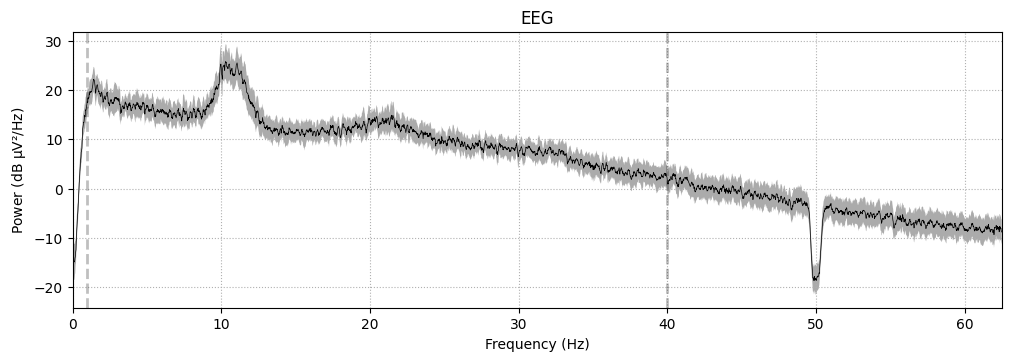

In [16]:
baseline_epochs.plot_psd(average=True)

In [9]:
from matplotlib.colors import TwoSlopeNorm
marker_id = 1029
event_epochs = mne.read_epochs(f'epochs/sub-P115-Omnideck2_epochs_{marker_id}_bad_ch_removed_epo.fif')
baseline_epoch_data = av_epoch.get_data()

baseline_repeated = np.tile(baseline_epoch_data[None, :, :], (event_epochs.get_data().shape[0], 1, 1))
epoch_data_combined = np.concatenate([np.squeeze(baseline_repeated), event_epochs.get_data()], axis=-1)
epochs_combined = mne.EpochsArray(epoch_data_combined, info=event_epochs.info)

freqs = np.arange(2,30)
vmin, vmax = -60, 100
cnorm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
baseline = (0, 2)
kwargs = dict(
    n_permutations=100, step_down_p=0.05, seed=1, buffer_size=None, out_type="mask"
)
tfr = epochs_combined.compute_tfr(
    method="morlet",
    freqs=freqs,
    picks=['F3', 'Fz', 'F4', 'FC1', 'FC2', 'C3', 'Cz', 'C4', 'CP1', 'CP2'],
    n_cycles=freqs,
    use_fft=True,
    return_itc=False,
    average=False,
    decim=2,
)
tfr.crop(0, 11).apply_baseline(baseline, mode="percent")

Data type,Power Estimates
Data source,Epochs
Number of epochs,19
Dims,"epoch, channel, freq, time"
Estimation method,morlet
Number of channels,10
Number of timepoints,2751
Number of frequency bins,28
Frequency range,2.00 – 29.00 Hz


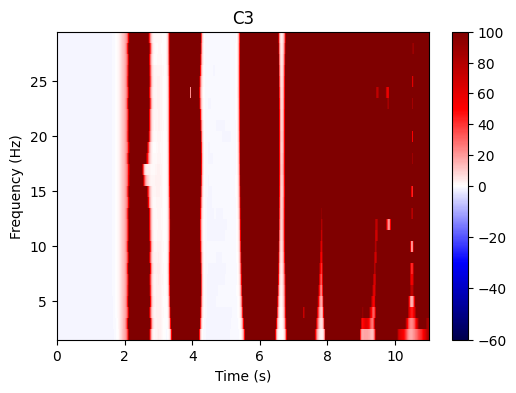

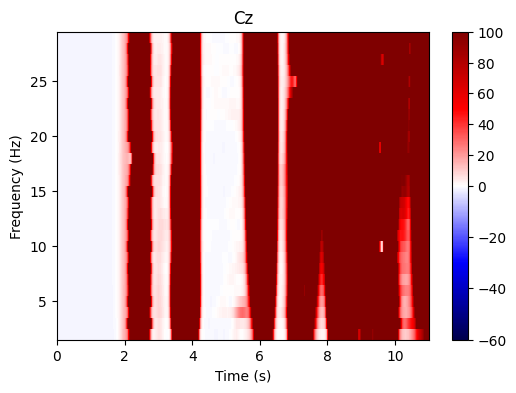

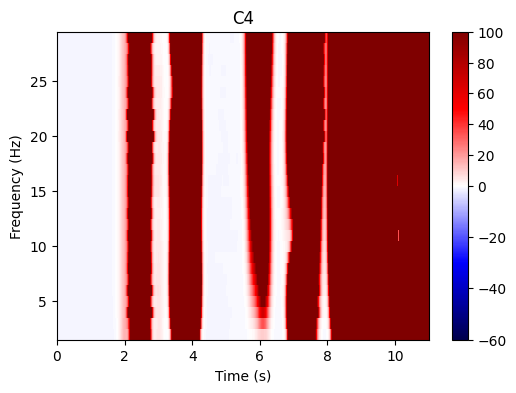

In [10]:
for ch_idx, ch_name in enumerate(['C3', 'Cz', 'C4']):
    fig, ax = plt.subplots(figsize=(6, 4))  # Create figure for each channel
    tfr.average().plot(
        picks=[ch_name], cmap='seismic', cnorm=cnorm, axes=ax, colorbar=True, show=False
    )
    ax.set_title(f"{ch_name}")  # Add channel name as title
    plt.savefig(f'figures/meeting/P115/ERDS/{marker_id}/{marker_id}_{ch_name}.png')
    plt.show()

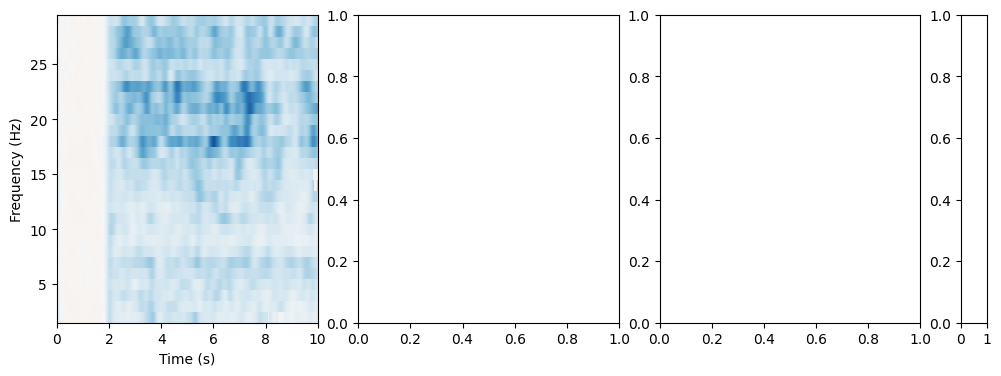

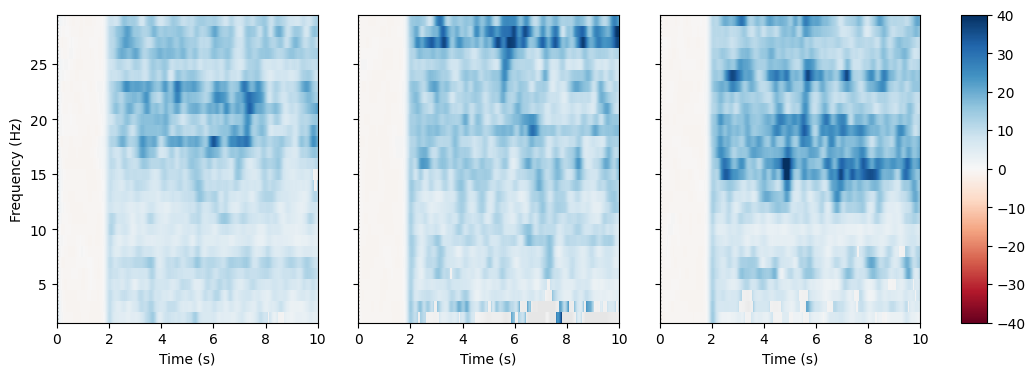

In [16]:
#TODO: Try the mne code for ERDS
from mne.stats import permutation_cluster_1samp_test as pcluster_test
fig, axes = plt.subplots(
    1, 4, figsize=(12, 4), gridspec_kw={"width_ratios": [10, 10, 10, 1]}
)
for ch, ax in enumerate(axes[:-1]):  # for each channel
    # positive clusters
    _, c1, p1, _ = pcluster_test(tfr.data[:, ch], tail=1, **kwargs)
    # negative clusters
    _, c2, p2, _ = pcluster_test(tfr.data[:, ch], tail=-1, **kwargs)

    # note that we keep clusters with p <= 0.05 from the combined clusters
    # of two independent tests; in this example, we do not correct for
    # these two comparisons
    c = np.stack(c1 + c2, axis=2)  # combined clusters
    p = np.concatenate((p1, p2))  # combined p-values
    mask = c[..., p <= 0.05].any(axis=-1)

    # plot TFR (ERDS map with masking)
    tfr.average().plot(
        [ch],
        cmap="RdBu",
        cnorm=cnorm,
        axes=ax,
        colorbar=False,
        show=False,
        mask=mask,
        mask_style="mask",
    )

    #ax.set_title(epochs.ch_names[ch], fontsize=10)
    ax.axvline(0, linewidth=1, color="black", linestyle=":")  # event
    if ch != 0:
        ax.set_ylabel("")
        ax.set_yticklabels("")
fig.colorbar(axes[0].images[-1], cax=axes[-1]).ax.set_yscale("linear")
plt.show()

In [ ]:
# 30seconds of start of Trial. Participant 105, 106
# TODO: adjust so the previous pilot data can also be used? Its a bit more complicated as there is some problems with the marker streams but can be done
participants = ['P105','P106']
for p in participants:
    path = f'data\\{p}\\'
    # Walking, Omnideck, Leaning, Joystick
    evoked_lists = [[],[],[],[]]
    for filename in sorted(os.listdir(path)):
        match = re.sub(r"_ses-", "-", filename.split("_task-Default_run")[0])
        raw, marker_stream, event_samples = get_data(path+filename)
        # Participant 106 leaning first trial does not have the start trial marker



        # If we are in Leaning_S001 for P106 we only filter data and go to next as the start trial marker is missing
        if 'P106_ses-Leaning_S001' not in filename:
            # --------------------------------------------------- #
            # Plotting the first 30 seconds raw and filtered #
            epochs = get_epochs(raw, marker_stream, event_samples, marker_id=1001, t_min=0, t_max=30)
            fig = epochs.plot(scalings=5e-5, title=f'{match}_raw_30s', show=False) #5e-5
            fig.savefig(f'figures\\meeting\\{p}\\{match}_30s_raw.png')
            raw = filter_data(raw)
            # Spectrum #
            fig = raw.compute_psd(fmax=100).plot(average=True, show=False)
            fig.savefig(f'figures\\meeting\\{p}\\psd\\{match}_psd.png')

            epochs = get_epochs(raw, marker_stream, event_samples, marker_id=1001, t_min=0, t_max=30)
            fig = epochs.plot(scalings=5e-5, title=f'{match}_filtered_30s', show=False) #5e-5
            fig.savefig(f'figures\\meeting\\{p}\\{match}_30s_filtered.png')

            # --------------------------------------------------- #
            # Plotting Topomaps of the First 30seconds every 2 seconds#
            evoked = epochs.average()
            plot_times = list(range(0,31,2))
            fig = evoked.plot_topomap(times=plot_times, show=False)
            fig.savefig(f'figures\\meeting\\{p}\\topomap\\{match}_topomap.png')
        else:
            raw = filter_data(raw)
            # Spectrum #
            fig = raw.compute_psd(fmax=100).plot(average=True, show=False)
            fig.savefig(f'figures\\meeting\\{p}\\psd\\{match}_psd.png')

        # --------------------------------------------------- #
        # ICA #
        marker = 1007
        epochs = get_epochs(raw, marker_stream, event_samples, marker_id=marker, t_min=-6, t_max=6, preload=True, ica=True)
        ica, rej_ch = get_ica(epochs.load_data(), plot=True, save_path=f'figures\\meeting\\{p}\\ica\\{match}', match = match)
        # Maybe plot some before/after plots

        # --------------------------------------------------- #
        #ERDS
        #TODO: Ask what the basline should be in this case, as there is always movement expect in the very beginning of the trial
        """freqs = np.arange(2,30)
        vmin, vmax = -1, 1.5

        baseline = (-6, -5)
        kwargs = dict(
            n_permutations=100, step_down_p=0.05, seed=1, buffer_size=None, out_type="mask"
        )
        tfr = epochs.compute_tfr(
            method="multitaper",
            freqs=freqs,
            picks=['C3', 'Cz', 'C4'],
            n_cycles=freqs,
            use_fft=True,
            return_itc=False,
            average=False,
            decim=2,
        )
        tfr.crop(-6, 6).apply_baseline(baseline, mode="percent")"""

        # --------------------------------------------------- #
        #MRCP
        epochs = get_epochs(raw, marker_stream, event_samples, marker_id=marker, t_min=-6, t_max=6, preload=True, ica=False)
        ica.apply(epochs, exclude=rej_ch, verbose=False)
        evoked = mrcp(epochs)
        if 'Walking' in filename:
            evoked_lists[0].append(evoked)
        elif 'Omnideck' in filename:
            evoked_lists[1].append(evoked)
        elif 'Leaning' in filename:
            evoked_lists[2].append(evoked)
        else:
            evoked_lists[3].append(evoked)

        fig = evoked.plot(titles=f'{match}_{marker}_evoked', show=False)
        fig.savefig(f'figures\\meeting\\{p}\\mrcp\\{match}_{marker}_mrcp.png')

        # --------------------------------------------------- #

    # Grand average MRCP
    cond_names = ['Walking', 'Omnideck', 'Leaning', 'Joystick']
    for cond_nr, ev in enumerate(evoked_lists):
        if not ev:
            continue
        ga = mne.grand_average(ev)
        fig = ga.plot(titles=f'{cond_names[cond_nr]}_{marker}_evoked_average', show=False)
        fig.savefig(f'figures\\meeting\\{p}\\mrcp\\{cond_names[cond_nr]}_{marker}_mrcp_average.png')


In [26]:
import matplotlib
%matplotlib qt
matplotlib.use('Qt5Agg')
from matplotlib.colors import TwoSlopeNorm

In [9]:
# TODO: This code has to be updated again for the new P110 markers and also first combine data and then ICA
event_marker = 1027
baseline_marker = 1001
participants = ['P110']
for p in participants:
    path = f'data\\{p}\\'
    # Walking, Omnideck, Leaning, Joystick
    for filename in sorted(os.listdir(path)):
        match = re.sub(r"_ses-", "-", filename.split("_task-Default_run")[0])
        raw, marker_stream, event_samples = get_data(path+filename)
        raw = filter_data(raw)
        baseline_epoch = get_epochs(raw, marker_stream, event_samples, marker_id=baseline_marker, t_min=-30, t_max=-28)[0] # Baseline epoch before the experiment
        event_epochs = get_epochs(raw, marker_stream, event_samples, marker_id=event_marker, t_min=-4, t_max=4, ica=True)
        event_epochs = drop_bad_epochs(event_epochs)

        baseline_epoch = baseline_epoch.get_data()

          # Match trials
        baseline_repeated = np.tile(baseline_epoch[None, :, :], (event_epochs.get_data().shape[0], 1, 1))
        epoch_data_combined = np.concatenate([np.squeeze(baseline_repeated), event_epochs.get_data()], axis=-1)
        epochs_combined = mne.EpochsArray(epoch_data_combined, info=event_epochs.info)
        ica, rej_ch = get_ica(epochs_combined)
        ica.apply(epochs_combined, exclude=rej_ch, verbose=False)

        epochs_combined.save(f'figures\\meeting\\{p}\\epochs\\{match}_epochs_combined_{event_marker}-epo.fif', overwrite=True)


Stream 2: Calculated effective sampling rate 2016.1646 Hz is different from specified rate 100.0000 Hz.


Creating RawArray with float64 data, n_channels=32, n_times=701523
    Range : 0 ... 701522 =      0.000 ...  1403.044 secs
Ready.
Using data from preloaded Raw for 19 events and 4001 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 1 events and 1001 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 11 events and 4001 original time points ...
Using data from preloaded Raw for 11 events and 4001 original time points ...
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated


Stream 4: Calculated effective sampling rate 2510.5602 Hz is different from specified rate 100.0000 Hz.


Creating RawArray with float64 data, n_channels=32, n_times=378015
    Range : 0 ... 378014 =      0.000 ...   756.028 secs
Ready.
Using data from preloaded Raw for 19 events and 4001 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 1 events and 1001 original time points ...
1 bad epochs dropped
Using data from preloaded Raw for 15 events and 4001 original time points ...
Using data from preloaded Raw for 15 events and 4001 original time points ...


C:\Users\stadl\AppData\Local\Temp\ipykernel_2416\1364410403.py:16: RuntimeWarning: All epochs were dropped!
You might need to alter reject/flat-criteria or drop bad channels to avoid this. You can use Epochs.plot_drop_log() to see which channels are responsible for the dropping of epochs.
  baseline_epoch = baseline_epoch.get_data()


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 0 and the array at index 1 has size 15

# This was previous code not sure if above is all correct!
        ica, rej_ch = get_ica(event_epochs)
        event_epochs = get_epochs(raw, marker_stream, event_samples, marker_id=event_marker, t_min=-4, t_max=4, ica=False)

        # TODO: Fine grain the epoch rejection and handle the case if all are rejected!
        event_epochs = drop_bad_epochs(event_epochs)
        ica.apply(baseline_epochs.load_data(), exclude=rej_ch, verbose=False)
        ica.apply(event_epochs.load_data(), exclude=rej_ch, verbose=False)
        #event_epochs.plot(scalings=5e-5)
        baseline_avg = np.mean(baseline_epochs.get_data(), axis=0)
        event_data = event_epochs.get_data()

        n_trials, n_channels, n_times_event = event_data.shape
        n_times_baseline = baseline_avg.shape[1]

        data_combined = np.concatenate([np.tile(baseline_avg[None, :, :], (n_trials, 1, 1)), event_data], axis=-1)

        epochs_combined = mne.EpochsArray(data_combined, event_epochs.info)
        epochs_combined.save(f'figures\\meeting\\{p}\\epochs\\{match}_epochs_combined_{event_marker}-epo.fif', overwrite=True)

In [9]:
p = 'P115'
path = f'data/{p}/'# Windows: 'data\\P110\\'
filename = ('sub-P115_ses-Omnideck1_task-Default_run-001_eeg.xdf')
match = re.sub(r"_ses-", "-", filename.split("_task-Default_run")[0])
raw, marker_stream, event_samples = get_data(path+filename)
raw = filter_data(raw)
#raw.plot(scalings = 5e-5)

Stream 1: Calculated effective sampling rate 3445.9816 Hz is different from specified rate 100.0000 Hz.


In [10]:
baseline_marker = 1000
event_marker = 1027
baseline_epoch = get_epochs(raw, marker_stream, event_samples, marker_id=baseline_marker, t_min=0, t_max=60) # Baseline epoch before the experiment
#event_epochs = get_epochs(raw, marker_stream, event_samples, marker_id=event_marker, t_min=-4, t_max=4, ica=True)
#event_epochs = drop_bad_epochs(event_epochs)

In [16]:
fig = baseline_epoch[0].plot_psd(average=True, fmax=70)
plt.savefig(f'figures/meeting/{p}/baseline_comparison/{match}_baseline_psd_before.png')

/home/tim/RUG/Master_Thesis/master_thesis/.venv/lib/python3.12/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


In [17]:
fig = baseline_epoch[1].plot_psd(average=True, fmax=70)
plt.savefig(f'figures/meeting/{p}/baseline_comparison/{match}_baseline_psd_after.png')

/home/tim/RUG/Master_Thesis/master_thesis/.venv/lib/python3.12/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


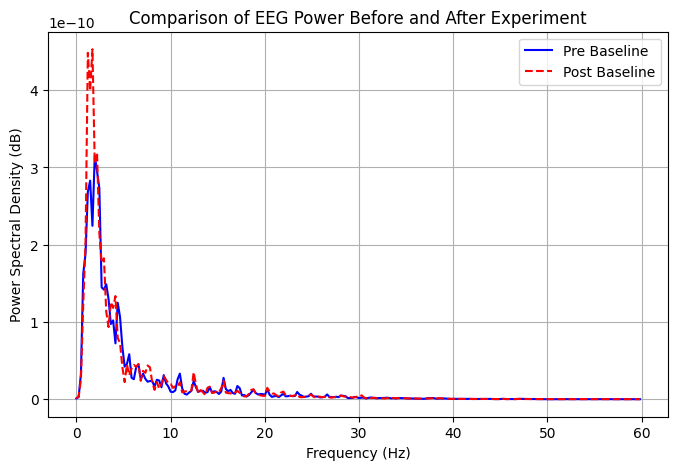

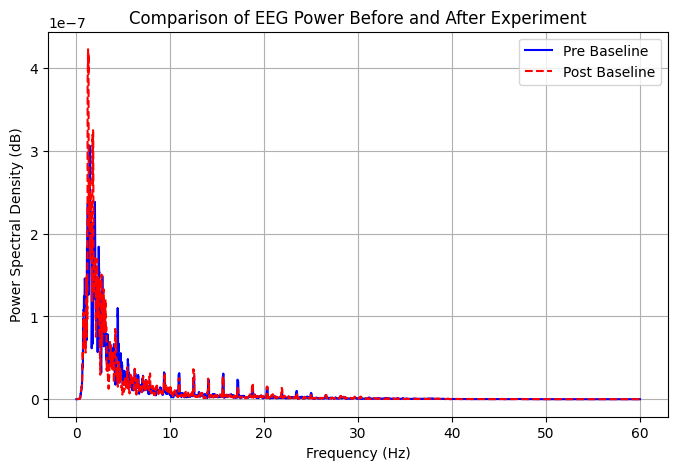

In [15]:
# Looking at Baseline periods
# Compute PSD for pre- and post-experiment baseline
psd_pre, freqs = baseline_epoch[0].compute_psd(method="welch", fmax=60).get_data(return_freqs=True)  # (n_epochs, n_channels, n_freqs)
psd_post, _ = baseline_epoch[1].compute_psd(method="welch", fmax=60).get_data(return_freqs=True)

# Average across epochs and channels
psd_pre_mean = psd_pre.mean(axis=(0, 1))  # Mean over (epochs, channels)
psd_post_mean = psd_post.mean(axis=(0, 1))

plt.figure(figsize=(8, 5))

plt.plot(freqs, psd_pre_mean, label="Pre Baseline", color="blue")
plt.plot(freqs, psd_post_mean, label="Post Baseline", color="red", linestyle="dashed")

plt.xlabel("Frequency (Hz)")
plt.ylabel("Power Spectral Density (dB)")
plt.title("Comparison of EEG Power Before and After Experiment")
plt.legend()
plt.grid(True)
plt.savefig(f'figures/meeting/{p}/baseline_comparison/{match}_psd_comparsion_welch.png')
plt.show()

psd_pre, freqs = baseline_epoch[0].compute_psd(method="multitaper", fmax=60).get_data(return_freqs=True)  # (n_epochs, n_channels, n_freqs)
psd_post, _ = baseline_epoch[1].compute_psd(method="multitaper", fmax=60).get_data(return_freqs=True)

# Average across epochs and channels
psd_pre_mean = psd_pre.mean(axis=(0, 1))  # Mean over (epochs, channels)
psd_post_mean = psd_post.mean(axis=(0, 1))

plt.figure(figsize=(8, 5))

plt.plot(freqs, psd_pre_mean, label="Pre Baseline", color="blue")
plt.plot(freqs, psd_post_mean, label="Post Baseline", color="red", linestyle="dashed")

plt.xlabel("Frequency (Hz)")
plt.ylabel("Power Spectral Density (dB)")
plt.title("Comparison of EEG Power Before and After Experiment")
plt.legend()
plt.grid(True)
plt.savefig(f'figures/meeting/{p}/baseline_comparison/{match}_psd_comparsion_multitaper.png')
plt.show()


In [93]:
baseline_marker = 1001
event_marker = 1029
baseline_epoch = get_epochs(raw, marker_stream, event_samples, marker_id=baseline_marker, t_min=-30, t_max=-28) # Baseline epoch before the experiment
event_epochs = get_epochs(raw, marker_stream, event_samples, marker_id=event_marker, t_min=-4, t_max=4, ica=True)
event_epochs = drop_bad_epochs(event_epochs)
baseline_epoch_data = baseline_epoch[0].get_data()
# Match trials
baseline_repeated = np.tile(baseline_epoch_data[None, :, :], (event_epochs.get_data().shape[0], 1, 1))
epoch_data_combined = np.concatenate([np.squeeze(baseline_repeated), event_epochs.get_data()], axis=-1)
epochs_combined = mne.EpochsArray(epoch_data_combined, info=event_epochs.info)

ica, rej_ch = get_ica(event_epochs)
print(rej_ch)
ica.apply(epochs_combined, exclude=rej_ch, verbose=False)

Using data from preloaded Raw for 19 events and 4001 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 1 events and 1001 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 12 events and 4001 original time points ...
Using data from preloaded Raw for 12 events and 4001 original time points ...
Not setting metadata
12 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 12 events and 4001 original time points ...
Using data from preloaded Raw for 12 events and 4001 original time points ...
[4, 9, 10, 17, 19]


<EpochsArray | 12 events (all good), 0 – 10.002 s (baseline off), ~14.7 MB, data loaded,
 '1': 12>

In [94]:
fig = baseline_epoch.plot_psd(average=True)
fig.suptitle("Baseline psd")
plt.savefig(f'figures\\meeting\\P110\\psd\\{match}_baseline_psd.png')
plt.close(fig)
fig = event_epochs.plot_psd(average=True)
fig.suptitle(f"Marker {event_marker} psd")
plt.savefig(f'figures\\meeting\\P110\\psd\\{match}_event_marker_psd.png')
plt.close(fig)

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Using data from preloaded Raw for 2 events and 1001 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs before plotting...
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Using data from preloaded Raw for 12 events and 4001 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs before plotting...


In [95]:
freqs = np.arange(2,20)
vmin, vmax = -10, 10
cnorm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
baseline = (0, 2)
kwargs = dict(
    n_permutations=100, step_down_p=0.05, seed=1, buffer_size=None, out_type="mask"
)
tfr = epochs_combined.compute_tfr(
    method="morlet",
    freqs=freqs,
    picks=['F3', 'Fz', 'F4', 'FC1', 'FC2', 'C3', 'Cz', 'C4', 'CP1', 'CP2'],
    n_cycles=freqs,
    use_fft=True,
    return_itc=False,
    average=False,
    decim=2,
)
tfr.crop(0, 10).apply_baseline(baseline, mode="percent")

Applying baseline correction (mode: percent)


Data type,Power Estimates
Data source,Epochs
Number of epochs,12
Dims,"epoch, channel, freq, time"
Estimation method,morlet
Number of channels,10
Number of timepoints,2501
Number of frequency bins,18
Frequency range,2.00 – 19.00 Hz


In [96]:
for ch_idx, ch_name in enumerate(['F3', 'Fz', 'F4', 'FC1', 'FC2', 'C3', 'Cz', 'C4', 'CP1', 'CP2']):
    fig, ax = plt.subplots(figsize=(6, 4))  # Create figure for each channel
    tfr.average().plot(
        picks=[ch_name], cmap='seismic', cnorm=cnorm, axes=ax, colorbar=True, show=False
    )
    ax.set_title(f"{ch_name}")  # Add channel name as title
    plt.savefig(f'figures\\meeting\\P110\\ERDS\\{event_marker}\\{match}_{ch_name}.png')
    plt.show()

No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied


['Fp1',
 'Fz',
 'F3',
 'F7',
 'F9',
 'FC5',
 'FC1',
 'C3',
 'T7',
 'CP5',
 'CP1',
 'Pz',
 'P3',
 'P7',
 'P9',
 'O1',
 'Oz',
 'O2',
 'P10',
 'P8',
 'P4',
 'CP2',
 'CP6',
 'T8',
 'C4',
 'Cz',
 'FC2',
 'FC6',
 'F10',
 'F8',
 'F4',
 'Fp2']